In [1]:
library(leaps)
library(glmnet)
library(reshape2)
library(ggplot2)
library(corrplot)
library(grDevices)

Loading required package: Matrix

Loaded glmnet 3.0


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

corrplot 0.84 loaded



## IMPORTATION DES DONNEES

In [2]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après :

In [3]:
data = data_tot[,-c(81,82,83,84)]
data_but = data_tot[,-c(34:46,81,82,83,84)]

In [4]:
nombre.methodes = 5
nb.variables = length(data[1,])
nb.variables.buts = length(data_but[1,])
df.variables.rating = data.frame("Noms" = colnames(data), "BIC" = rep(0,nb.variables), "Lasso" = rep(0,nb.variables), 
                          "ElasticNet" = rep(0,nb.variables))#, "NombreDeButs" = rep(0,nb.variables), 
                                 #"NombreDePoints" = rep(0,nb.variables))

df.variables.buts = data.frame("Noms" = colnames(data_but), "BIC" = rep(0,nb.variables.buts), "Lasso" = rep(0,nb.variables.buts), 
                          "ElasticNet" = rep(0,nb.variables.buts), "NombreDeButs" = rep(0,nb.variables.buts), 
                                 "NombreDePoints" = rep(0,nb.variables.buts))

In [5]:
df.variables.pays = data.frame("Noms" = colnames(data), "France" = rep(0,nb.variables), "Espagne" = rep(0,nb.variables), 
                          "Italie" = rep(0,nb.variables), "Argentine" = rep(0,nb.variables), 
                                 "Angleterre" = rep(0,nb.variables), "Allemagne" = rep(0,nb.variables))

## Sélection de variables

### BIC

In [6]:
choixb <- regsubsets(data_tot$Rating~., data=data,nbest=1, nvmax=10, method="seqrep")
choixb_buts <- regsubsets(data_tot$Rating~., data=data_but,nbest=1, nvmax=10, method="seqrep")

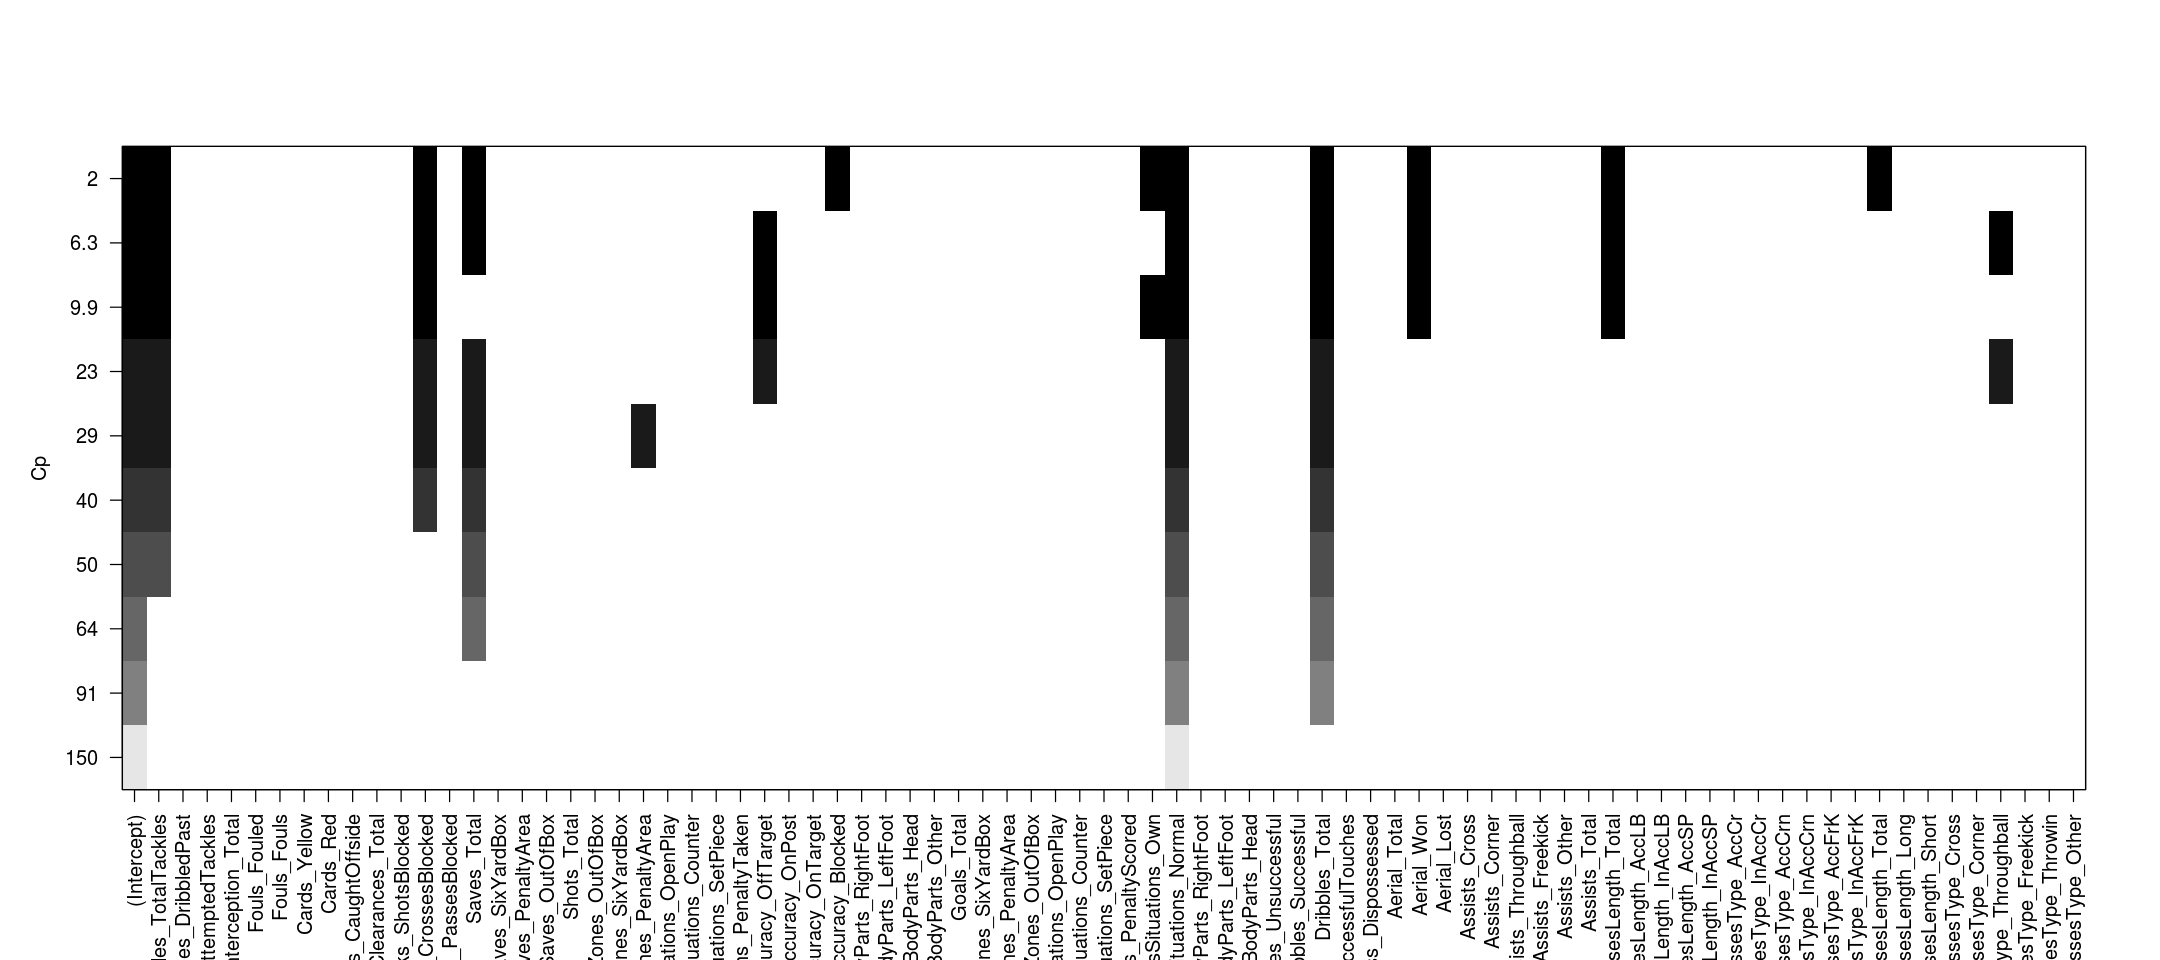

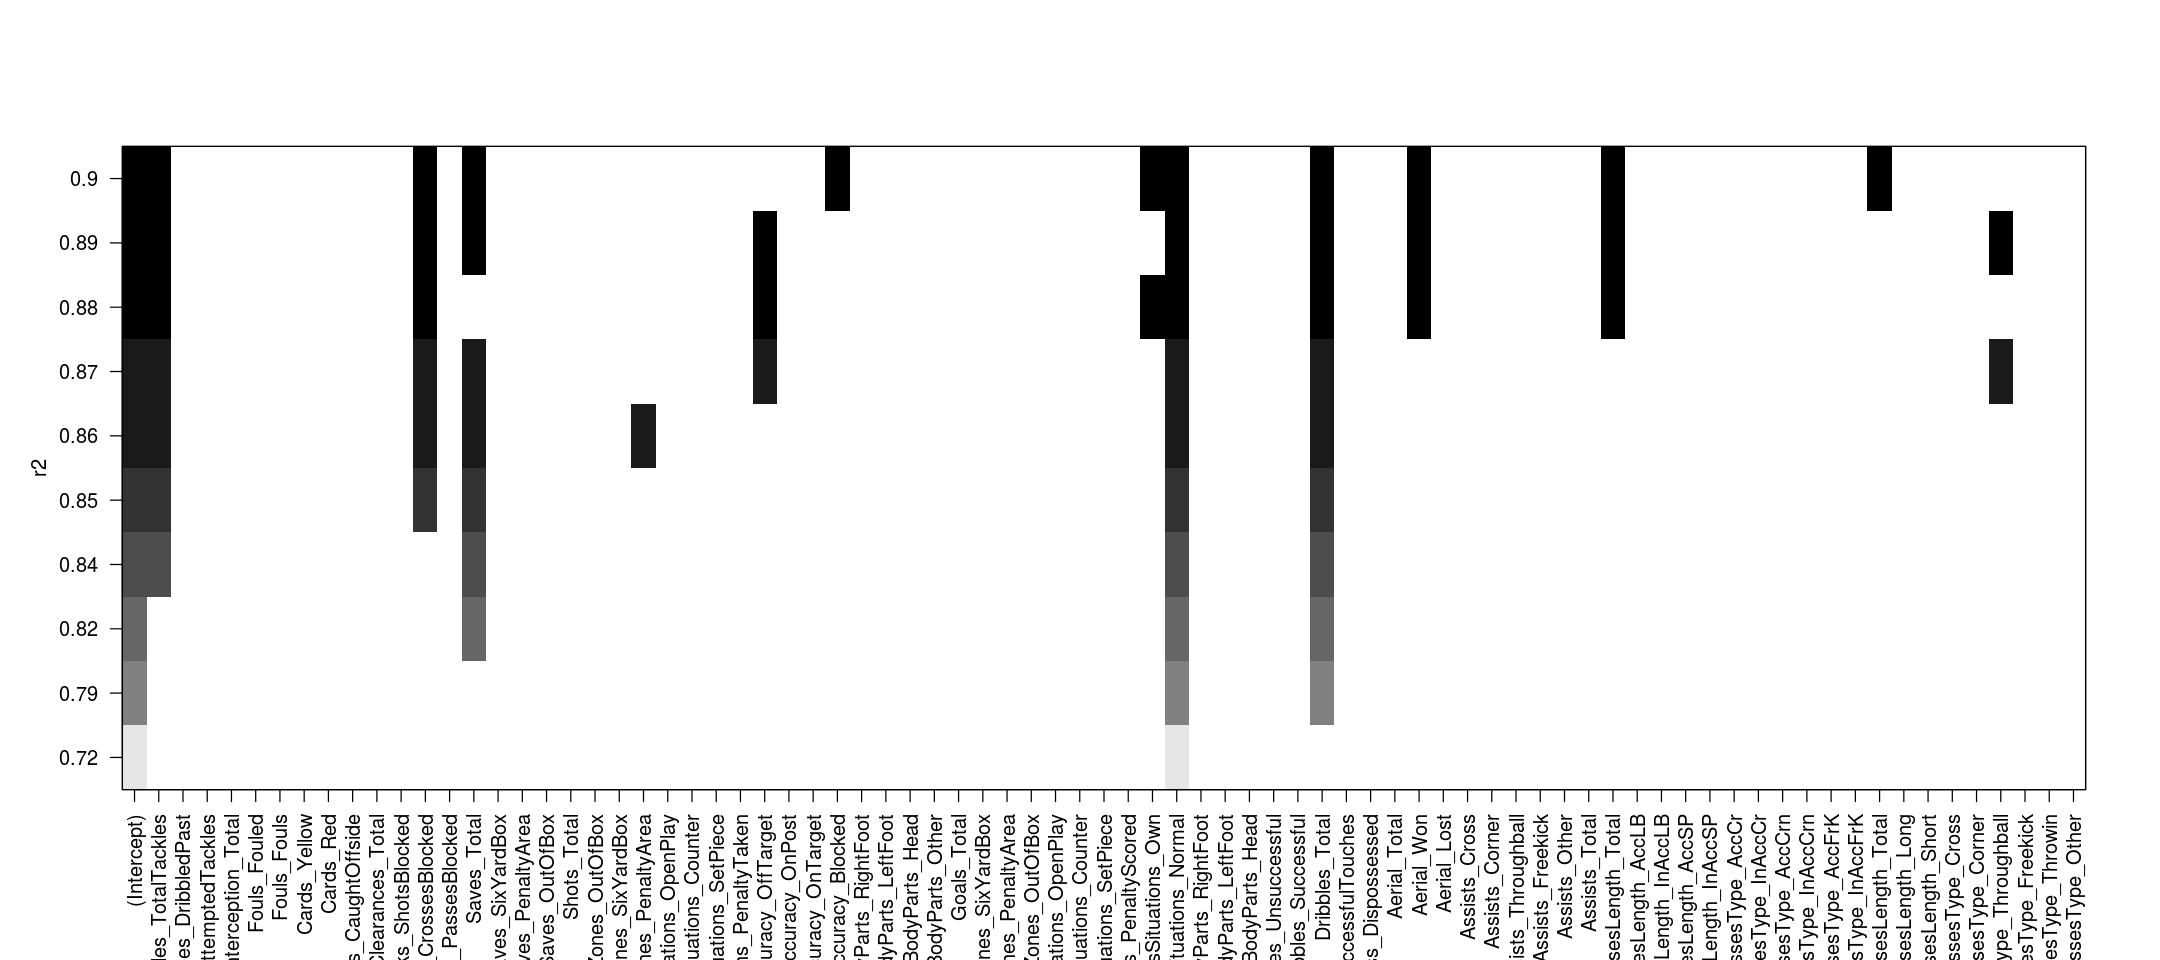

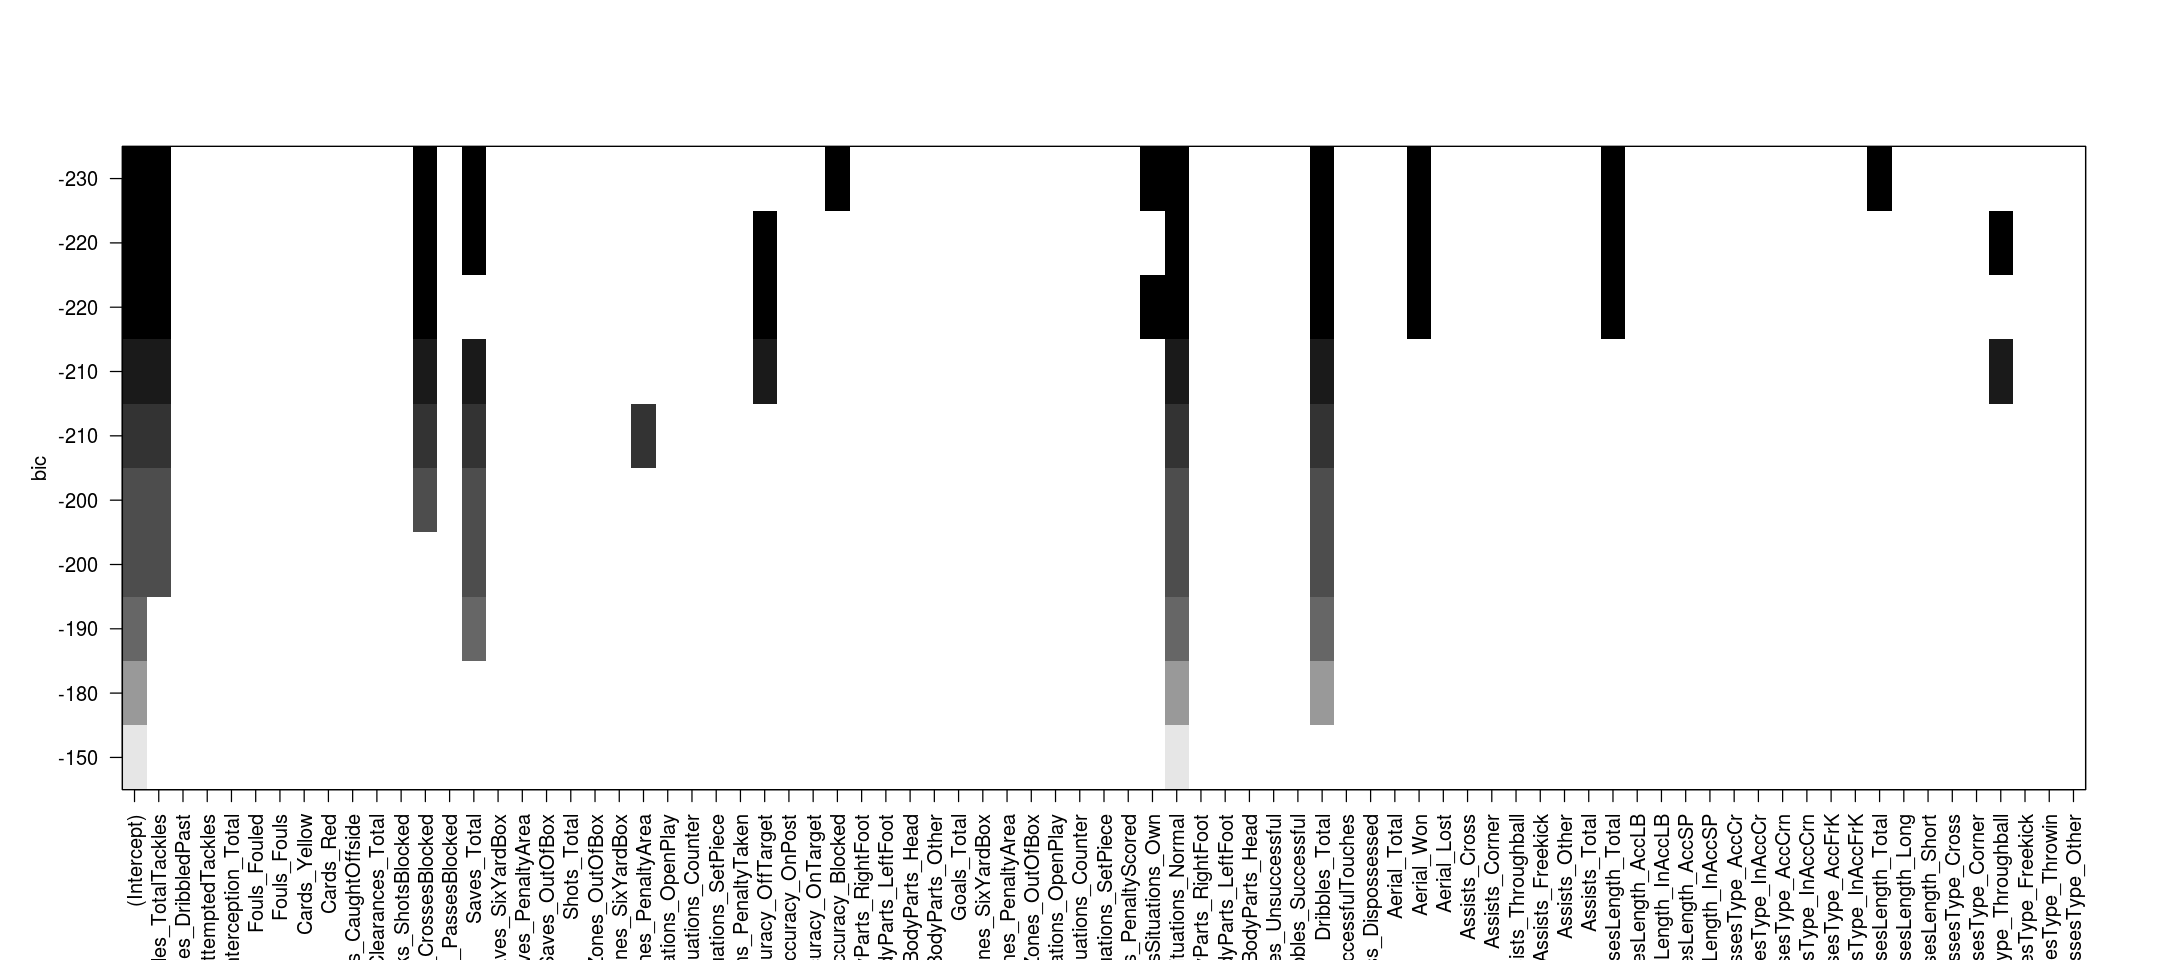

In [7]:
options(repr.plot.width=18, repr.plot.height=8)
plot(choixb,scale="Cp")
plot(choixb,scale="r2")
plot(choixb,scale="bic")

Les trois différents critères utilisés ci-dessus pour la sélection de modèle (Cp de Mallows, R2 et BIC) semblent donner les mêmes résultats.  
Suivant le critère choisi, il faut soit le maximiser (R2), soit le minimiser (Cp et BIC). Dans les deux cas, il s'agit de trouver les variables mises en noir sur la ligne du haut.

In [8]:
nb_min = which.min(summary(choixb)$bic)
vect = coef(choixb, nb_min)
vect

(Intercept)   Tackles_TotalTackles  Blocks_CrossesBlocked 
          5.7521591285           0.0116722139           0.0446894206 
           Saves_Total  ShotsAccuracy_Blocked    GoalsSituations_Own 
         -0.0197312817          -0.0298931883           0.2218527960 
GoalsSituations_Normal         Dribbles_Total             Aerial_Won 
          0.1946429462           0.0085251506           0.0070545723 
    PassesLength_Total  KeyPassesLength_Total 
          0.0003693942           0.0189994395

In [9]:
for (i in 1:nb.variables){
    for (j in 1:(length(names(vect))-1)){
        if (choixb$xnames[i+1] == names(vect)[j+1]){
            df.variables.rating$BIC[i] = round(vect[j+1],3)
        }
    } 
}

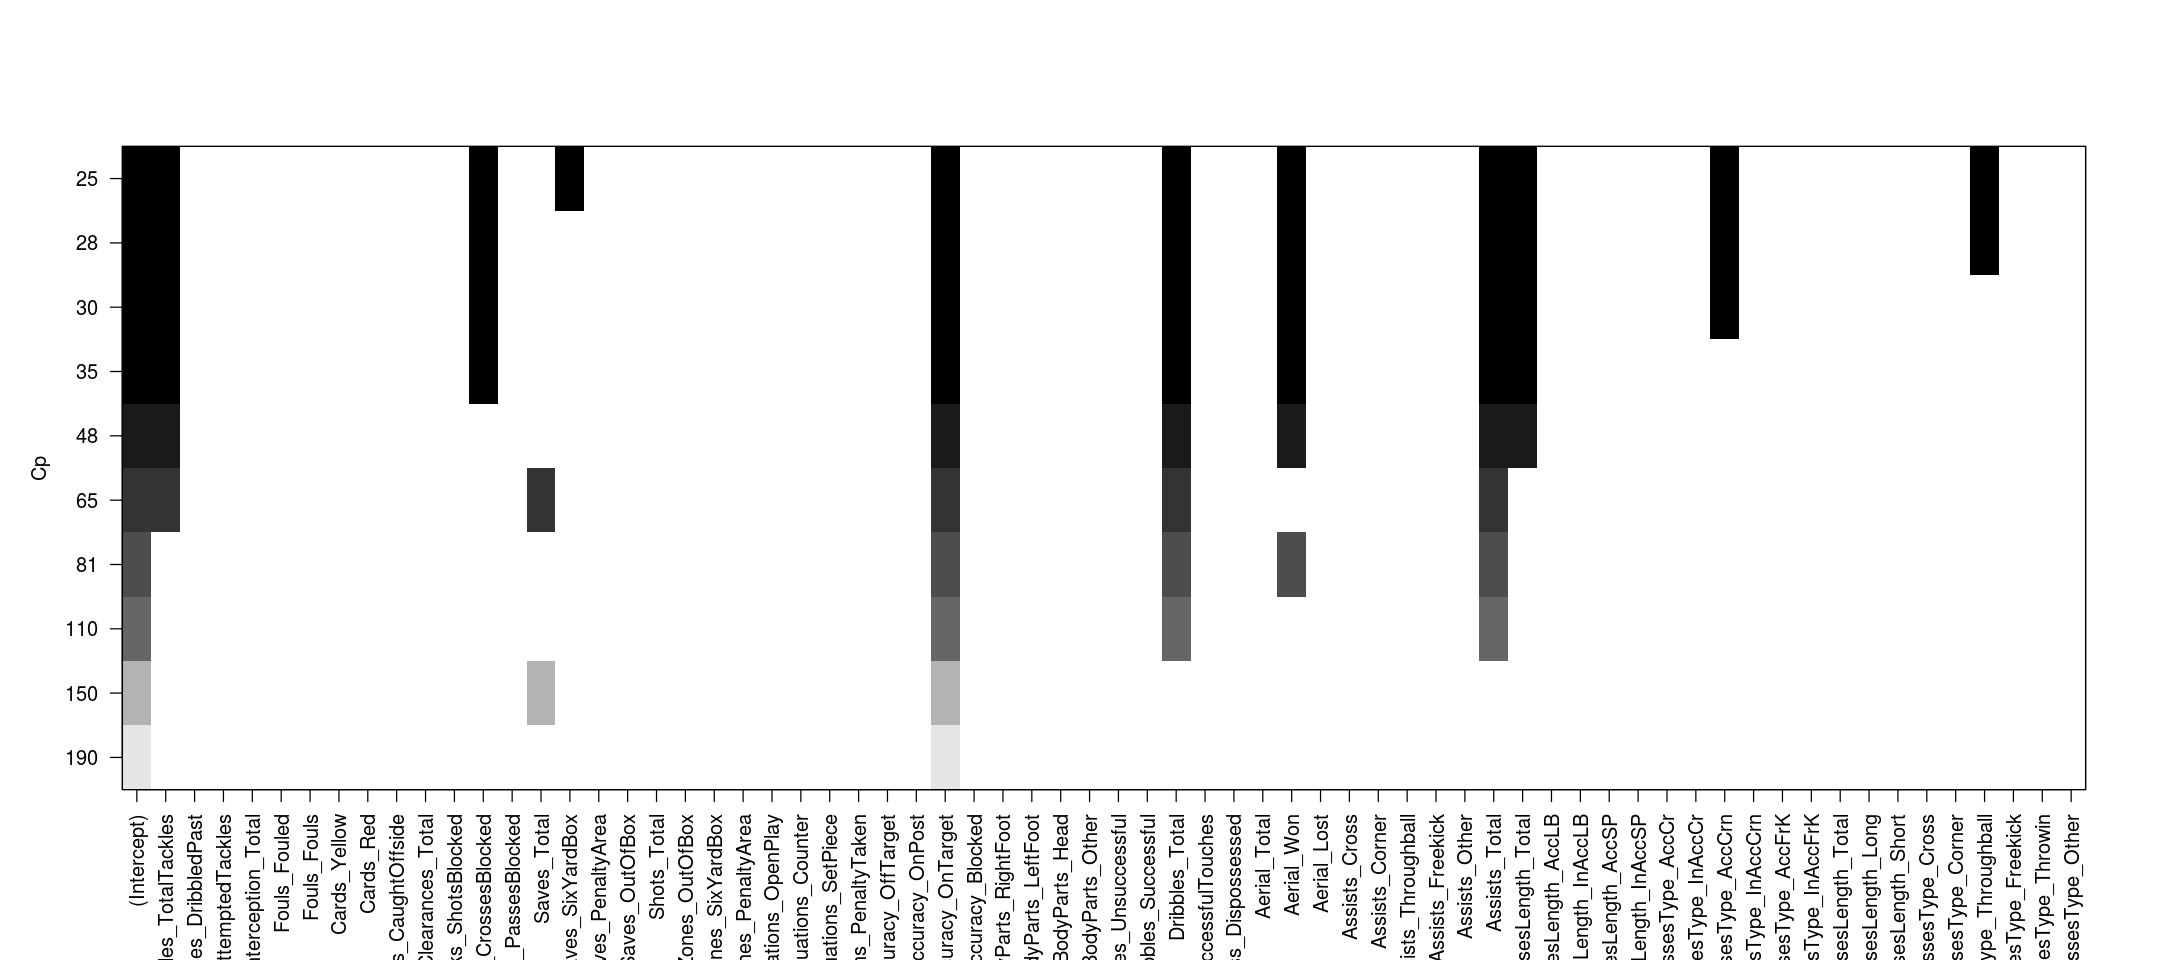

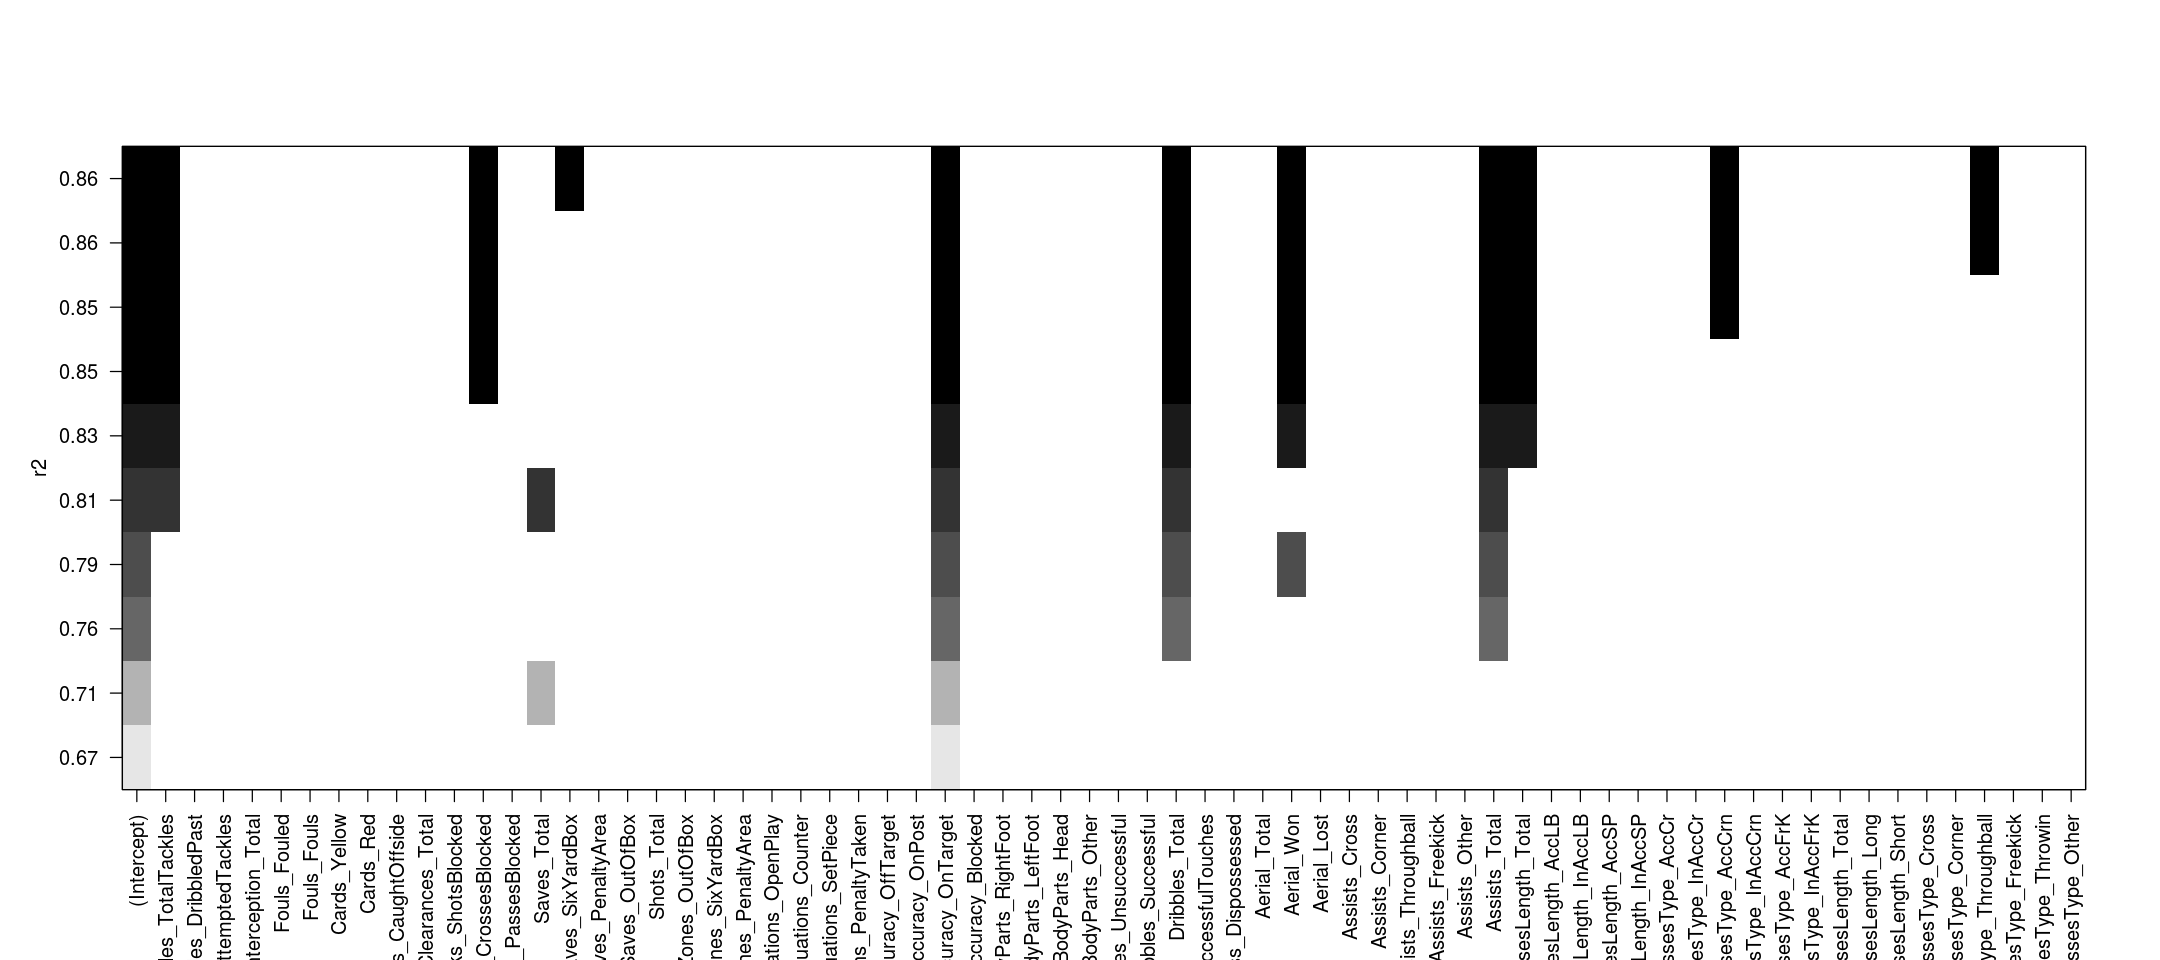

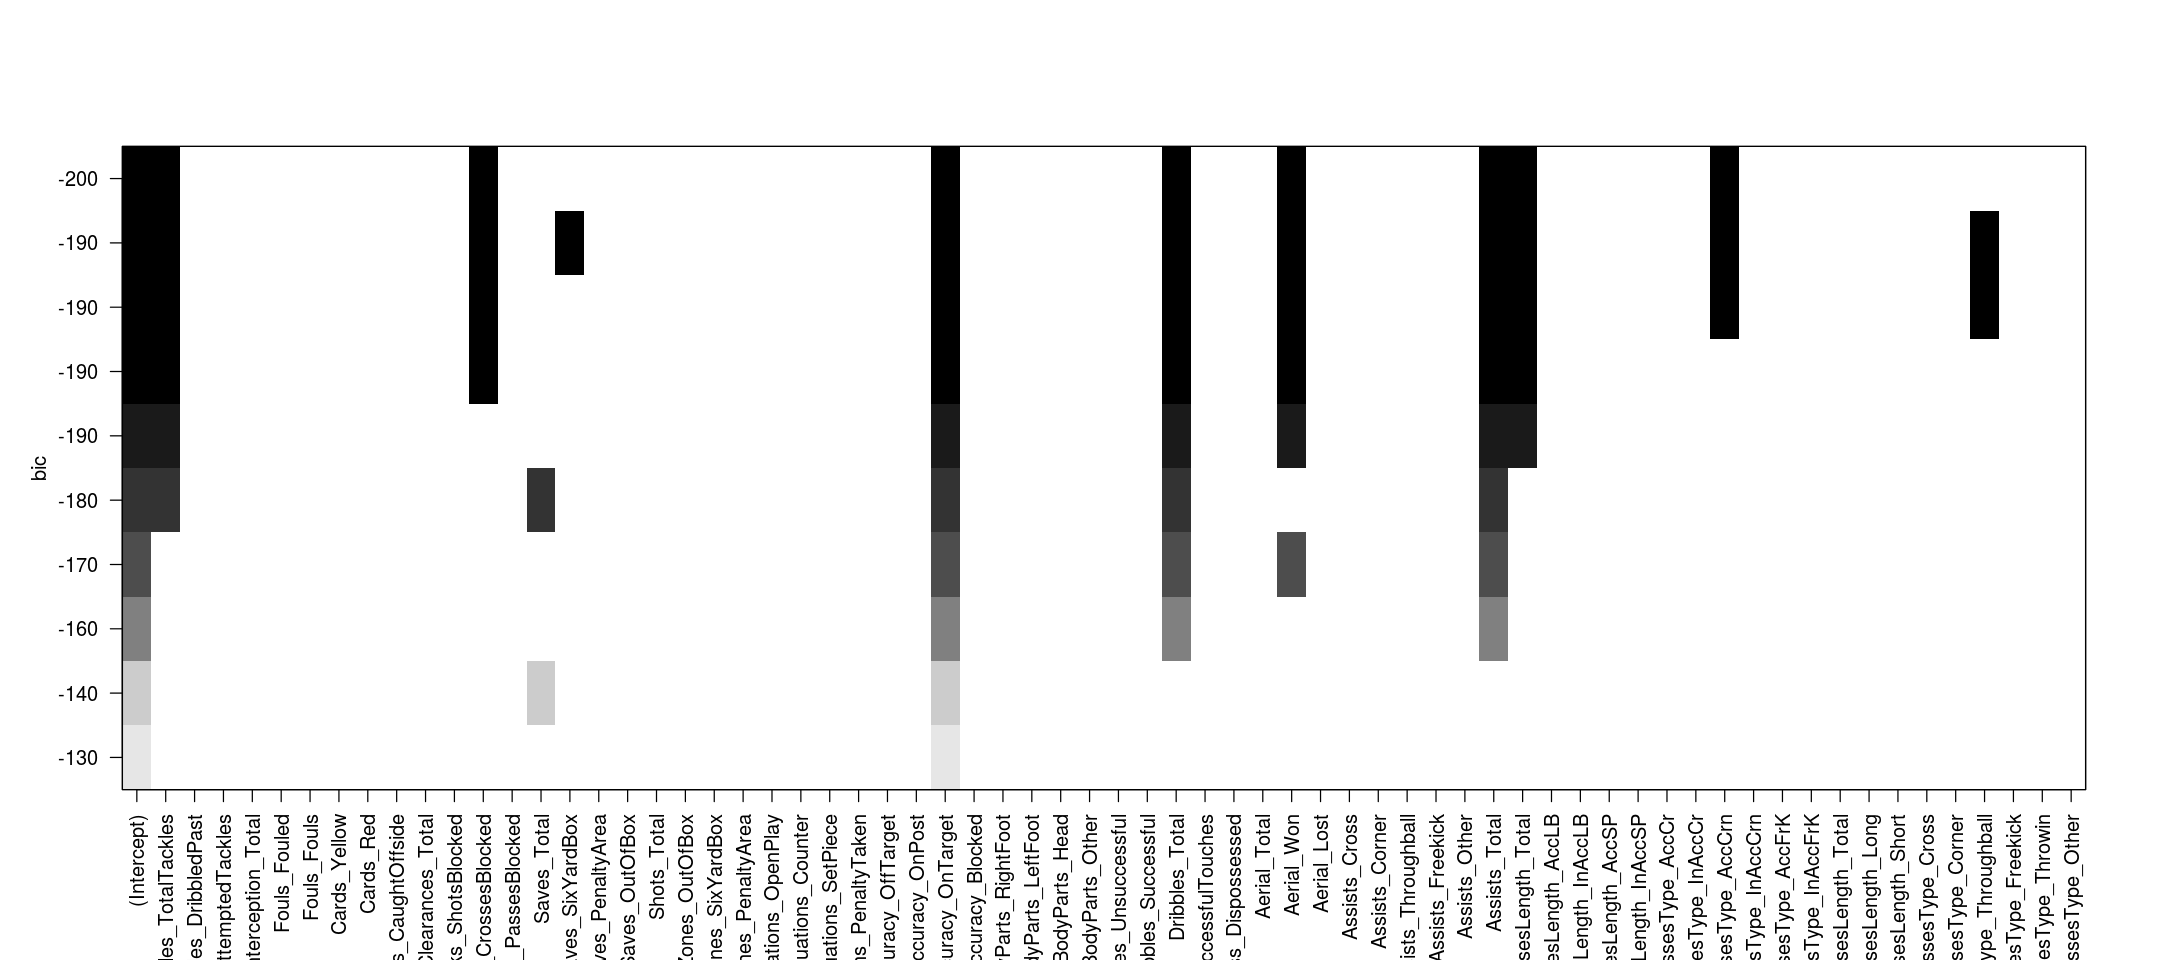

In [10]:
options(repr.plot.width=18, repr.plot.height=8)
plot(choixb_buts,scale="Cp")
plot(choixb_buts,scale="r2")
plot(choixb_buts,scale="bic")

In [11]:
nb_min = which.min(summary(choixb_buts)$bic)
vect_buts = coef(choixb_buts, nb_min)
vect_buts

(Intercept)   Tackles_TotalTackles  Blocks_CrossesBlocked 
          5.5372635920           0.0136765843           0.0425053889 
ShotsAccuracy_OnTarget         Dribbles_Total             Aerial_Won 
          0.0400970335           0.0092723701           0.0090353380 
         Assists_Total     PassesLength_Total      PassesType_AccCrn 
          0.1583701819           0.0004367107           0.0272108684

In [12]:
for (i in 1:nb.variables.buts){
    for (j in 1:(length(names(vect_buts))-1)){
        if (choixb_buts$xnames[i+1] == names(vect_buts)[j+1]){
            df.variables.buts$BIC[i] = round(vect_buts[j+1],3)
        }
    } 
}

In [13]:
data_bic = data.frame(data_tot$Rating, data_tot$Tackles_TotalTackles, data_tot$Blocks_CrossesBlocked, data_tot$Saves_Total, 
                     data_tot$ShotsAccuracy_Blocked, data_tot$GoalsSituations_Own, data_tot$GoalsSituations_Normal,
                     data_tot$Dribbles_Total, data_tot$Aerial_Won, data_tot$PassesLength_Total, data_tot$KeyPassesLength_Total)

names(data_bic) <- c("Rating", "Tackles_TotalTackles", "Blocks_CrossesBlocked", "Saves_Total", "ShotsAccuracy_Blocked", 
                     "GoalsSituations_Own", "GoalsSituations_Normal", "Dribbles_Total", "Aerial_Won",
                     "PassesLength_Total", "KeyPassesLength_Total")

In [14]:
reg_bic = lm(Rating~(.)^2, data = data_bic)

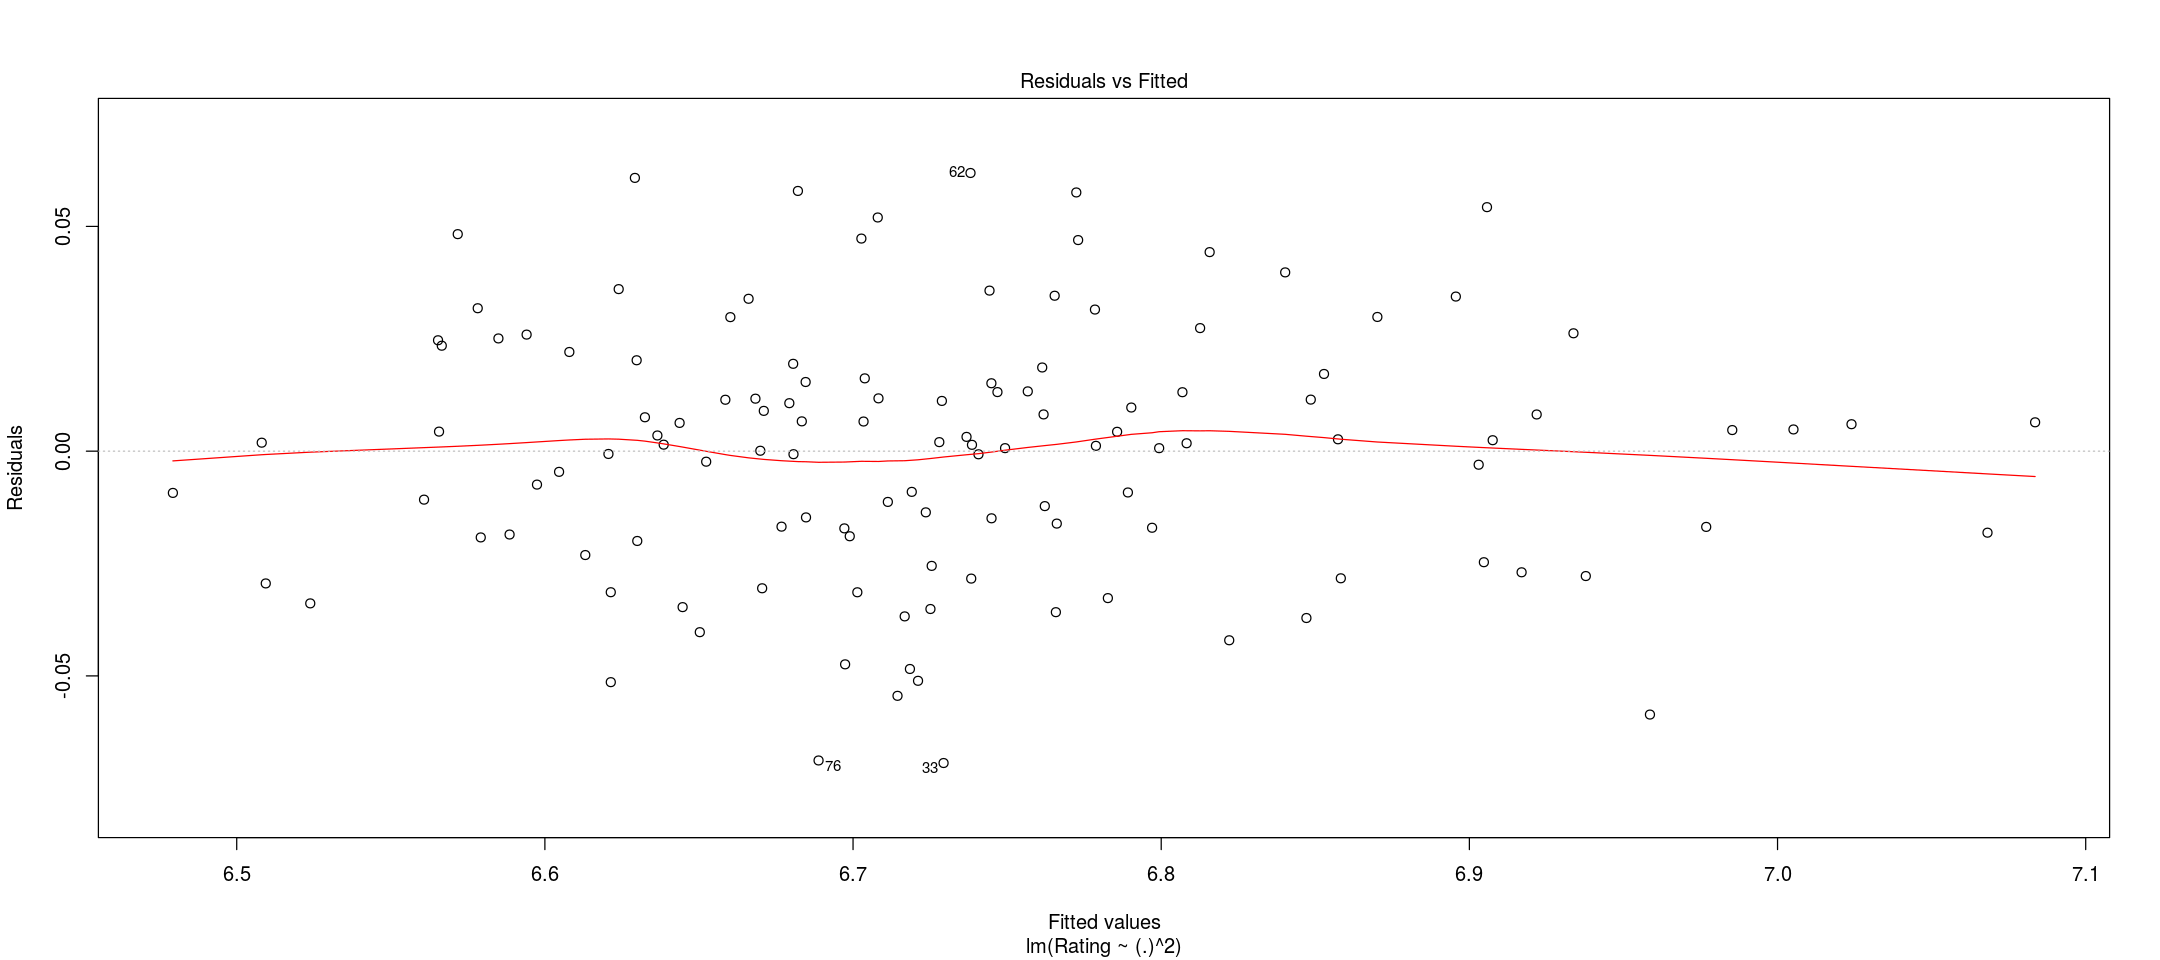

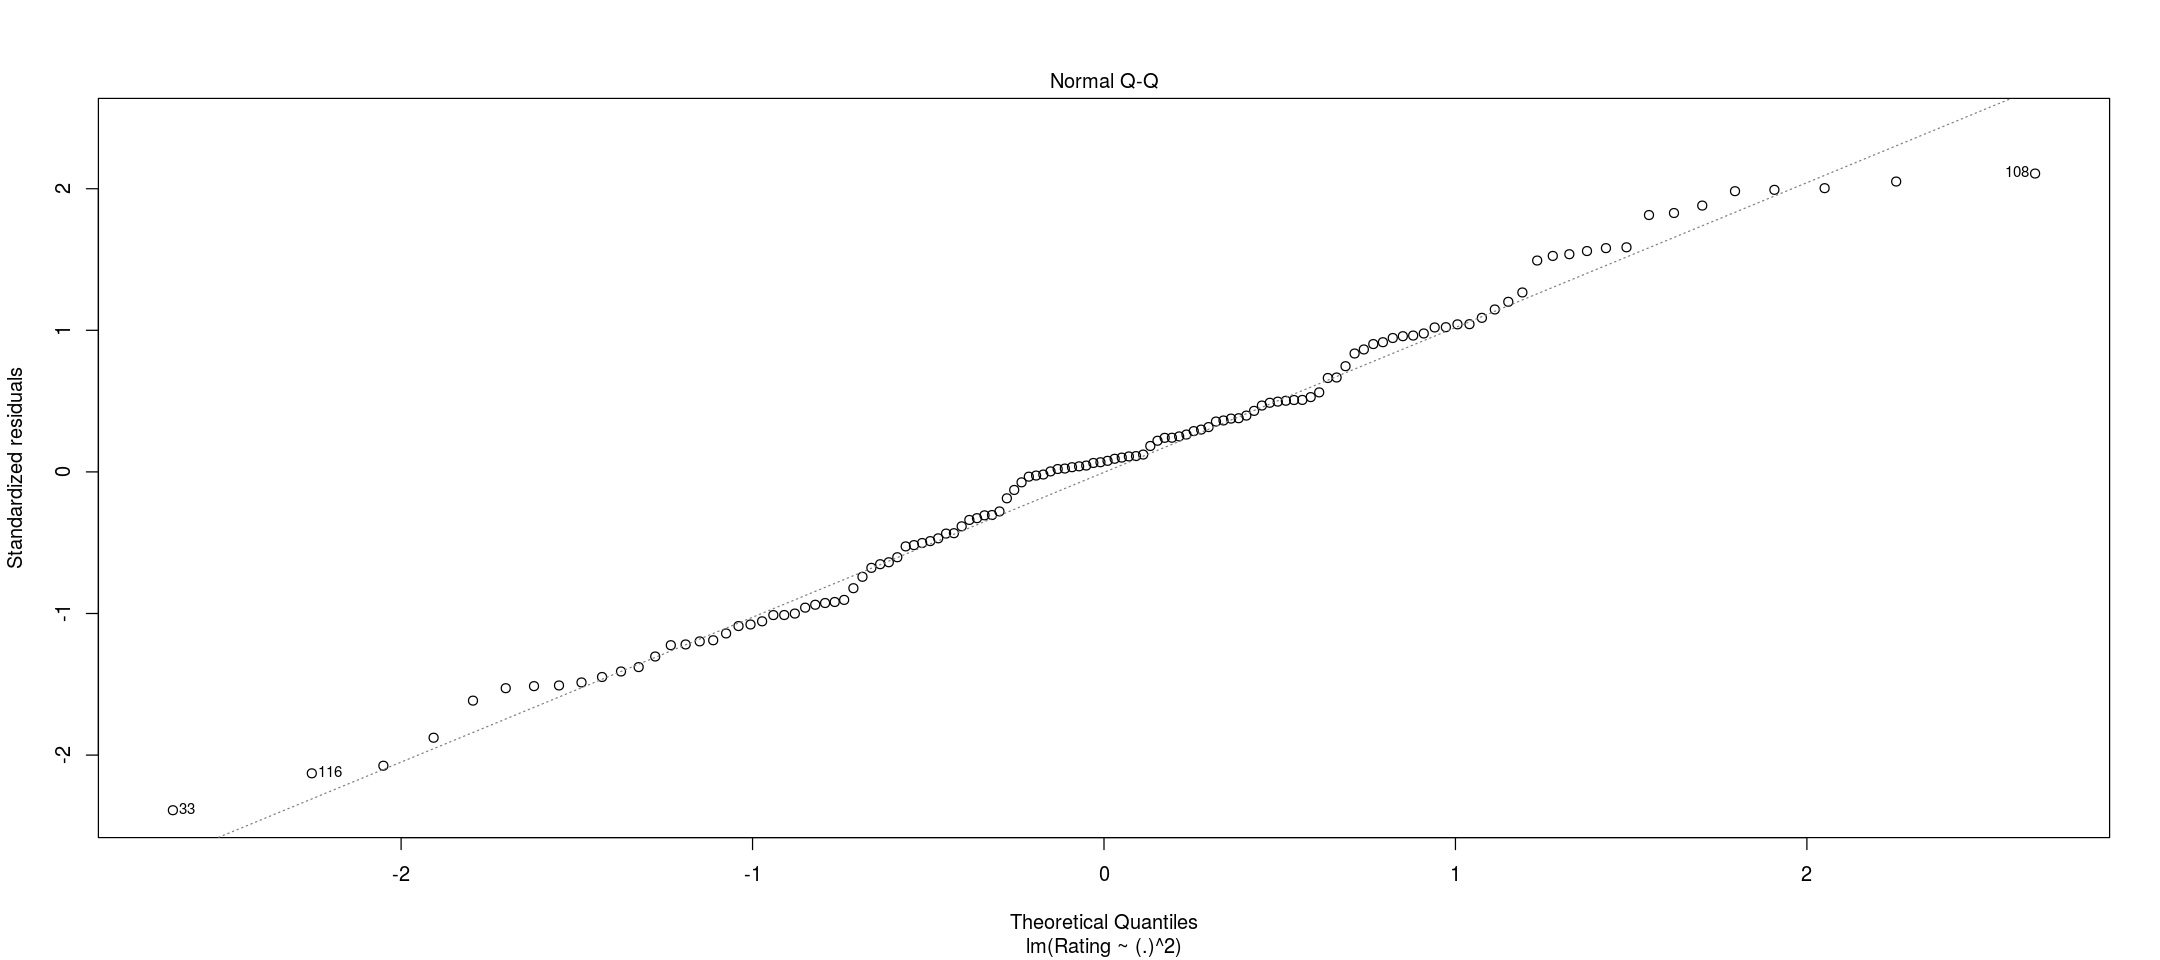

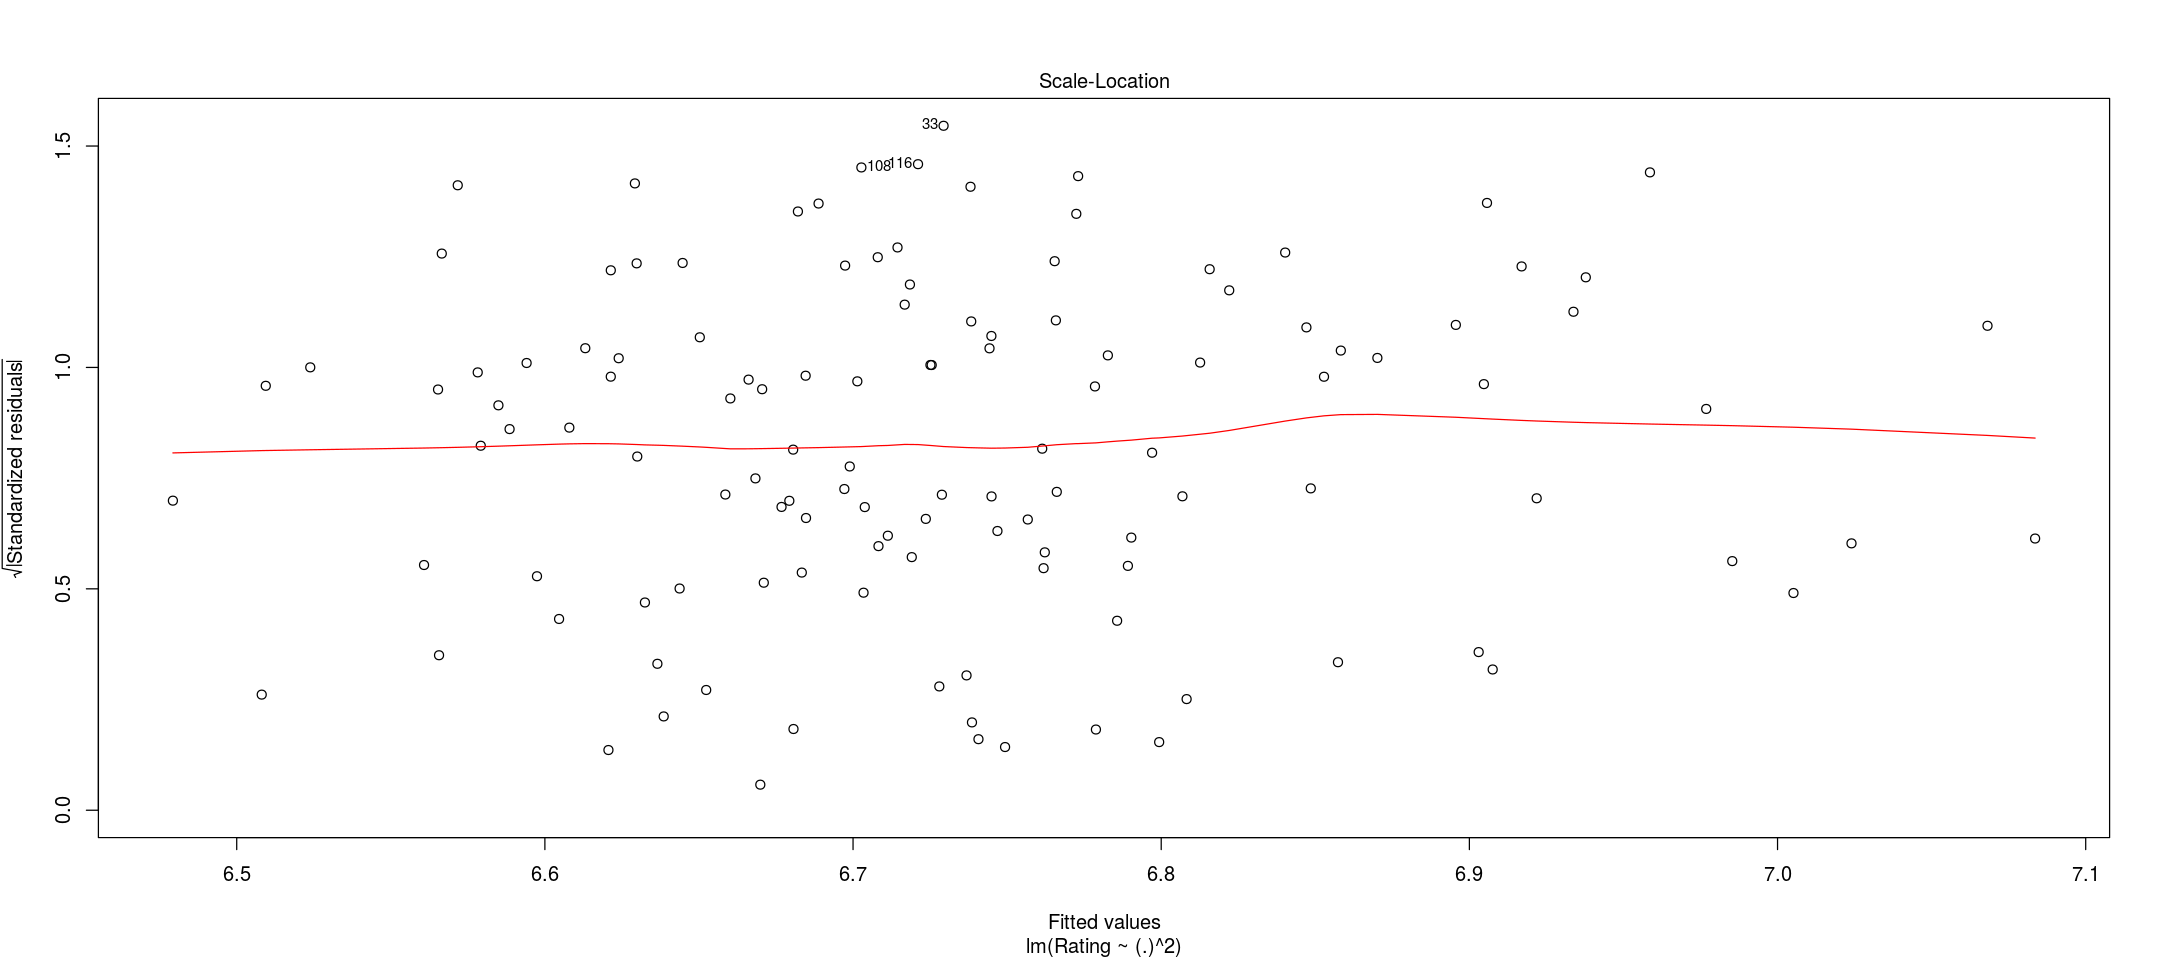

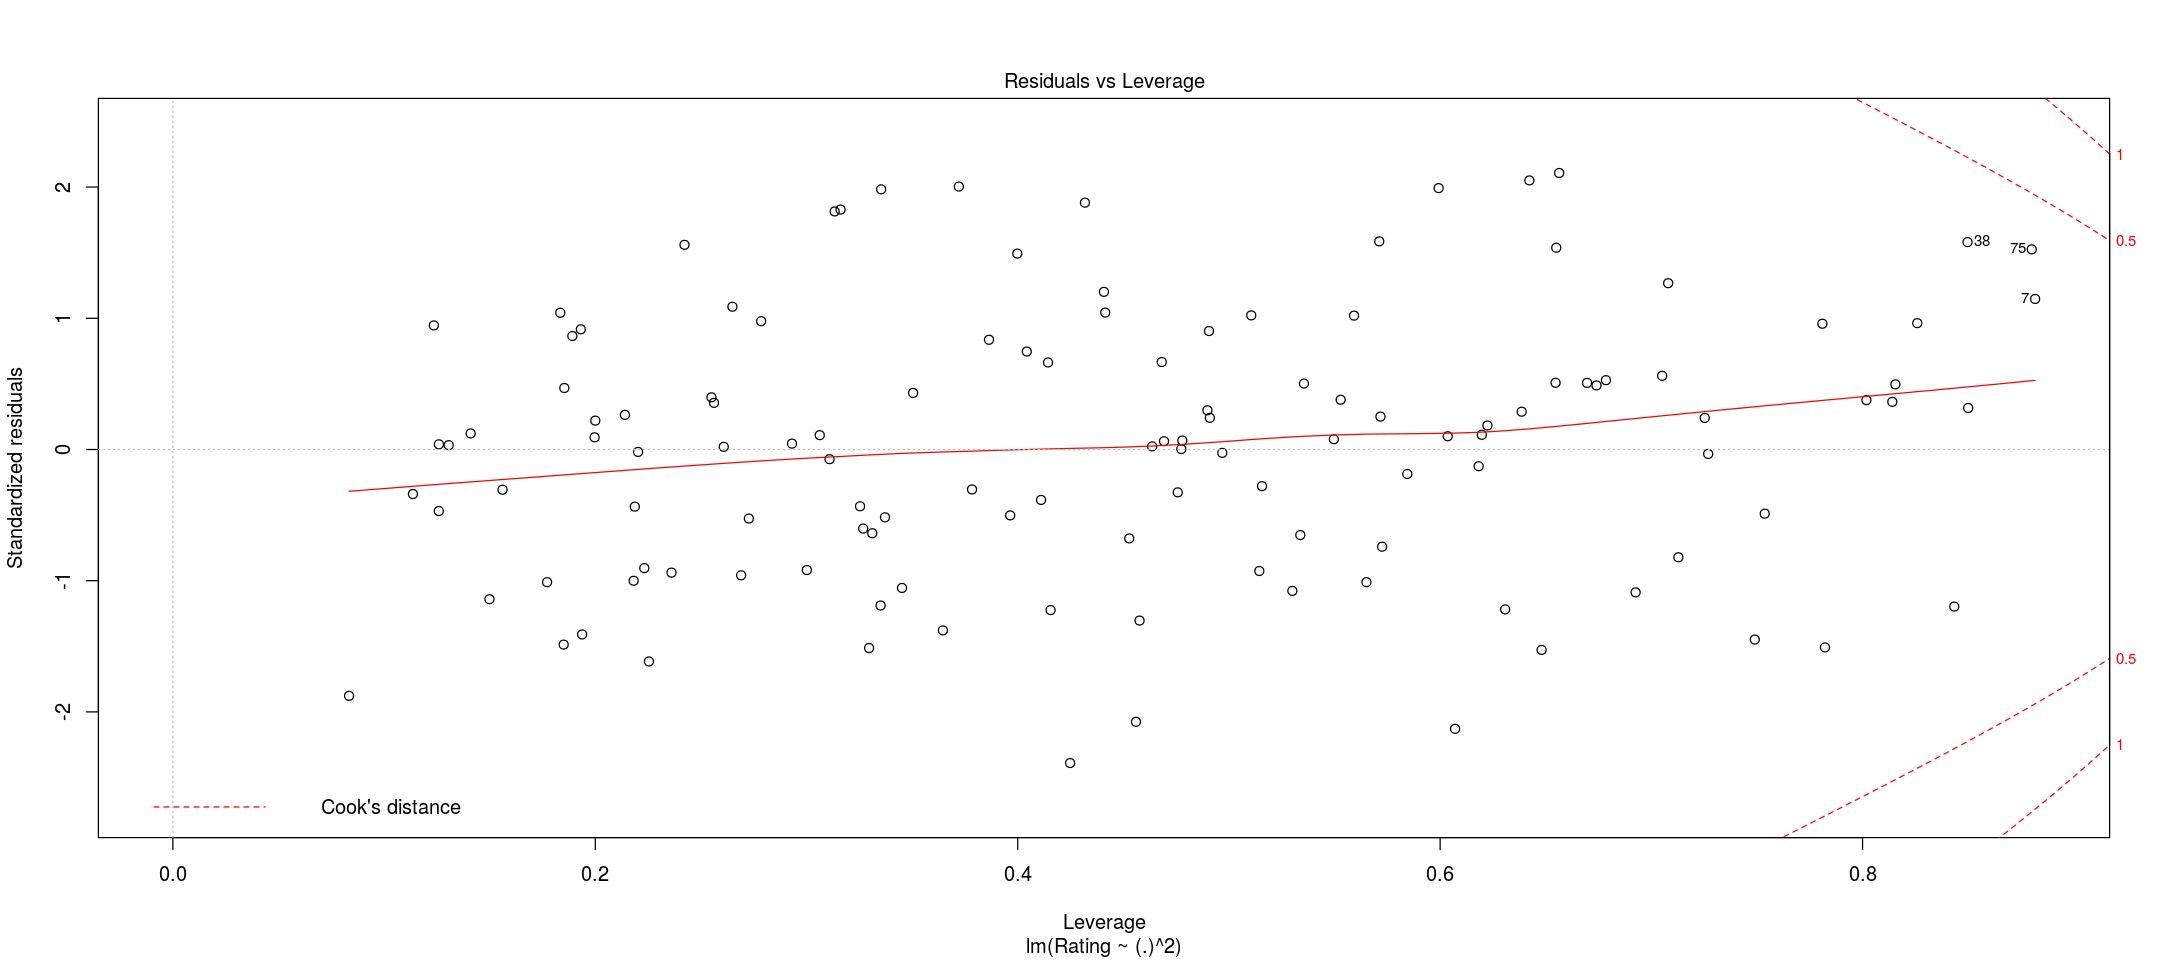

In [15]:
plot(reg_bic)

On voit que le graphe des résidus ne présente pas de forme particulière. De plus, le graphe quantile-quantile est plus ou moins aligné (quelques soucis sur les petits et grands quantiles).

On va refaire de la sélection de variables, mais pour chaque pays, et ainsi observer les variables vraiment influentes.

In [16]:
France = data[data_tot$Pays == "France",]
Allemagne = data[data_tot$Pays == "Allemagne",]
Italie = data[data_tot$Pays == "Italie",]
Espagne = data[data_tot$Pays == "Espagne",]
Argentine = data[data_tot$Pays == "Argentine",]
Angleterre = data[data_tot$Pays == "Angleterre",]

In [17]:
choix_France <- regsubsets(data_tot[data_tot$Pays=="France",]$Rating~., data=France,nbest=1, nvmax=10, method="seqrep")
choix_Allemagne <- regsubsets(data_tot[data_tot$Pays=="Allemagne",]$Rating~., data=Allemagne,nbest=1, nvmax=10, method="seqrep")
choix_Italie <- regsubsets(data_tot[data_tot$Pays=="Italie",]$Rating~., data=Italie,nbest=1, nvmax=10, method="seqrep")
choix_Espagne <- regsubsets(data_tot[data_tot$Pays=="Espagne",]$Rating~., data=Espagne,nbest=1, nvmax=10, method="seqrep")
choix_Argentine <- regsubsets(data_tot[data_tot$Pays=="Argentine",]$Rating~., data=Argentine, nbest=1, nvmax=10, method="seqrep")
choix_Angleterre <- regsubsets(data_tot[data_tot$Pays=="Angleterre",]$Rating~., data=Angleterre, nbest=1, nvmax=10, method="seqrep")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“63  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“55  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“61  linear dependencies found”


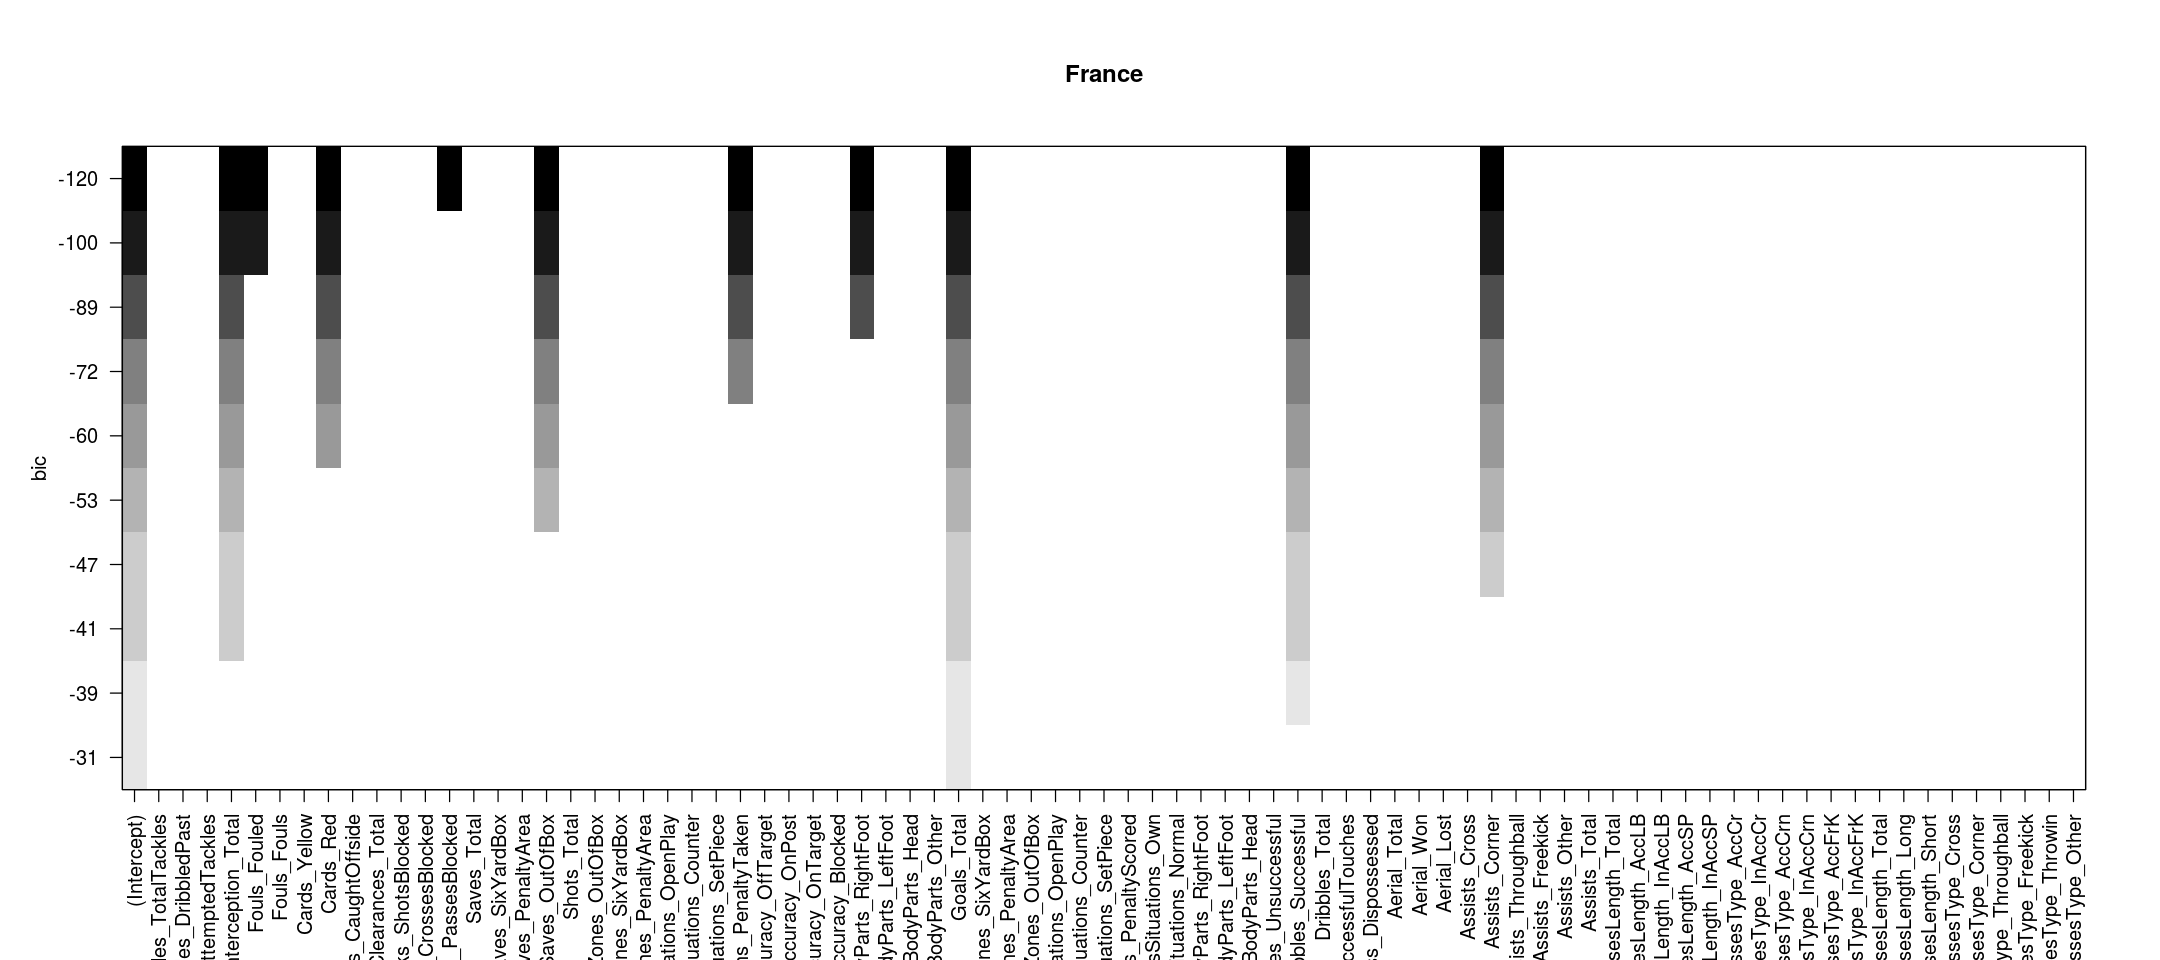

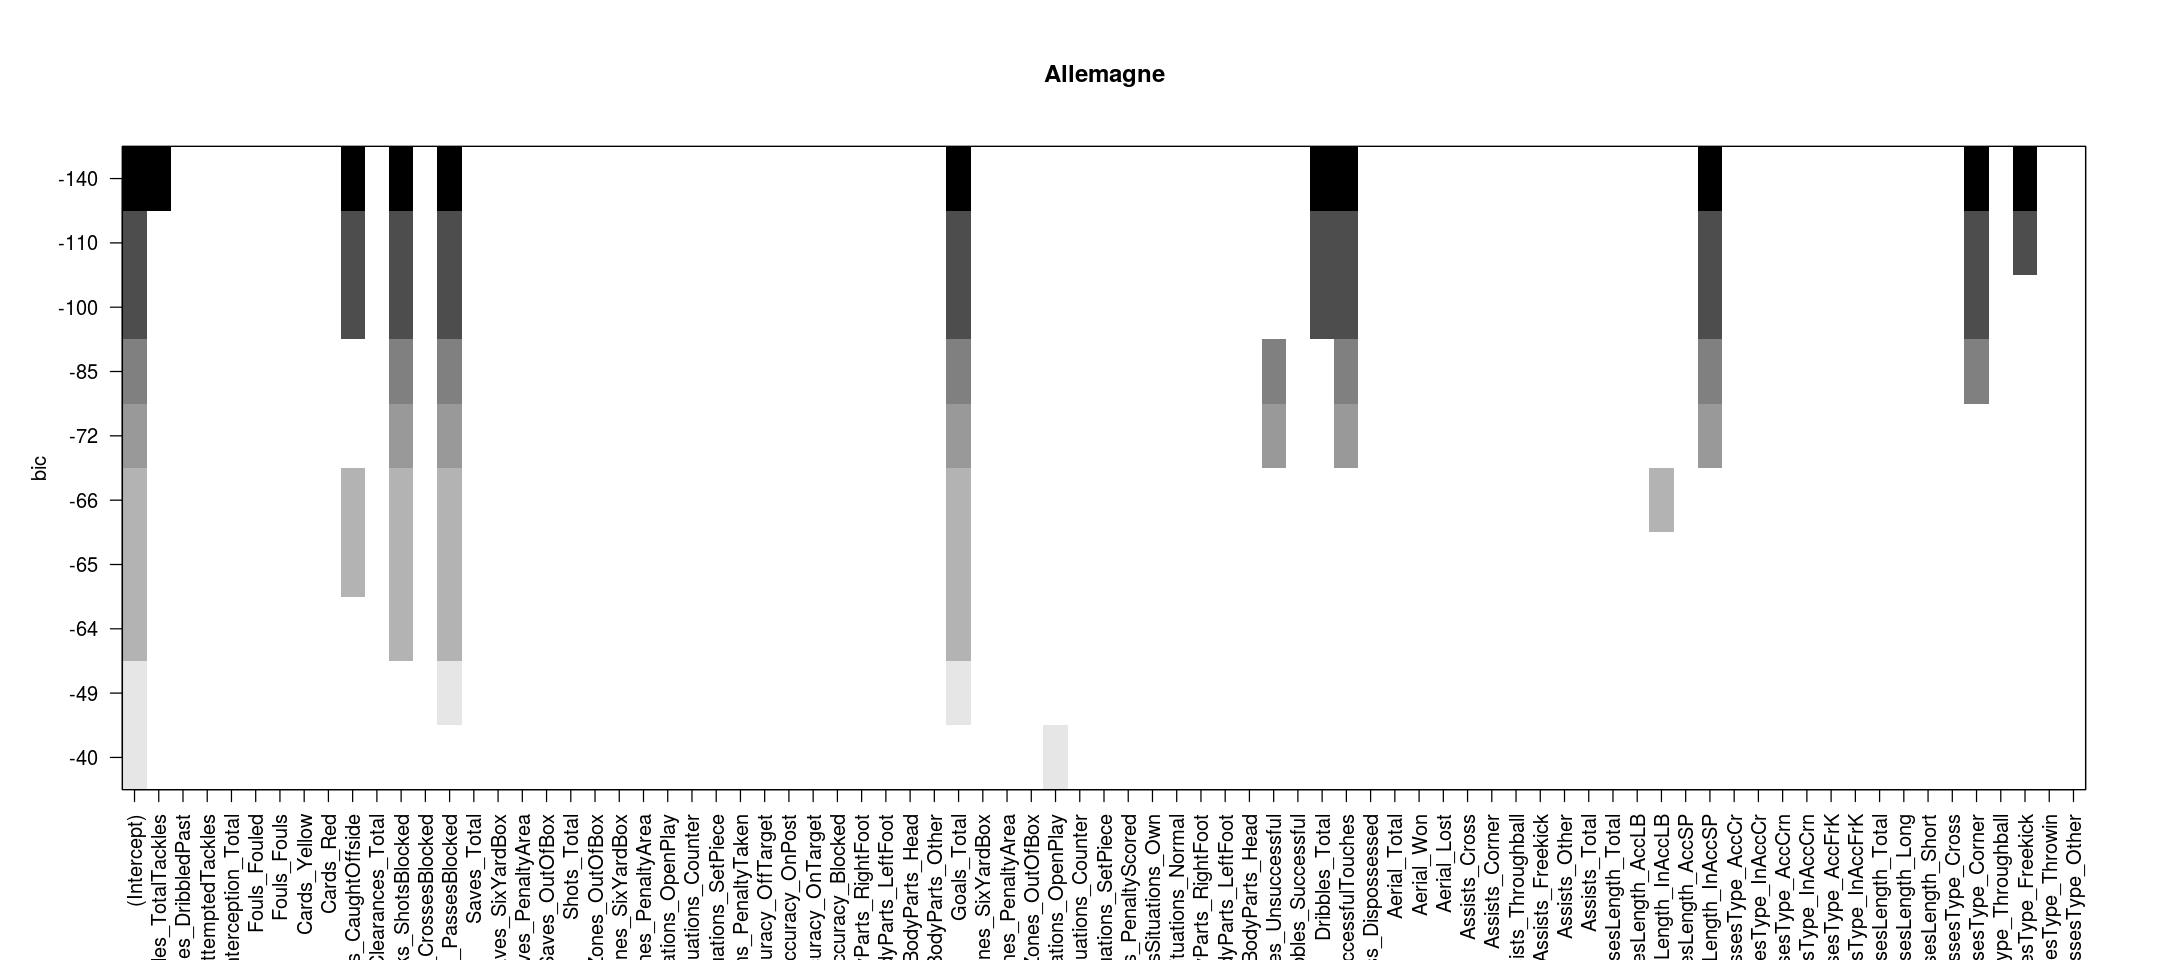

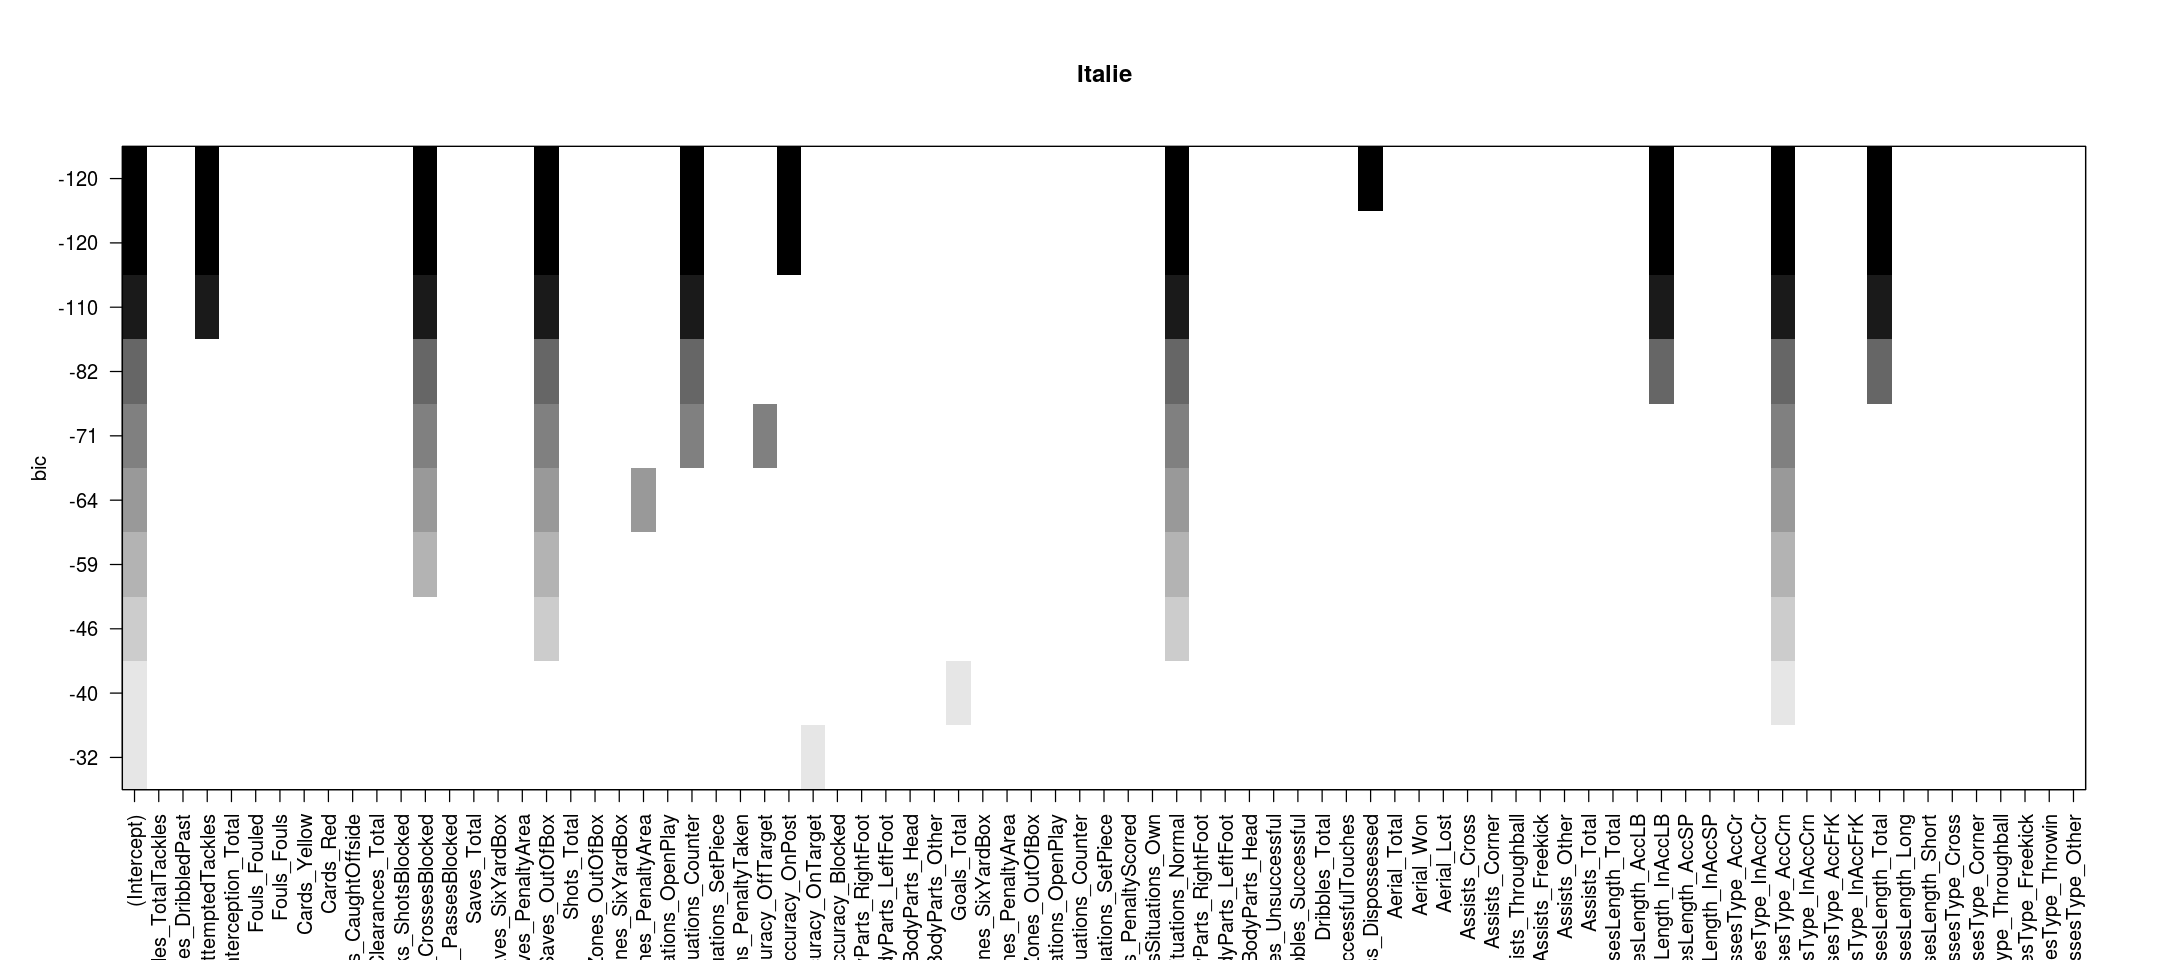

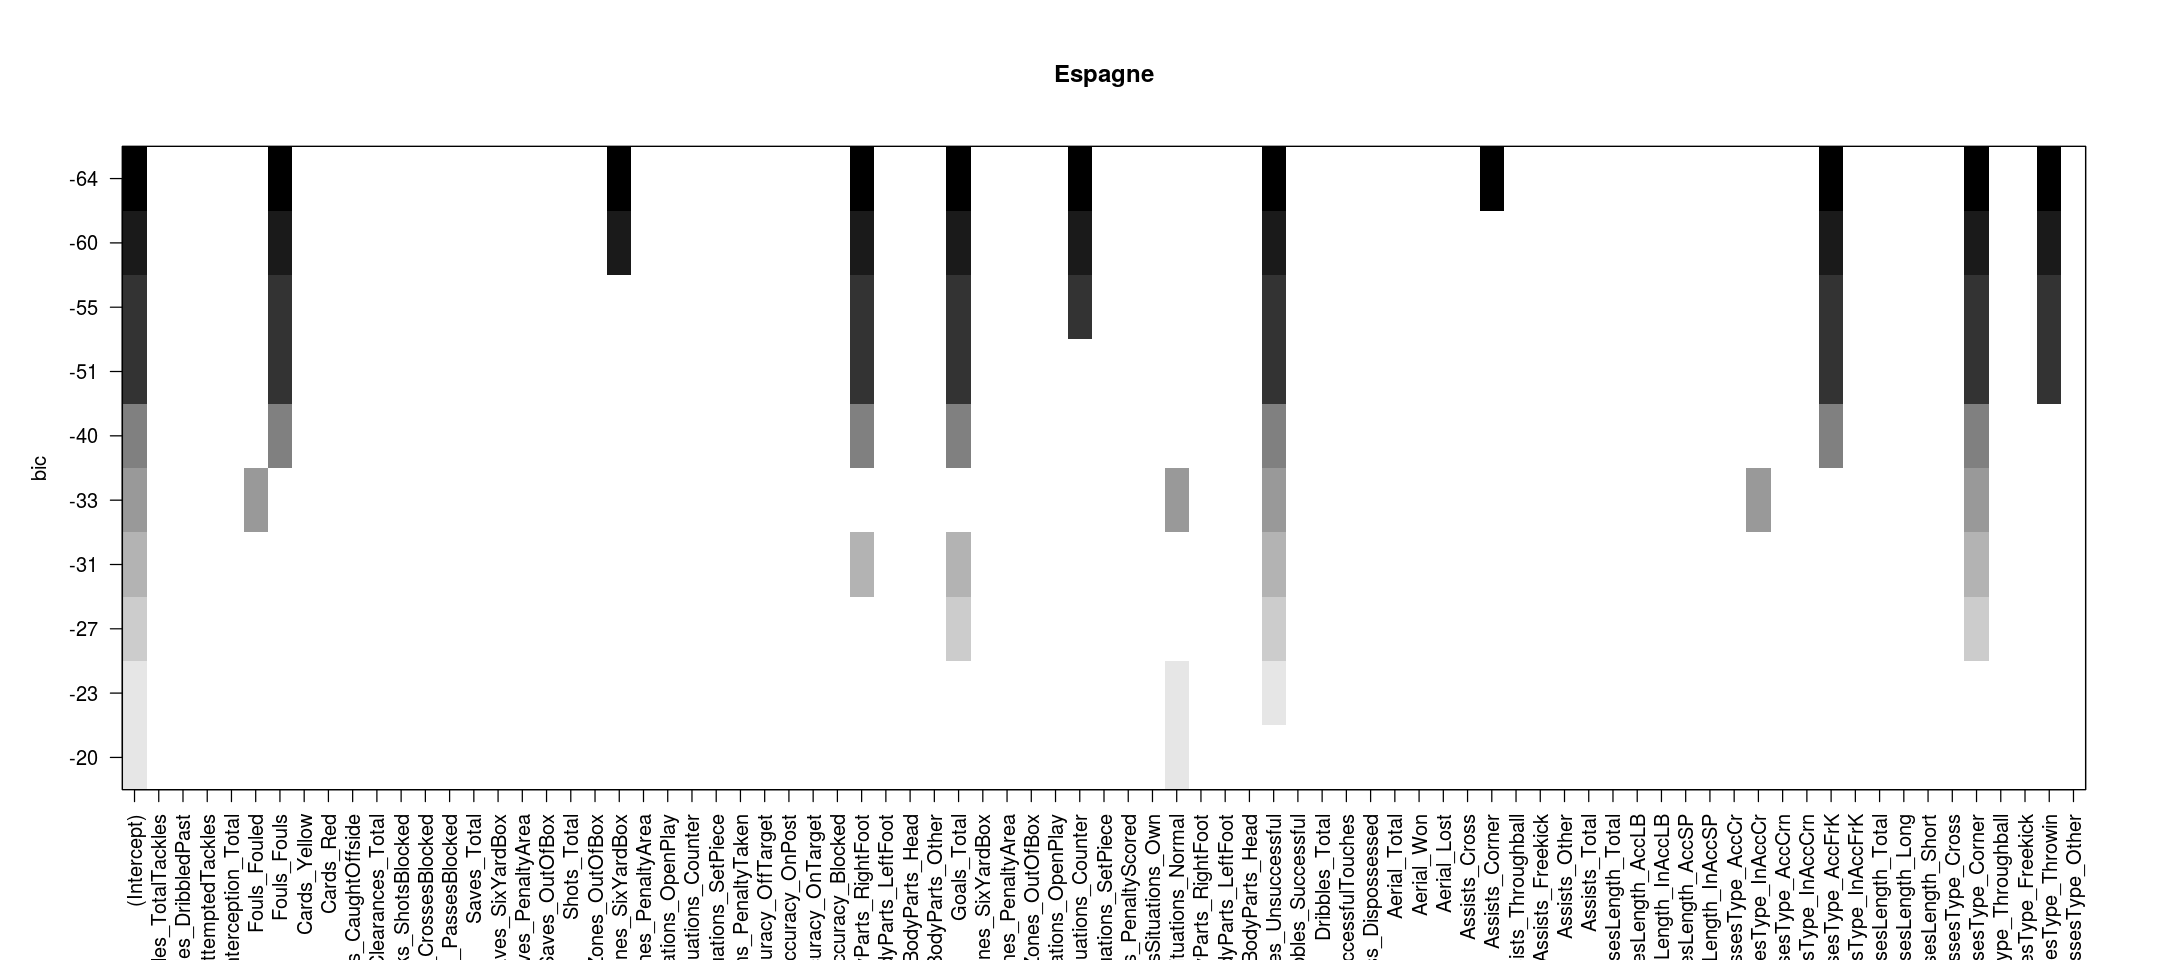

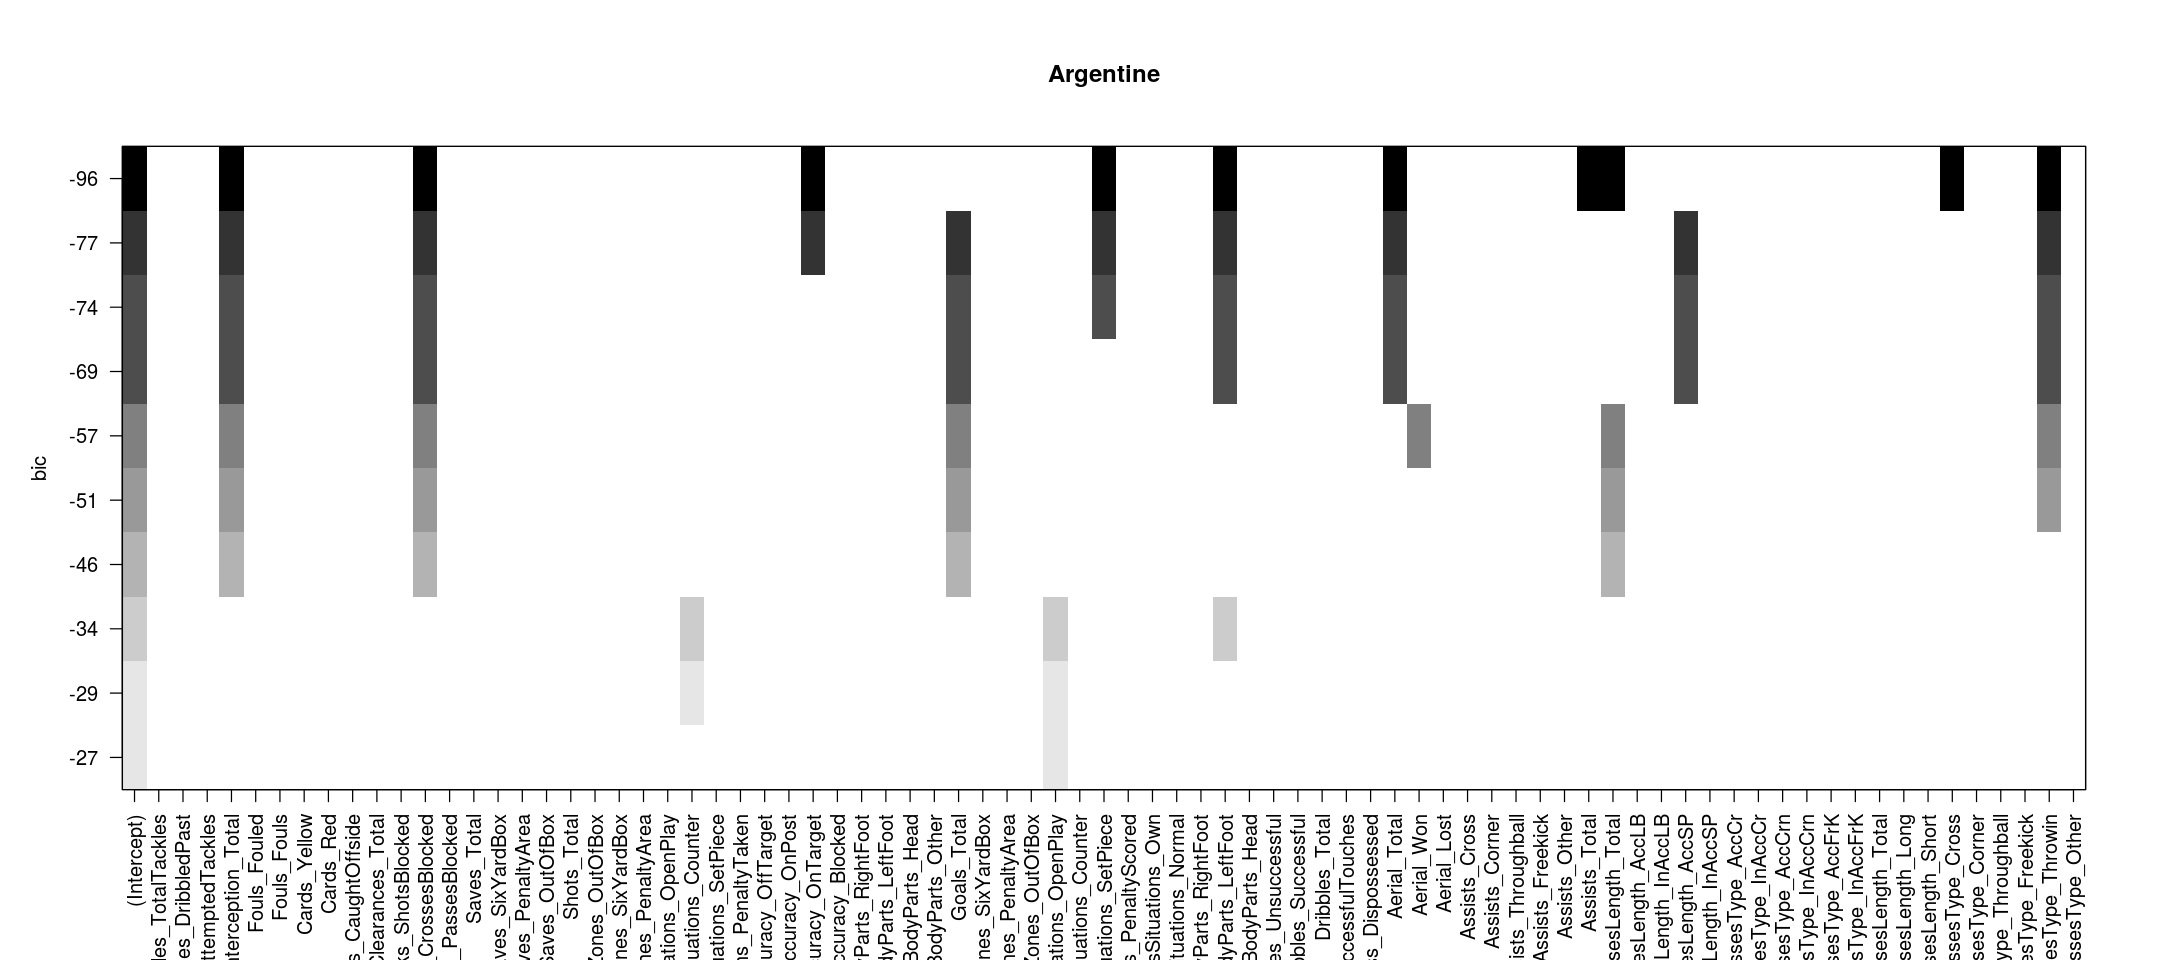

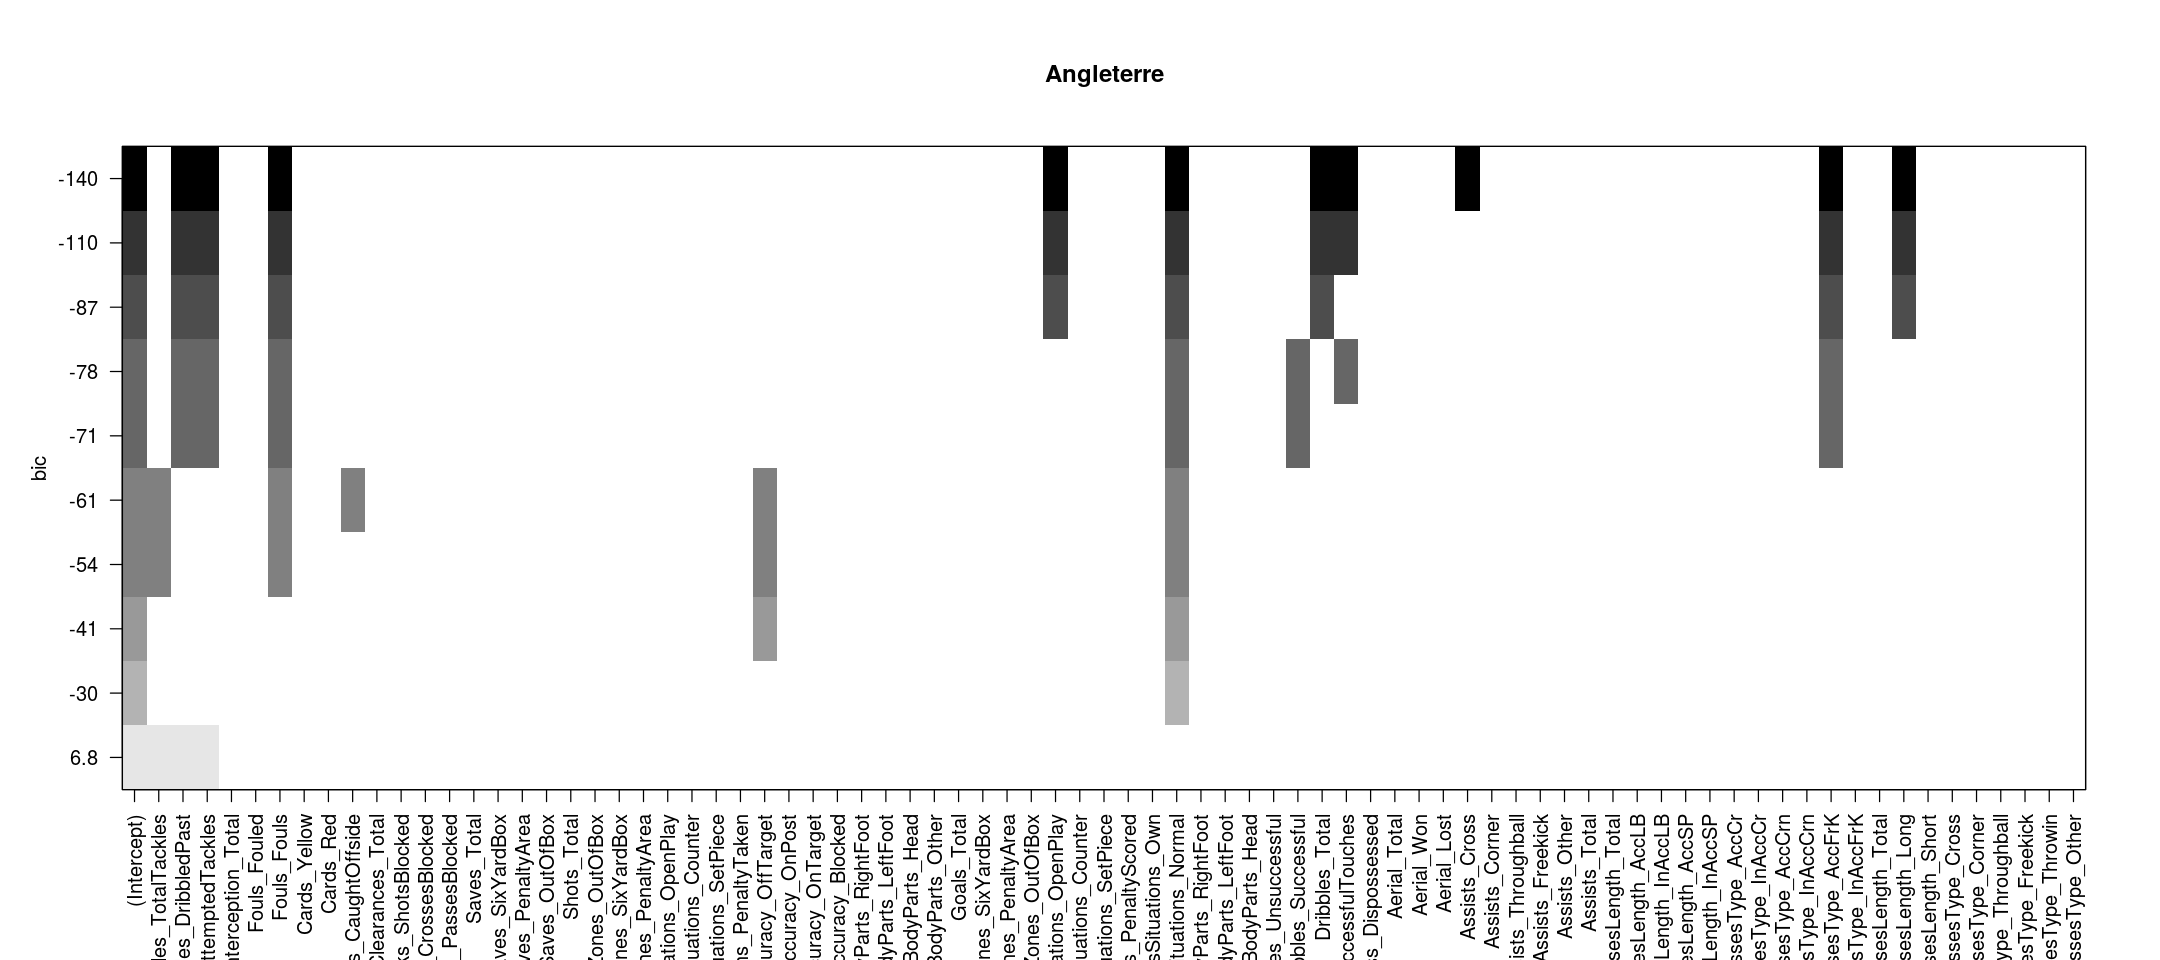

In [18]:
plot(choix_France,scale="bic", main = "France")
plot(choix_Allemagne,scale="bic", main = "Allemagne")
plot(choix_Italie,scale="bic", main = "Italie")
plot(choix_Espagne,scale="bic", main = "Espagne")
plot(choix_Argentine,scale="bic", main = "Argentine")
plot(choix_Angleterre,scale="bic", main = "Angleterre")

On voit que les variables retenues ne sont pas les mêmes d'un pays à l'autre. On va les afficher.

In [19]:
nb_min = which.min(summary(choix_France)$bic)
c_fr = coef(choix_France, nb_min)
c_fr

(Intercept)           Interception_Total 
                  6.13982139                   0.02379254 
                Fouls_Fouled                    Cards_Red 
                  0.00780852                  -0.59998996 
        Blocks_PassesBlocked               Saves_OutOfBox 
                  0.00953064                  -0.15869606 
ShotsSituations_PenaltyTaken     ShotsBodyParts_RightFoot 
                 -0.29921044                   0.01058761 
                 Goals_Total          Dribbles_Successful 
                  0.24884230                   0.01447643 
              Assists_Corner 
                 -0.68520084

In [20]:
nb_min = which.min(summary(choix_Allemagne)$bic)
c_al = coef(choix_Allemagne, nb_min)
c_al

(Intercept)              Tackles_TotalTackles 
                      6.399091359                      -0.003078383 
           OffSides_CaughtOffside               Blocks_ShotsBlocked 
                      0.019588687                      -0.100248996 
             Blocks_PassesBlocked                       Goals_Total 
                      0.031203035                       0.254083488 
                   Dribbles_Total PossesionLoss_UnsuccessfulTouches 
                     -0.010802187                       0.032990789 
             PassesLength_InAccSP              KeyPassesType_Corner 
                     -0.006534990                       0.042078310 
           KeyPassesType_Freekick 
                      0.031796647

In [21]:
nb_min = which.min(summary(choix_Italie)$bic)
c_it = coef(choix_Italie, nb_min)
c_it

(Intercept) Tackles_TotalAttemptedTackles 
                  6.121935479                  -0.006314372 
        Blocks_CrossesBlocked                Saves_OutOfBox 
                  0.082943752                  -0.107609112 
      shotsSituations_Counter          ShotsAccuracy_OnPost 
                 -0.162027230                   0.047045670 
       GoalsSituations_Normal    PossesionLoss_Dispossessed 
                  0.220527721                   0.002141677 
         PassesLength_InAccLB             PassesType_AccCrn 
                  0.004099711                   0.074177992 
        KeyPassesLength_Total 
                  0.015484516

In [22]:
nb_min = which.min(summary(choix_Espagne)$bic)
c_esp = coef(choix_Espagne, nb_min)
c_esp 

(Intercept)              Fouls_Fouls    ShotsZones_SixYardBox 
              5.30226068               0.06033281              -0.04943554 
ShotsBodyParts_RightFoot              Goals_Total  GoalsSituations_Counter 
             -0.09519753               0.64617737               0.31190463 
   Dribbles_Unsuccessful           Assists_Corner        PassesType_AccFrK 
             -0.07732713               0.16209235               0.04389401 
    KeyPassesType_Corner    KeyPassesType_Throwin 
              0.44535170               0.51258696

In [23]:
nb_min = which.min(summary(choix_Argentine)$bic)
c_arg = coef(choix_Argentine, nb_min)
c_arg

(Intercept)       Interception_Total    Blocks_CrossesBlocked 
            5.1672585707             0.0155505147             0.1189540982 
  ShotsAccuracy_OnTarget GoalsSituations_SetPiece  GoalsBodyParts_LeftFoot 
            0.0553495653             0.1588745808             0.2386931484 
            Aerial_Total            Assists_Total       PassesLength_Total 
            0.0062889447             0.1182705930             0.0009981764 
     KeyPassesType_Cross    KeyPassesType_Throwin 
            0.0280459865             0.3306468666

In [24]:
nb_min = which.min(summary(choix_Angleterre)$bic)
c_ang = coef(choix_Angleterre, nb_min)
c_ang

(Intercept)              Tackles_DribbledPast 
                       6.49408040                       -0.05867852 
    Tackles_TotalAttemptedTackles                       Fouls_Fouls 
                       0.02742058                       -0.02856630 
         GoalsSituations_OpenPlay            GoalsSituations_Normal 
                       0.10241306                        0.23551565 
                   Dribbles_Total PossesionLoss_UnsuccessfulTouches 
                       0.01154699                       -0.01034876 
                    Assists_Cross                 PassesType_AccFrK 
                       0.06008585                       -0.01667785 
             KeyPassesLength_Long 
                       0.03663127

In [25]:
for (i in 1:nb.variables){
    for (j in 1:(length(names(c_fr))-1)){
        if (choix_France$xnames[i+1] == names(c_fr)[j+1]){
            df.variables.pays$France[i] = round(c_fr[j+1],3)
        }
        else if (choix_Allemagne$xnames[i+1] == names(c_al)[j+1]){
            df.variables.pays$Allemagne[i] = round(c_fr[j+1],3)
        }
        else if (choix_Angleterre$xnames[i+1] == names(c_ang)[j+1]){
            df.variables.pays$Angleterre[i] = round(c_ang[j+1],3)
        }
        else if (choix_Argentine$xnames[i+1] == names(c_arg)[j+1]){
            df.variables.pays$Argentine[i] = round(c_arg[j+1],3)
        }
        else if (choix_Italie$xnames[i+1] == names(c_it)[j+1]){
            df.variables.pays$Italie[i] = round(c_it[j+1],3)
        }
        else if (choix_Espagne$xnames[i+1] == names(c_esp)[j+1]){
            df.variables.pays$Espagne[i] = round(c_esp[j+1],3)
        }
    } 
}

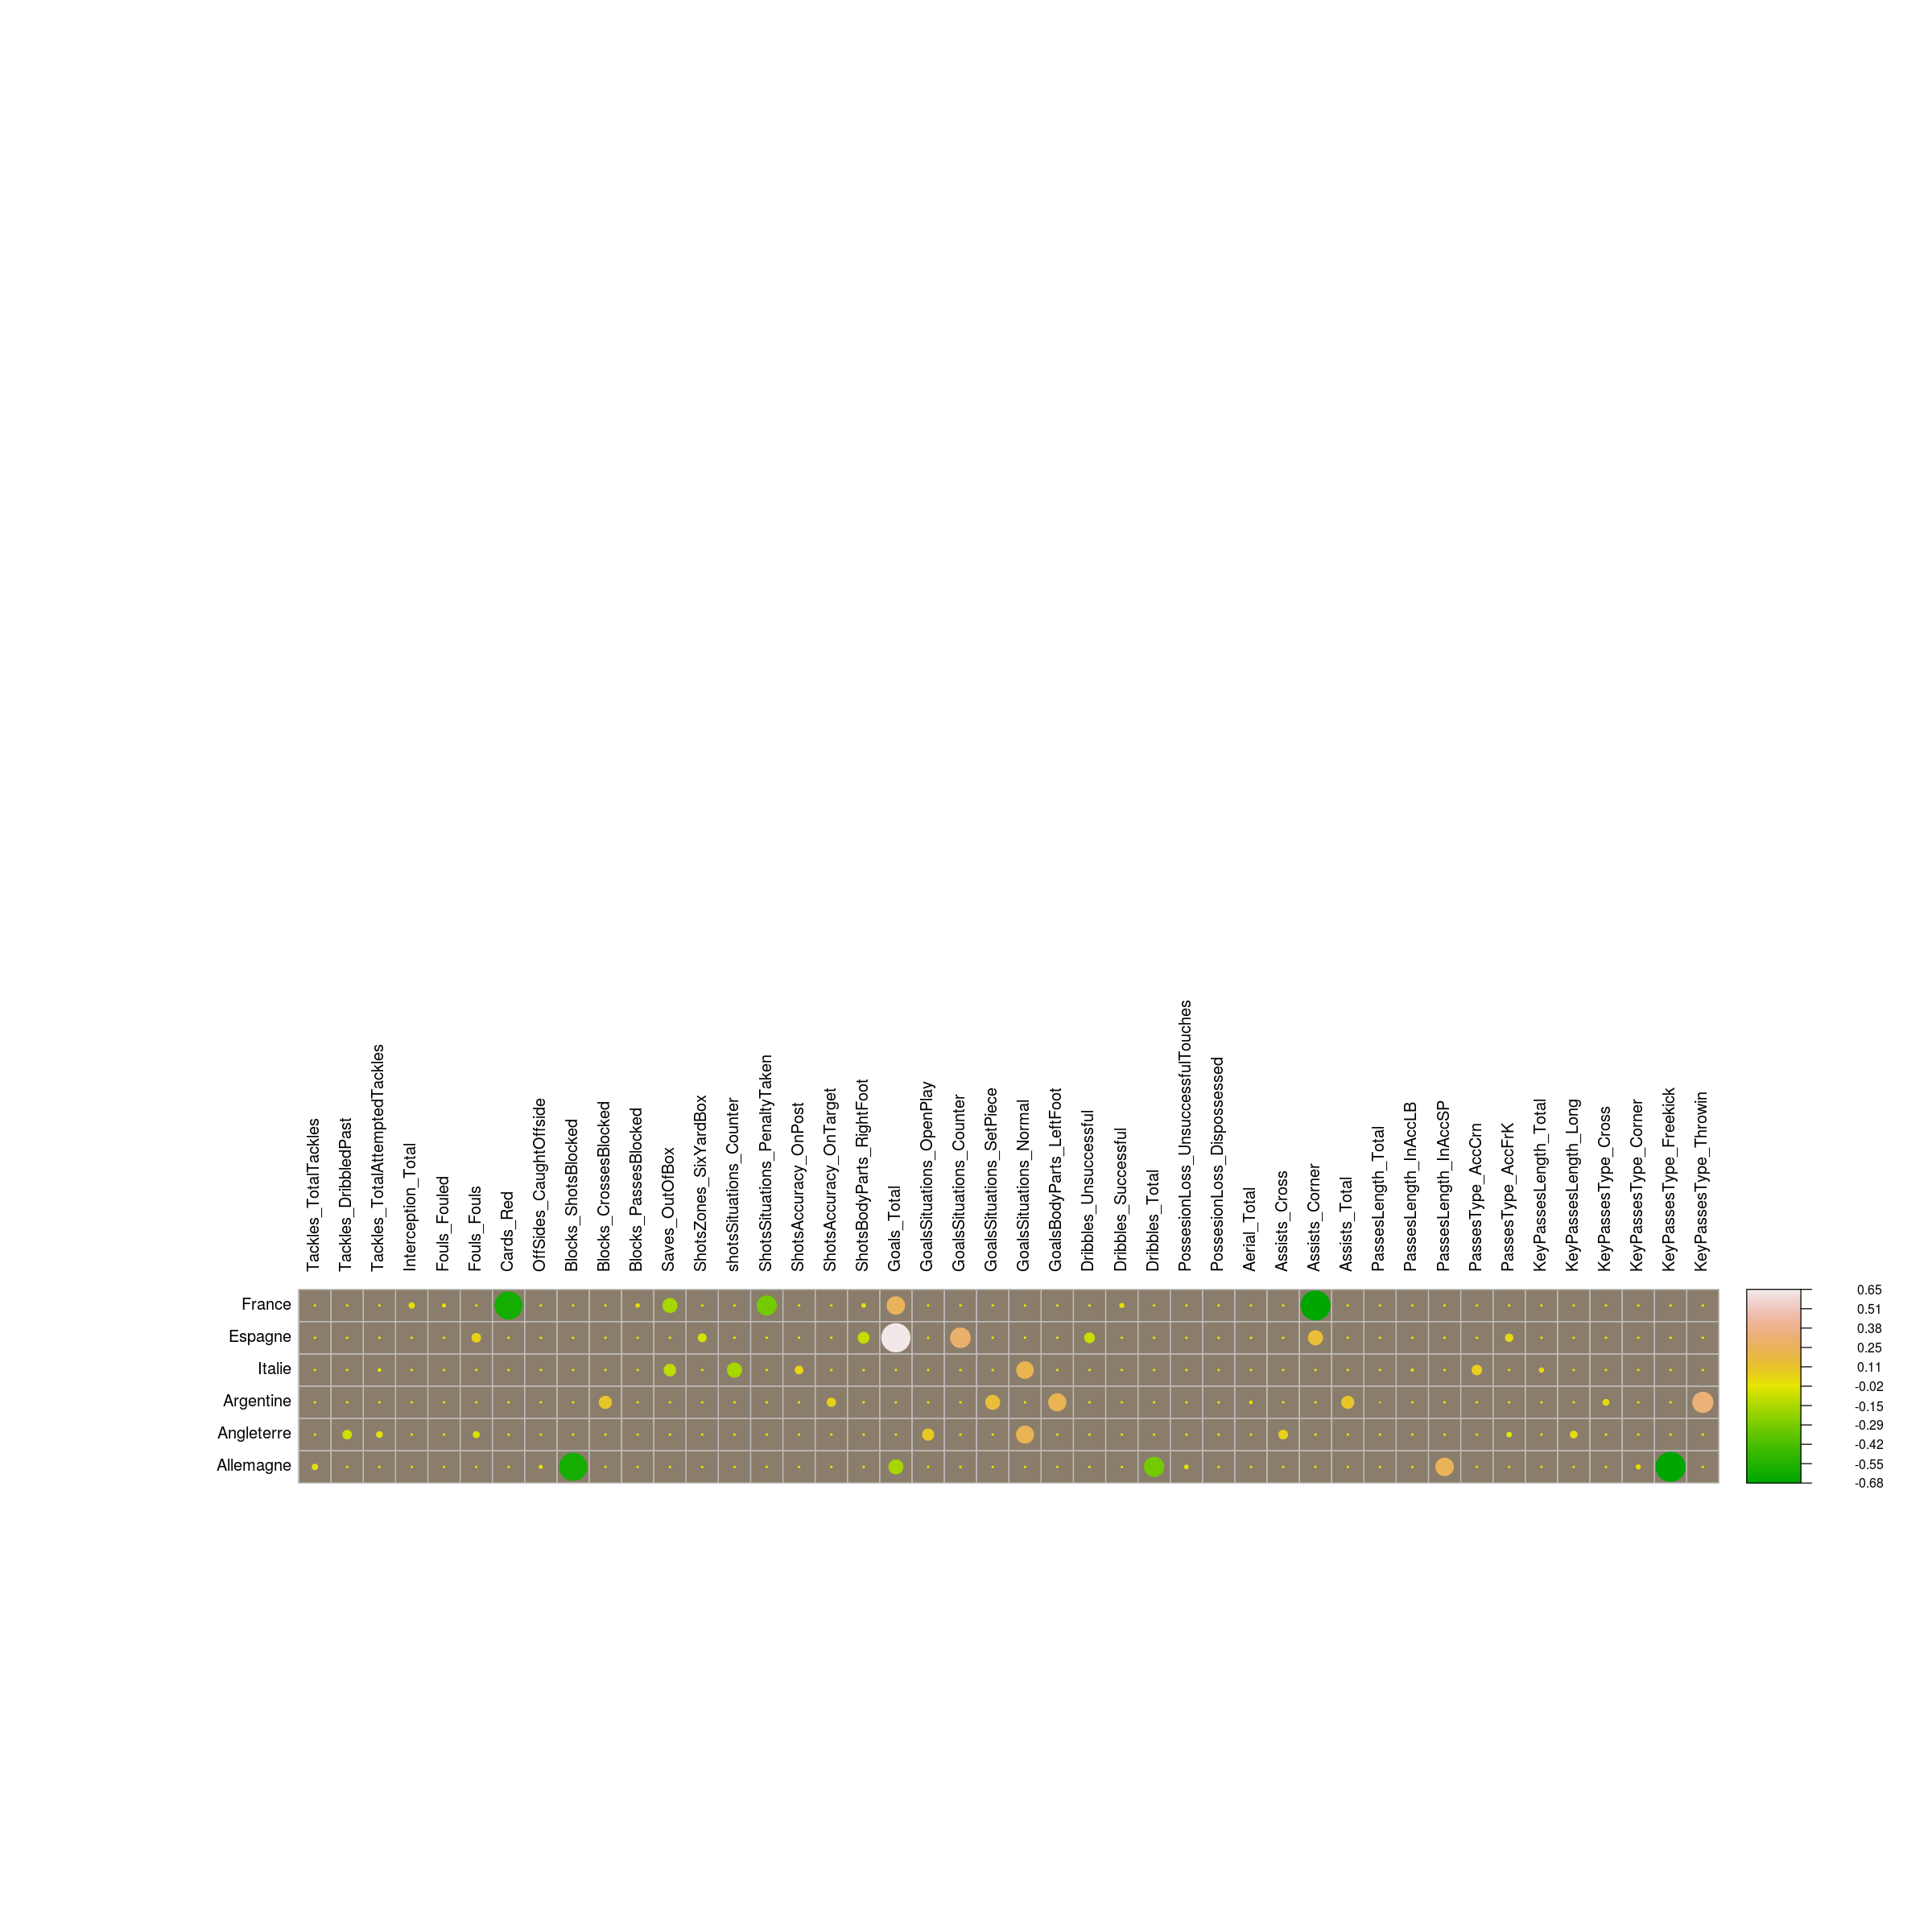

In [26]:
df.pays.sans_zeros = df.variables.pays[rowSums(df.variables.pays[,2:7]^2) > 0, ]
mat.pays = data.matrix(df.pays.sans_zeros[,2:7])
rownames(mat.pays) = df.pays.sans_zeros$Noms
options(repr.plot.width=20, repr.plot.height=20)
corrplot(t(mat.pays), is.corr = FALSE, method = "circle", tl.col = 1, bg = "bisque4", col = terrain.colors(100))

On remarque que c'est seulement en France, Allemagne et Espagne que la variable `Goals_Total` est sélectionnée.

# Regression LASSO

alpha=1 is the lasso penalty, and alpha=0 the ridge penalty

In [27]:
m_lasso = glmnet(as.matrix(data_but), data_tot$Rating, alpha = 1, nlambda = 100)

68 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.9034877033
Tackles_TotalTackles               0.0090340856
Tackles_DribbledPast               .           
Tackles_TotalAttemptedTackles      .           
Interception_Total                 0.0019051963
Fouls_Fouled                       .           
Fouls_Fouls                        .           
Cards_Yellow                       .           
Cards_Red                         -0.0513164175
OffSides_CaughtOffside             .           
Clearances_Total                   .           
Blocks_ShotsBlocked                .           
Blocks_CrossesBlocked              0.0201508548
Blocks_PassesBlocked               0.0003566137
Saves_Total                       -0.0177674923
Saves_SixYardBox                  -0.0346960819
Saves_PenaltyArea                  .           
Saves_OutOfBox                     .           
Shots_Total                        .          

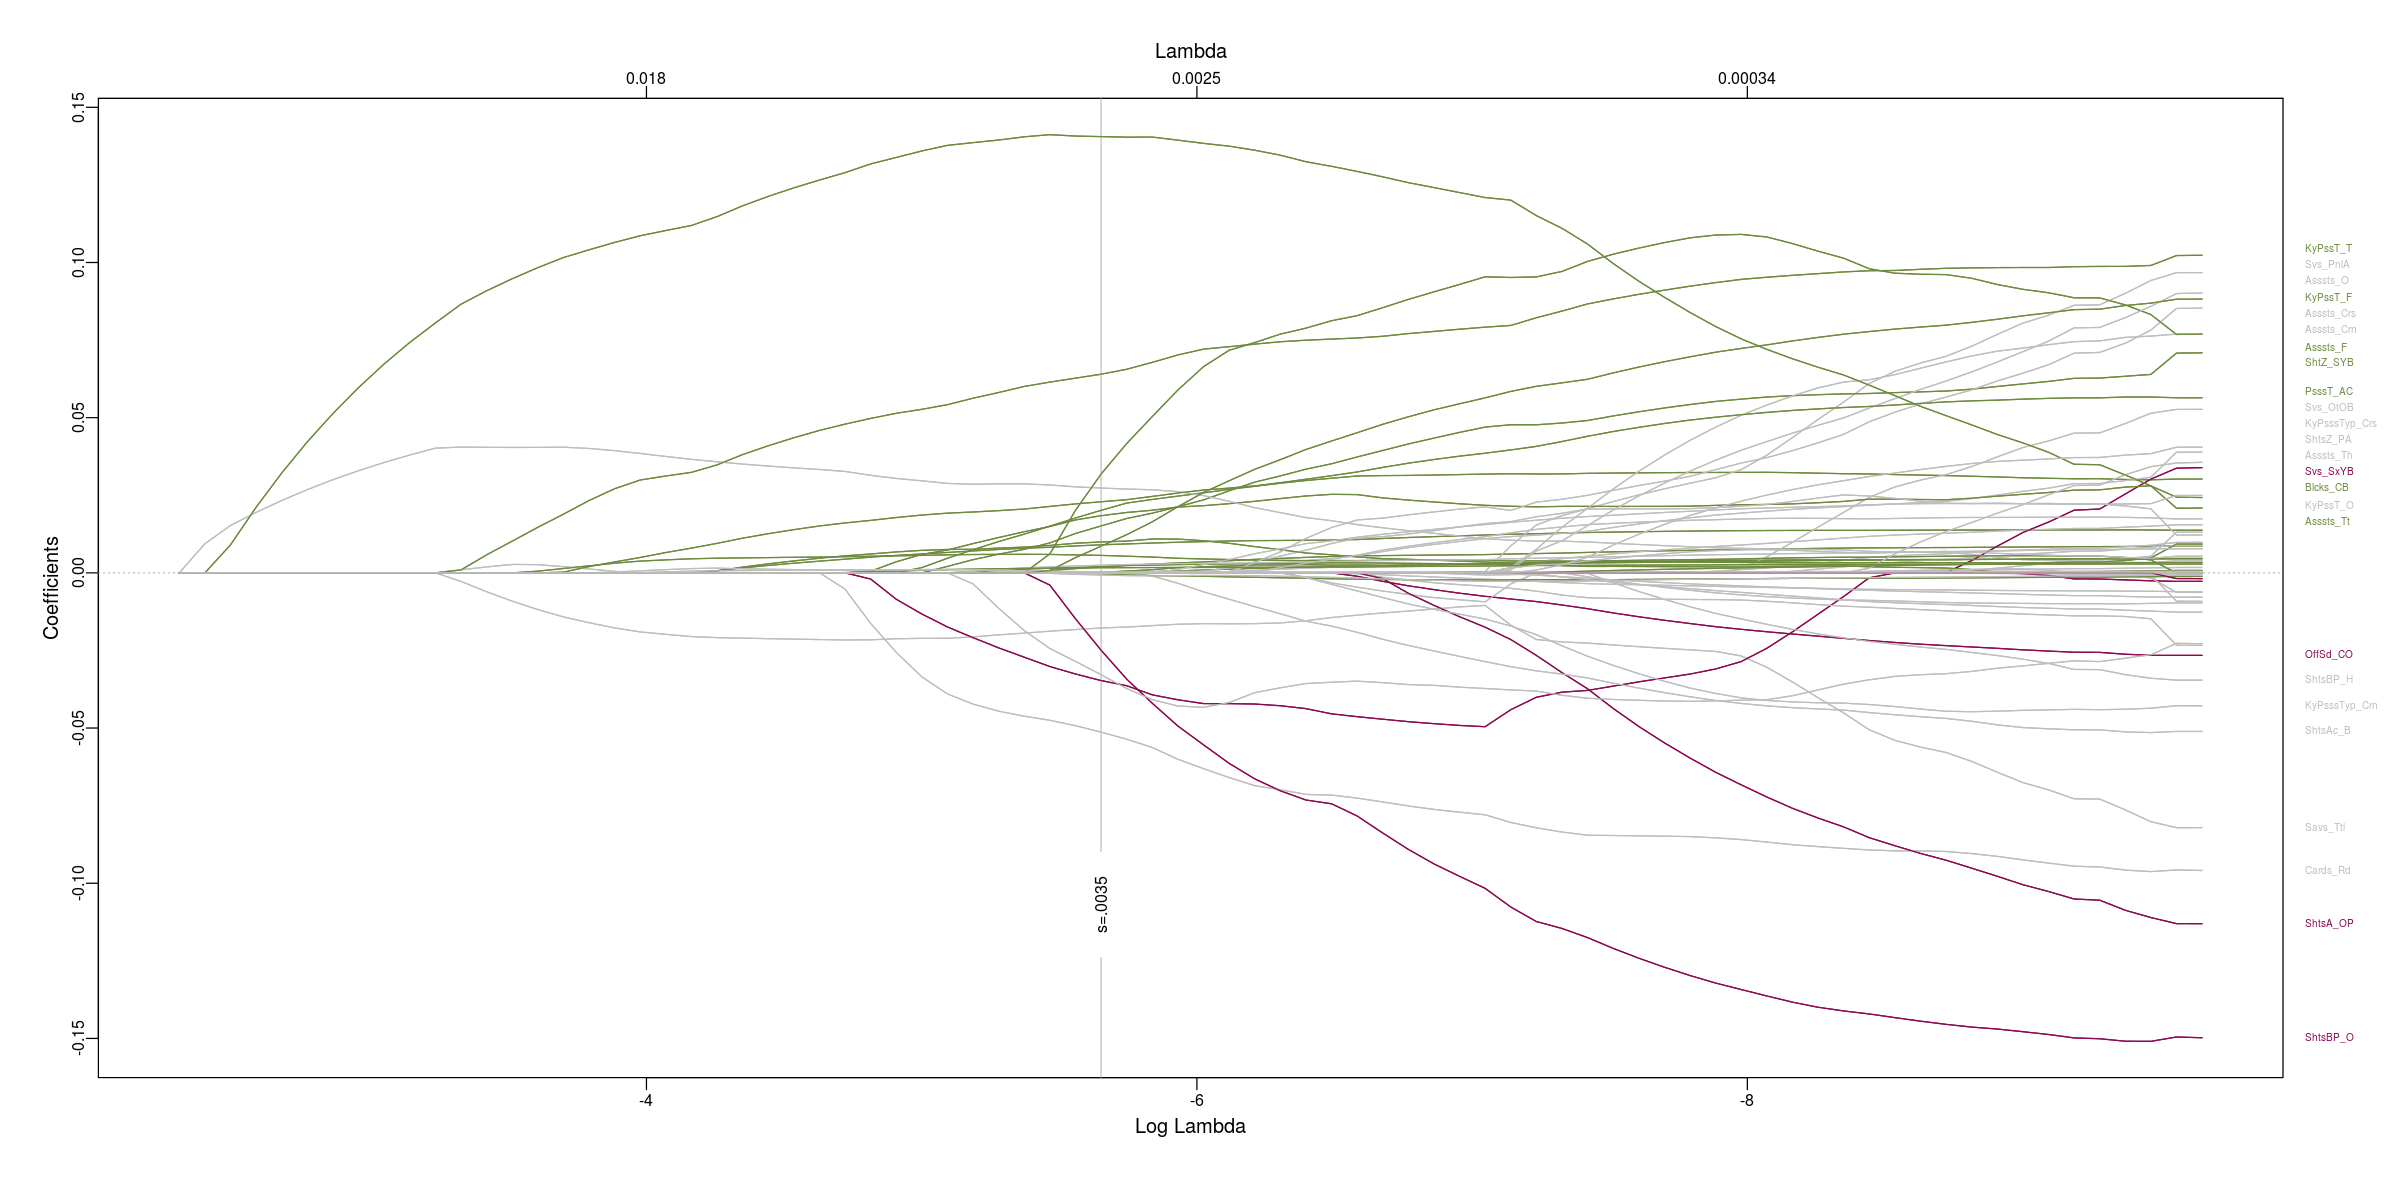

In [43]:
#mod <- glmnet(as.matrix(mtcars[-1]), mtcars[,1]) #from stephen's code above

cvfit<-cv.glmnet(as.matrix(data_but),data_tot$Rating)

glmcoef<-coef(m_lasso,cvfit$lambda.min)
coef.increase<-dimnames(glmcoef[glmcoef[,1]>0,0])[[1]]
coef.decrease<-dimnames(glmcoef[glmcoef[,1]<0,0])[[1]]

#get ordered list of variables as they appear at smallest lambda
allnames<-names(coef(m_lasso)[,
    ncol(coef(m_lasso))][order(coef(m_lasso)[,
    ncol(coef(m_lasso))],decreasing=TRUE)])

#remove intercept
allnames<-setdiff(allnames,allnames[grep("Intercept",allnames)])

#assign colors
cols<-rep("gray",length(allnames))
cols[allnames %in% coef.increase]<-"darkolivegreen4"      # higher mpg is good
cols[allnames %in% coef.decrease]<-"deeppink4"        # lower mpg is not

options(repr.plot.width=20, repr.plot.height=10)
library(plotmo)
plot_glmnet(m_lasso,label=25,s=cvfit$lambda.min,col=cols, cex = 67)

#if you don't believe hp or am are non-zero look at glmcoef
glmcoef

In [32]:
help("plot_glmnet")

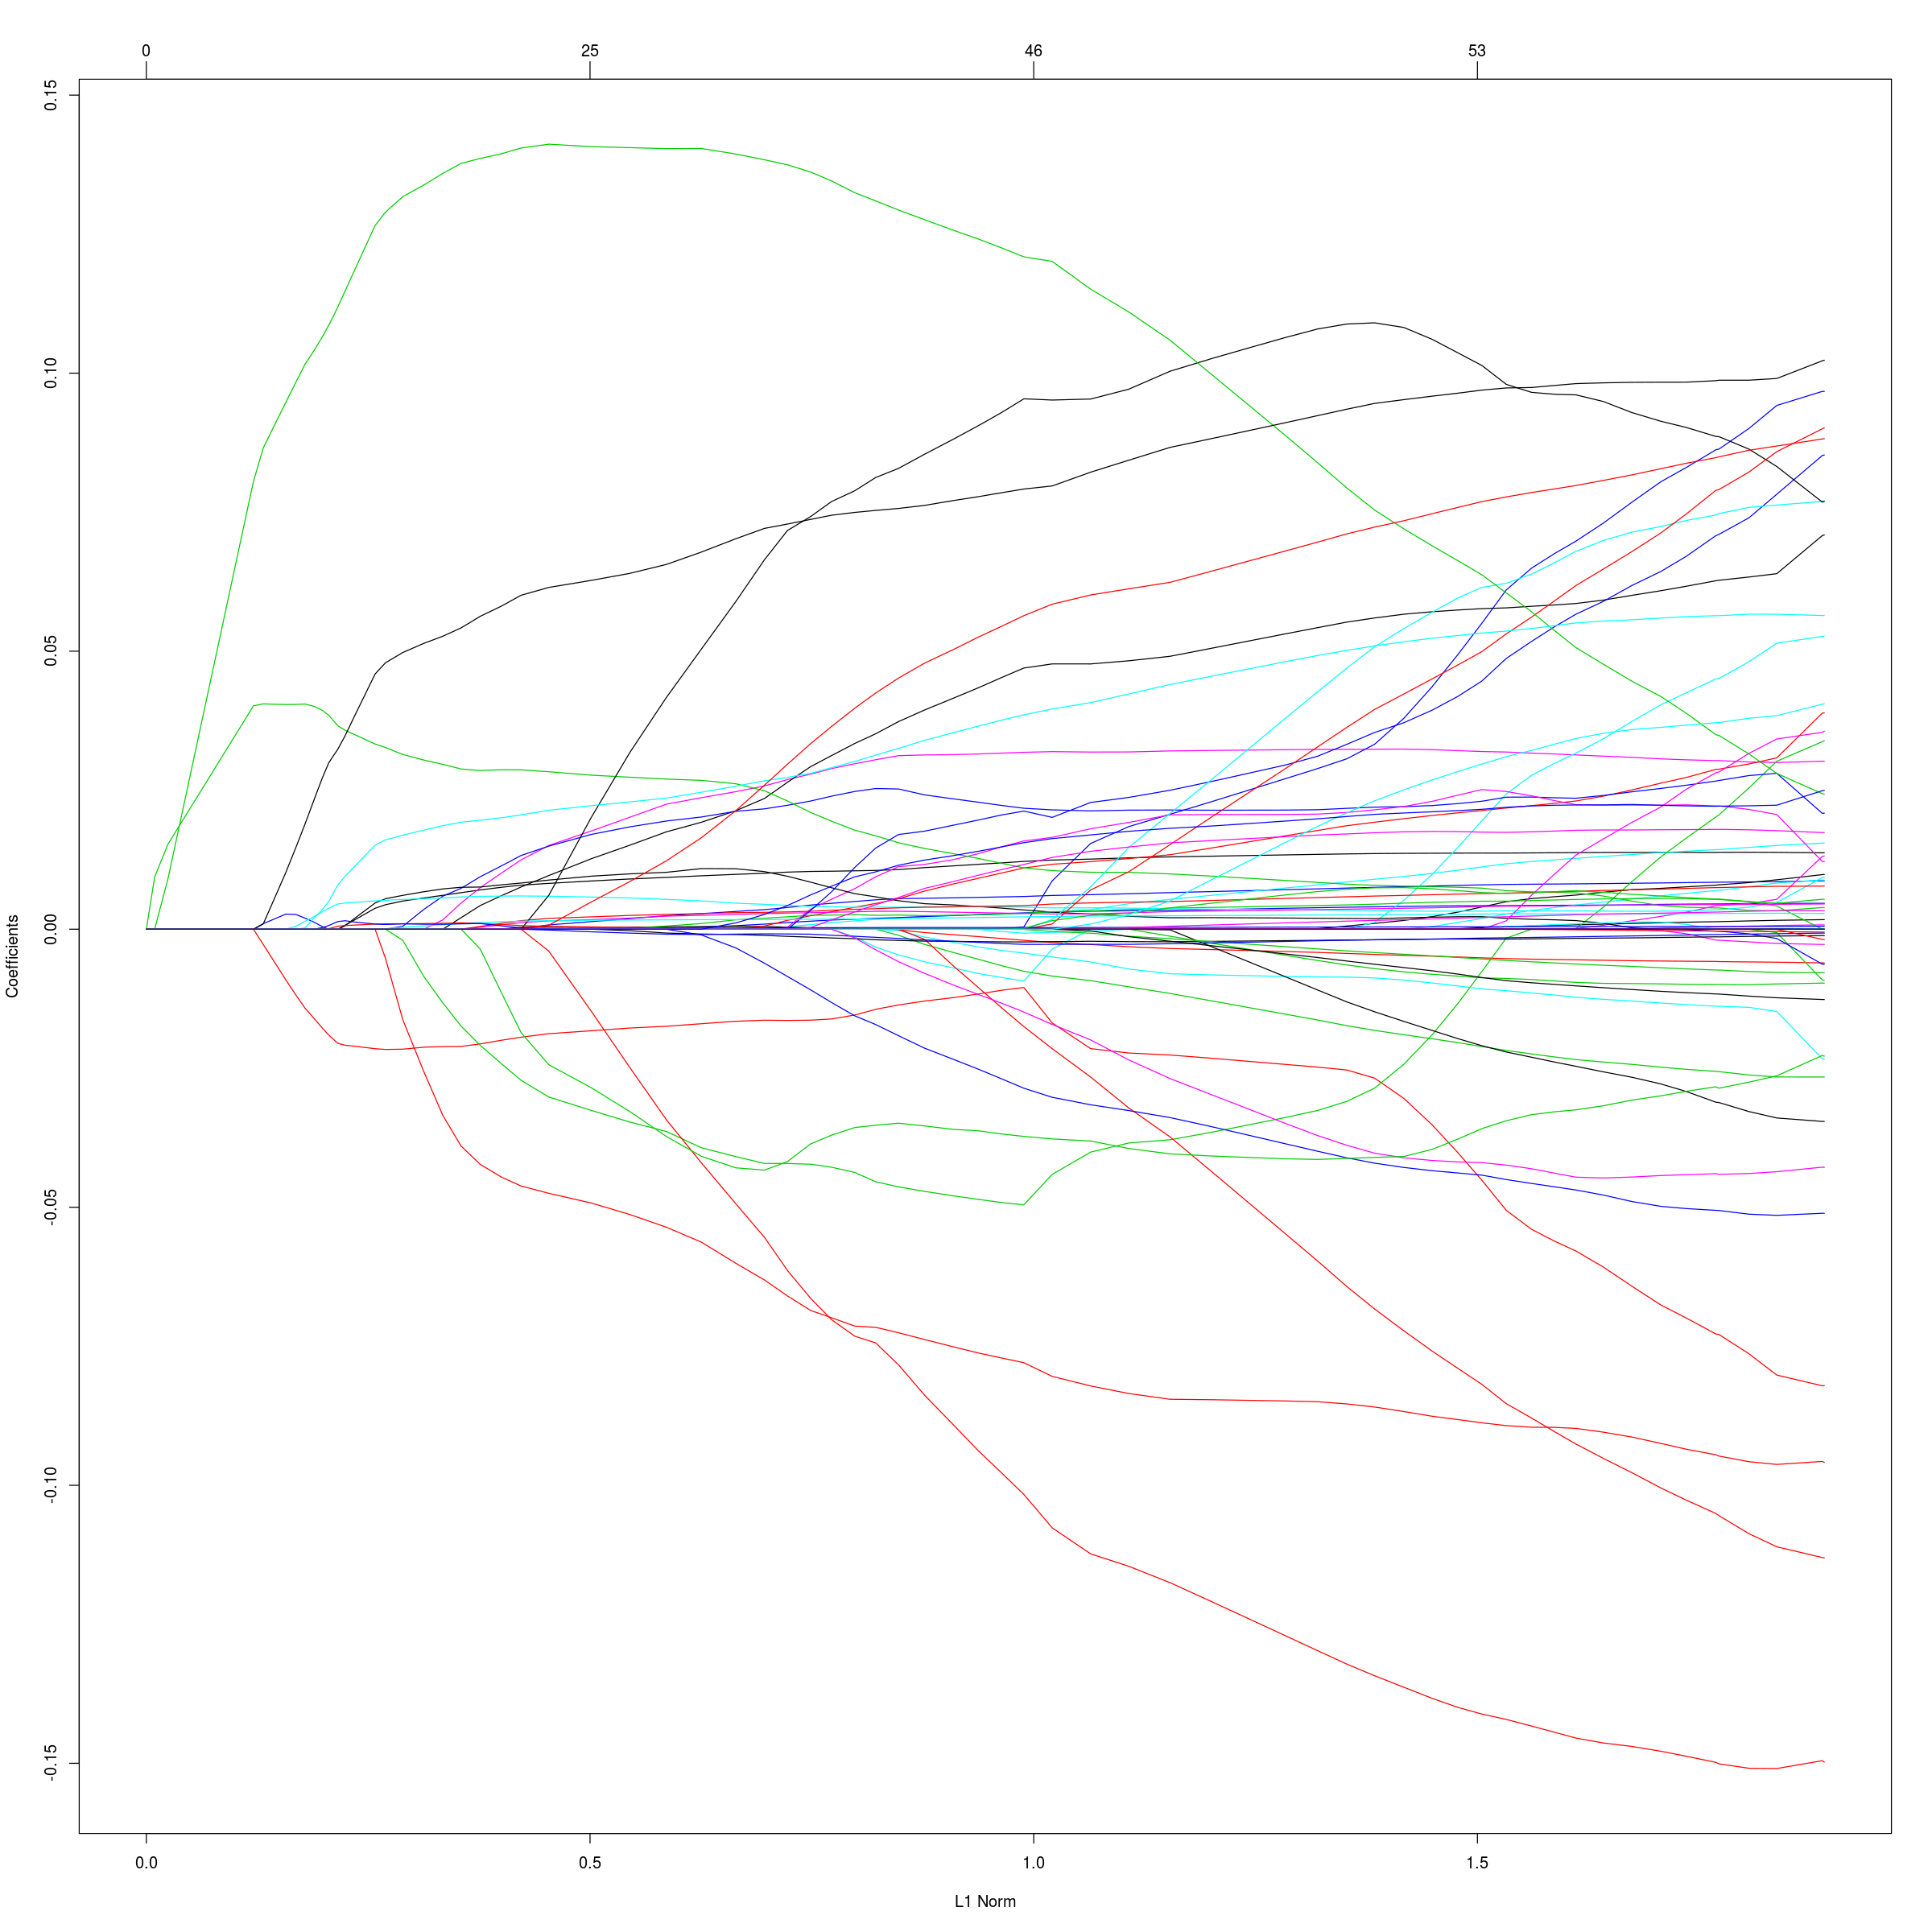

In [30]:
plot(m_lasso)

#### Cross validation

In [201]:
cv.out <- cv.glmnet(as.matrix(data), data_tot$Rating, alpha = 1)
cv.out_buts <- cv.glmnet(as.matrix(data_but), data_tot$Rating, alpha = 1)

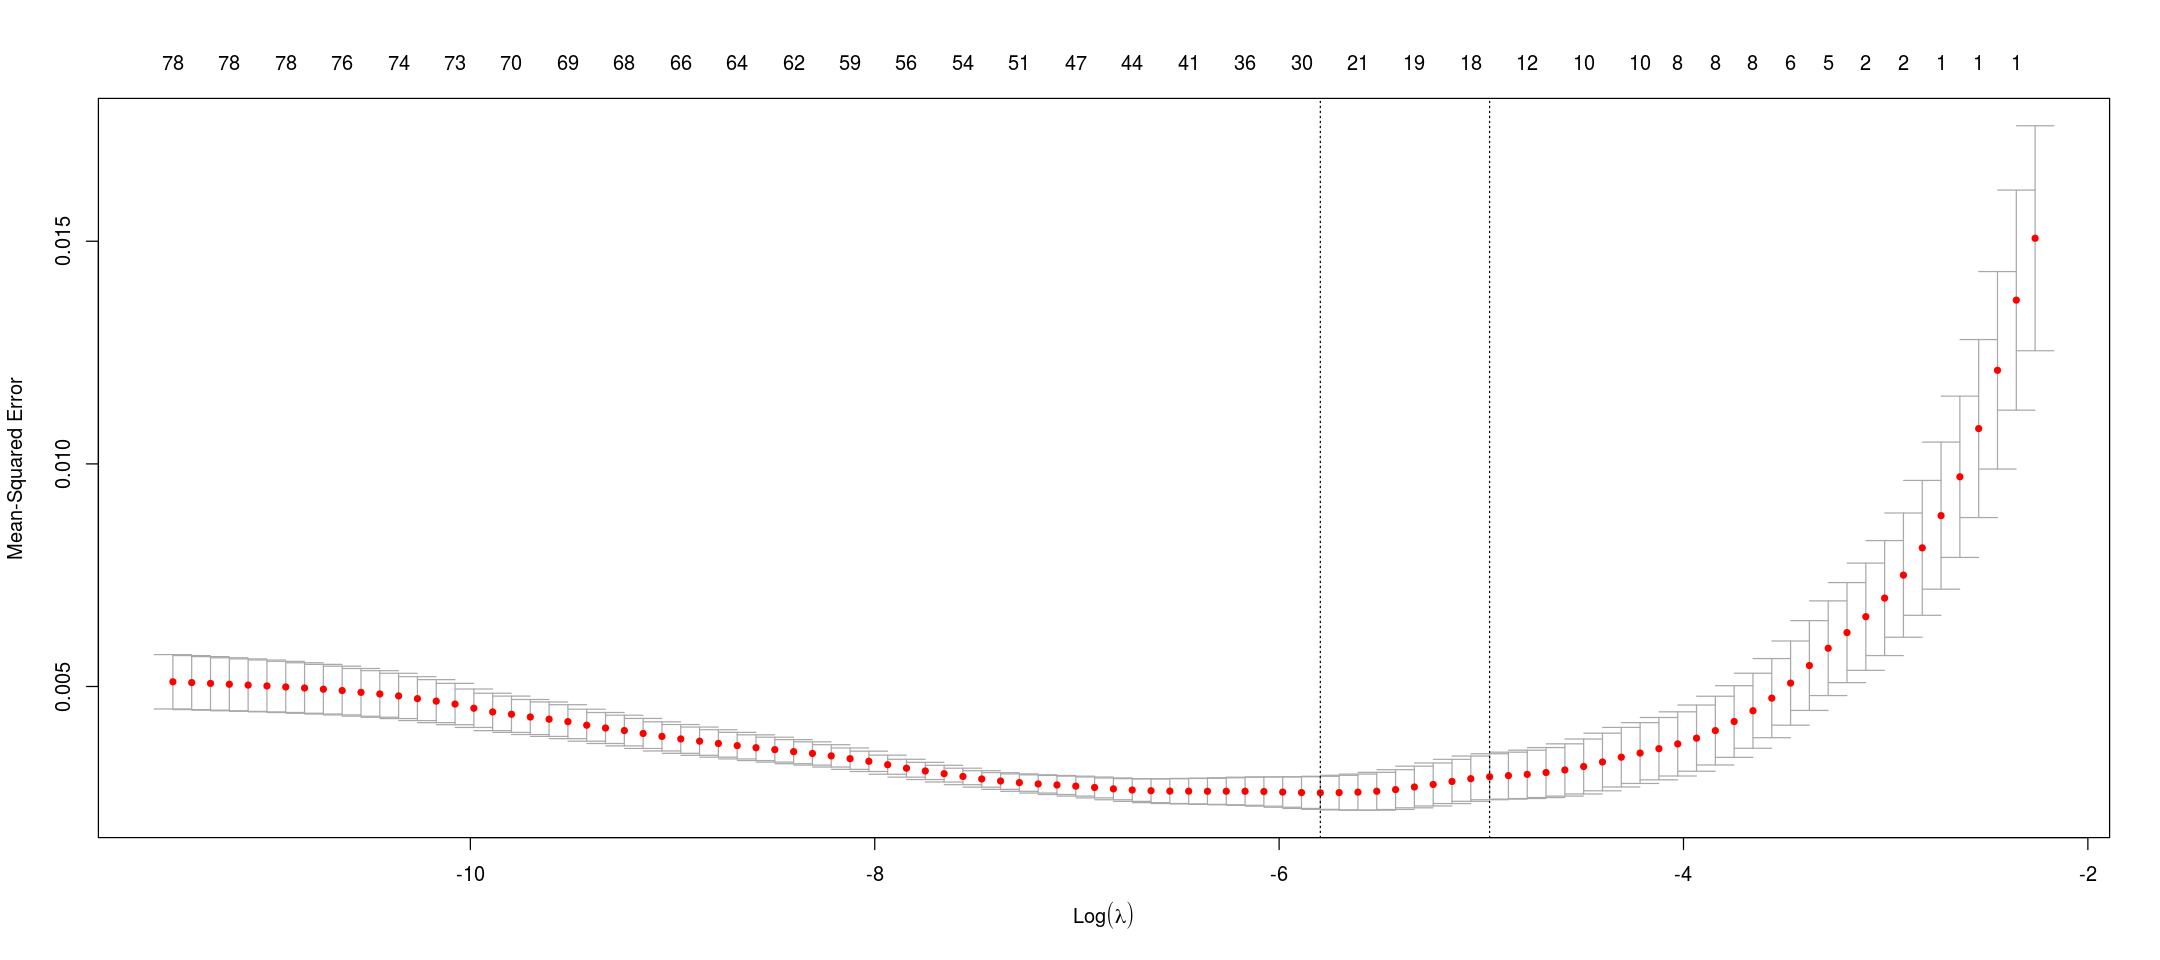

In [75]:
plot(cv.out)

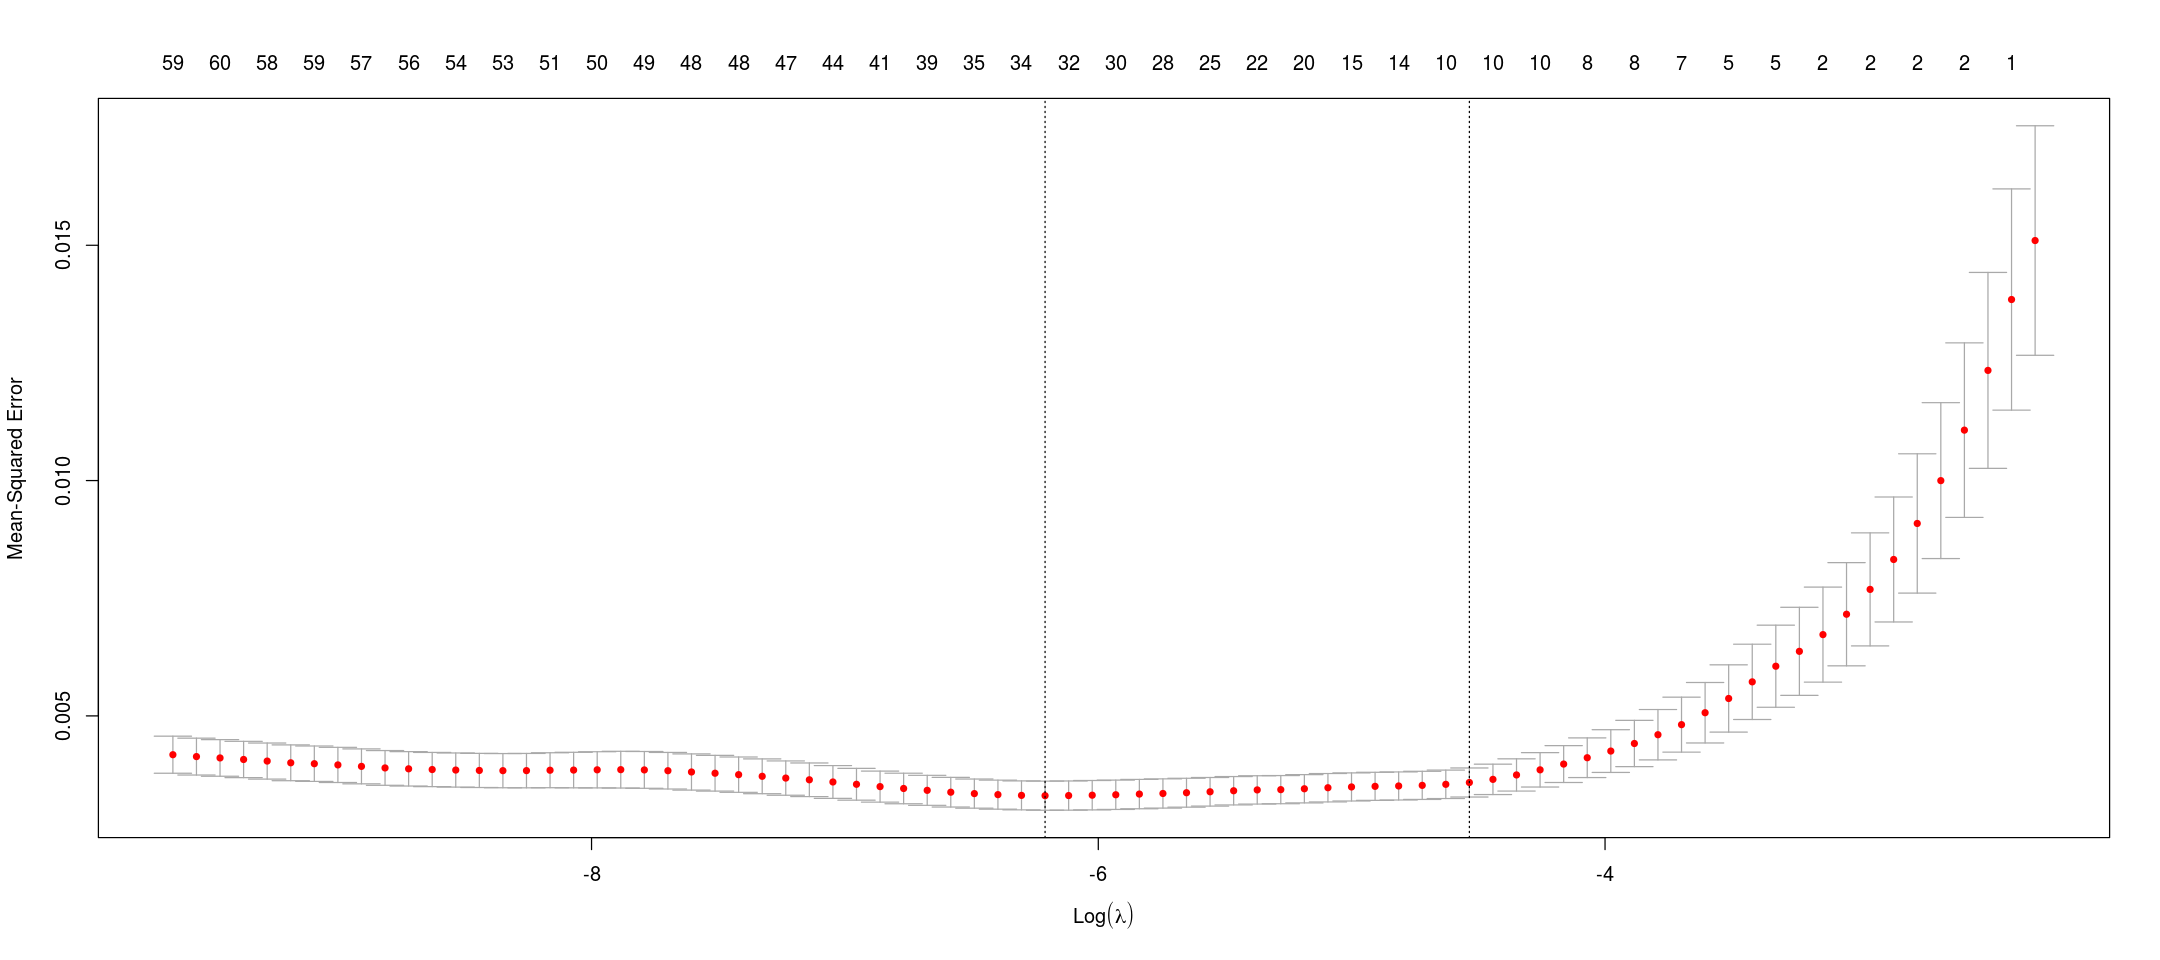

In [202]:
plot(cv.out_buts)

In [203]:
bestlam <- cv.out$lambda.min
bestlam_buts <- cv.out_buts$lambda.min

In [79]:
lasso.predict = predict(m_lasso, type = "coefficients", s = bestlam)
lasso.predict

81 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.923543e+00
Tackles_TotalTackles               8.591899e-03
Tackles_DribbledPast               .           
Tackles_TotalAttemptedTackles      .           
Interception_Total                 2.691439e-03
Fouls_Fouled                       .           
Fouls_Fouls                        .           
Cards_Yellow                       .           
Cards_Red                         -2.645718e-02
OffSides_CaughtOffside             .           
Clearances_Total                   8.119083e-06
Blocks_ShotsBlocked               -2.323970e-04
Blocks_CrossesBlocked              2.433426e-02
Blocks_PassesBlocked               2.956173e-03
Saves_Total                       -1.841223e-02
Saves_SixYardBox                  -1.985603e-02
Saves_PenaltyArea                  .           
Saves_OutOfBox                     .           
Shots_Total                        .          

In [98]:
lasso.summary = summary(lasso.predict)

In [144]:
for (i in 1:(length(lasso.summary[,1])-1)){
    df.variables.rating$Lasso[i] = round(lasso.summary[i+1,3],3)
}

In [205]:
lasso.predict_buts = predict(m_lasso, type = "coefficients", s = bestlam_buts)
lasso.predict_buts
lasso.summary_buts = summary(lasso.predict_buts)

81 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.7904418006
Tackles_TotalTackles               0.0090094057
Tackles_DribbledPast               .           
Tackles_TotalAttemptedTackles      .           
Interception_Total                 0.0052996713
Fouls_Fouled                       0.0015531506
Fouls_Fouls                       -0.0003435488
Cards_Yellow                       .           
Cards_Red                         -0.0442548174
OffSides_CaughtOffside             .           
Clearances_Total                   0.0012580359
Blocks_ShotsBlocked               -0.0022144444
Blocks_CrossesBlocked              0.0274116414
Blocks_PassesBlocked               0.0025637203
Saves_Total                       -0.0168282272
Saves_SixYardBox                  -0.0231428742
Saves_PenaltyArea                  .           
Saves_OutOfBox                     .           
Shots_Total                        .          

In [206]:
for (i in 1:(length(lasso.summary_buts[,1])-1)){
    df.variables.buts$Lasso[i] = round(lasso.summary_buts[i+1,3],3)
}

Les variables qu'il semble intéressant de retenir, d'après le modèle de régression Lasso, pour l'ensemble des données, sont :   
Tackles_TotalTackles ; Interception_Total ; Cards_Red ; Blocks_CrossesBlocked ;
Blocks_PassesBlocked ; Saves_Total ; Saves_SixYardBox ; shotsSituations_Counter ; ShotsAccuracy_OffTarget ;
GoalsZones_PenaltyArea ; GoalsSituations_PenaltyScored ; GoalsSituations_Own ; GoalsSituations_Normal ;
Dribbles_Total ; PossesionLoss_UnsuccessfulTouches ; Aerial_Won ; PassesLength_Total ; PassesLength_AccLB ; 
PassesType_AccCrn ; KeyPassesLength_Short ; KeyPassesType_Throughball

## Régression RIDGE

In [25]:
m_ridge = glmnet(as.matrix(data), data_tot$Rating, alpha = 0, nlambda = 100)

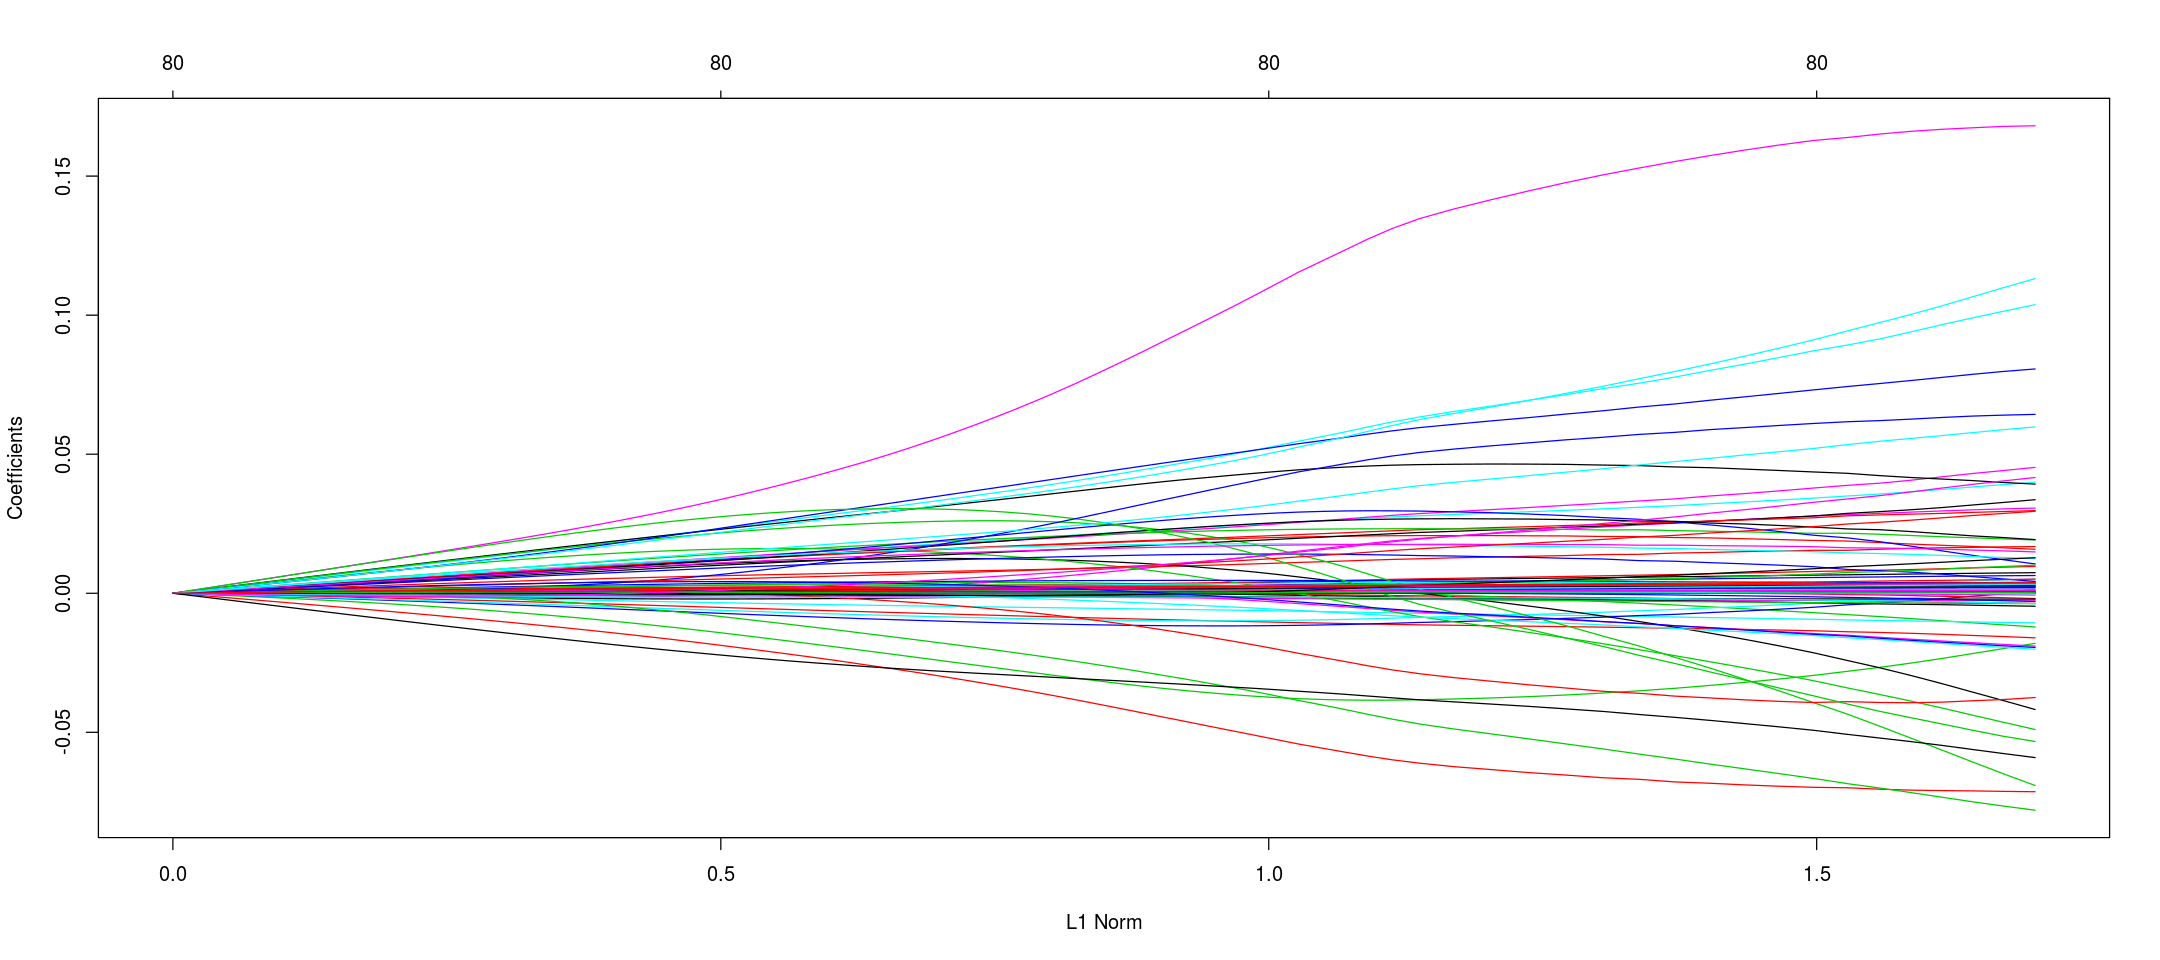

In [26]:
plot(m_ridge)

#### Cross validation

In [27]:
ridge.out <- cv.glmnet(as.matrix(data), data_tot$Rating, alpha = 0)

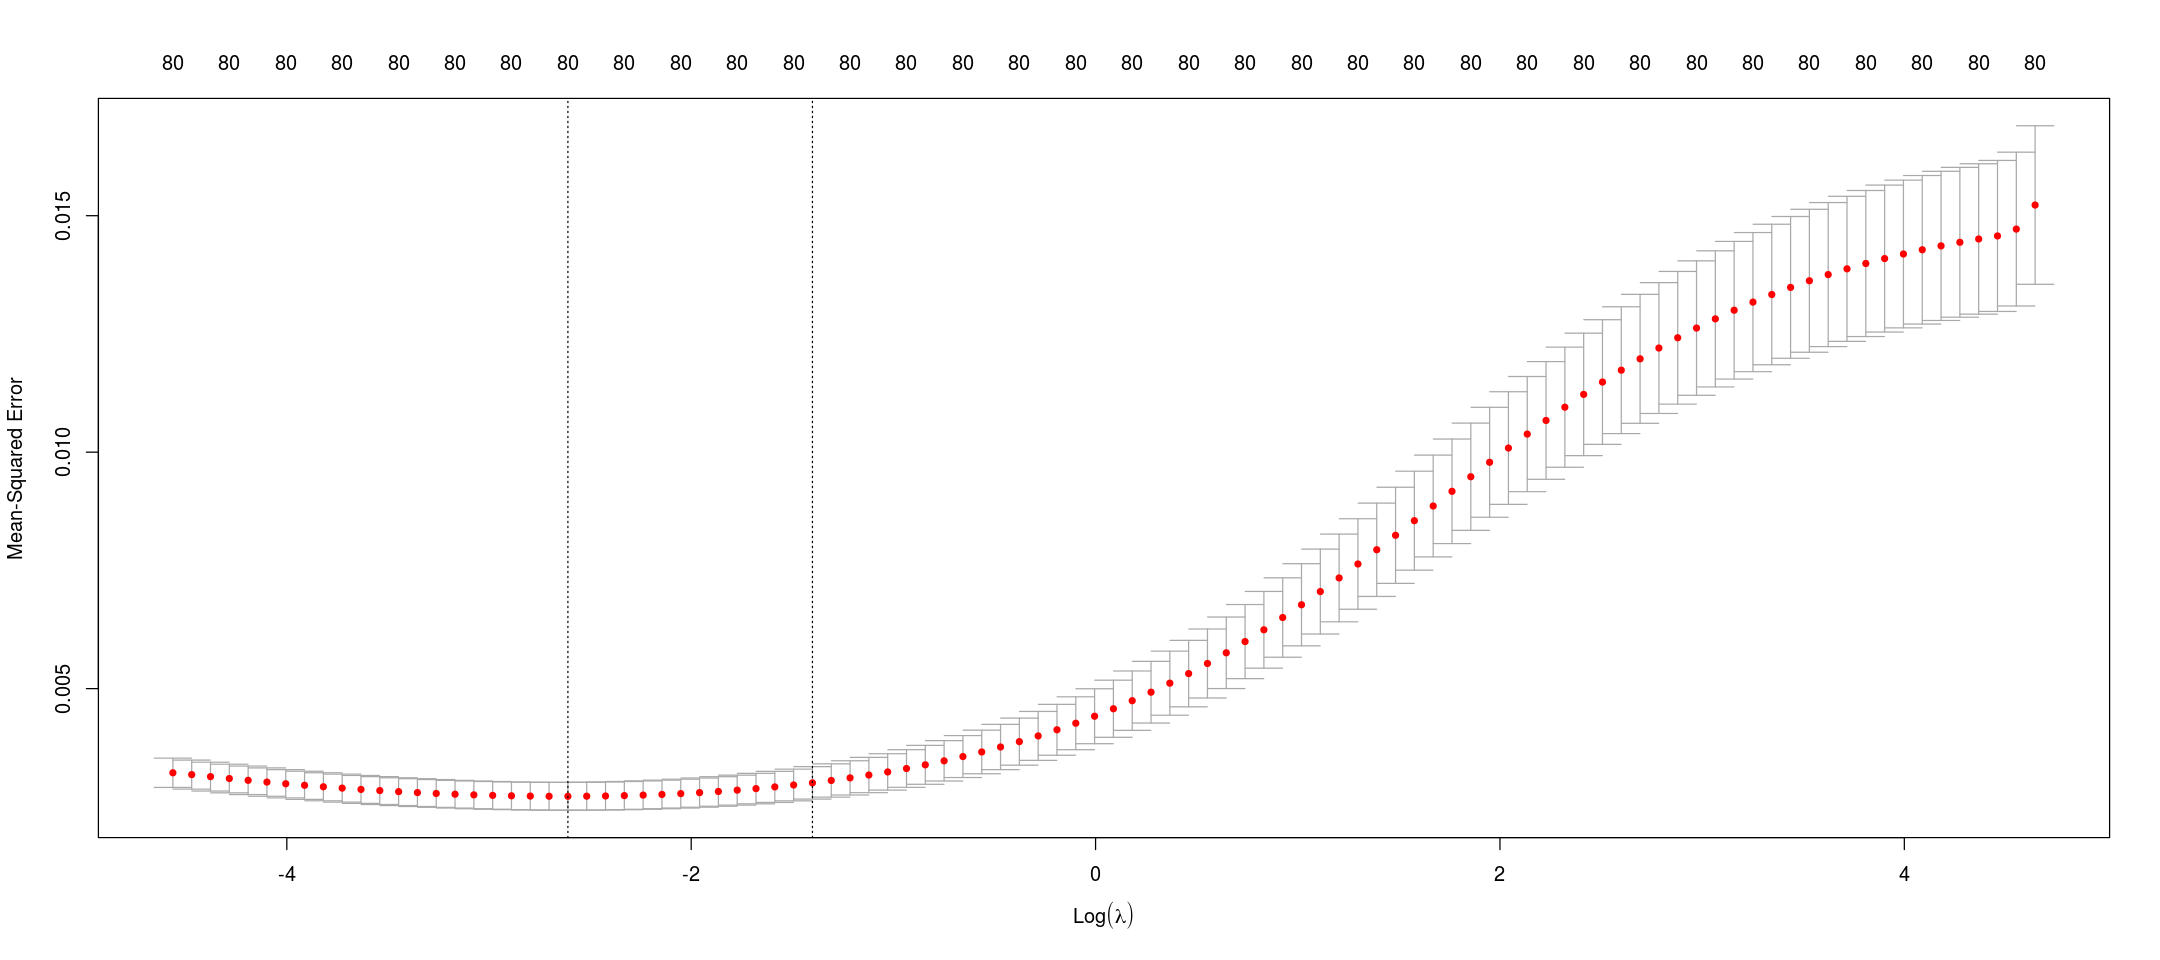

In [28]:
plot(ridge.out)

In [29]:
bestlam_ridge <- ridge.out$lambda.min

In [30]:
p = predict(m_ridge, type = "coefficients", s = bestlam_ridge)

In [31]:
print(p)

81 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.981177e+00
Tackles_TotalTackles               4.410263e-03
Tackles_DribbledPast              -6.013182e-04
Tackles_TotalAttemptedTackles      1.761406e-03
Interception_Total                 3.478537e-03
Fouls_Fouled                       1.162976e-03
Fouls_Fouls                       -2.046655e-03
Cards_Yellow                       8.937595e-04
Cards_Red                         -5.714931e-02
OffSides_CaughtOffside             1.102189e-03
Clearances_Total                   1.029212e-03
Blocks_ShotsBlocked               -6.732611e-03
Blocks_CrossesBlocked              1.701385e-02
Blocks_PassesBlocked               2.567570e-03
Saves_Total                       -1.088090e-02
Saves_SixYardBox                  -3.837601e-02
Saves_PenaltyArea                 -1.122344e-02
Saves_OutOfBox                    -9.395004e-03
Shots_Total                        1.096734e-0

Ici c'est beaucoup moins évident de faire de la sélection de variables : les coefficients ne s'annulent pas. Certains sont cependant très petits ($1e-4$).  
Si on ne souhaite garder que celles dont le coefficient est au moins de l'ordre de $10^{-2}$, on peut citer :  

(ancienne version erreur)  
Cards_Red ; OffSides_CaughtOffside ; Blocks_ShotsBlocked ; Blocks_CrossesBlocked ; Saves_Total ; Saves_SixYardBox ;
ShotsZones_SixYardBox ; shotsSituations_Counter ; ShotsSituations_SetPiece ; ShotsSituations_PenaltyTaken ; ShotsAccuracy_OnPost ; ShotsAccuracy_Blocked ; ShotsBodyParts_Other ; GoalsZones_SixYardBox ; GoalsZones_PenaltyArea              ; GoalsZones_OutOfBox ; GoalsSituations_OpenPlay ; GoalsSituations_Counter ; GoalsSituations_SetPiece ; 
GoalsSituations_PenaltyScored ; GoalsSituations_Own ; GoalsSituations_Normal ; GoalsBodyParts_RightFoot ; GoalsBodyParts_LeftFoot ; GoalsBodyParts_Head ; Assists_Cross ; Assists_Corner ; Assists_Throughball ; Assists_Freekick ; Assists_Other ; Assists_Total ; PassesType_AccCrn ; PassesType_InAccCrn ; KeyPassesLength_Long ; KeyPassesType_Corner ; KeyPassesType_Throughball ; KeyPassesType_Freekick ; KeyPassesType_Throwin

correction :  
Cards_Red ; ShotsBodyParts_Other ; Saves_SixYardBox ; KeyPassesType_Throwin ; Assists_Corner ; Saves_Total ;
Saves_PenaltyArea ;
ShotsZones_SixYardBox ; Goals_Total ; PassesType_AccCrn ; Assists_Other ; Assists_Total ; KeyPassesType_Freekick ; Blocks_CrossesBlocked ; GoalsSituations_OpenPlay ; GoalsSituations_Normal ; GoalsBodyParts_RightFoot ;  GoalsBodyParts_LeftFoot ; Assists_Cross ; shotsSituations_Counter ; GoalsZones_PenaltyArea ; GoalsBodyParts_Head ;  KeyPassesType_Throughball ; GoalsZones_OutOfBox ; Assists_Freekick ; GoalsSituations_SetPiece  ; GoalsSituations_PenaltyScored ; GoalsZones_SixYardBox ; GoalsSituations_Own

## Régression Elastic Net

In [207]:
m_enet = glmnet(as.matrix(data), data_tot$Rating, alpha = 0.5, nlambda = 100)
m_enet_buts = glmnet(as.matrix(data_but), data_tot$Rating, alpha = 0.5, nlambda = 100)

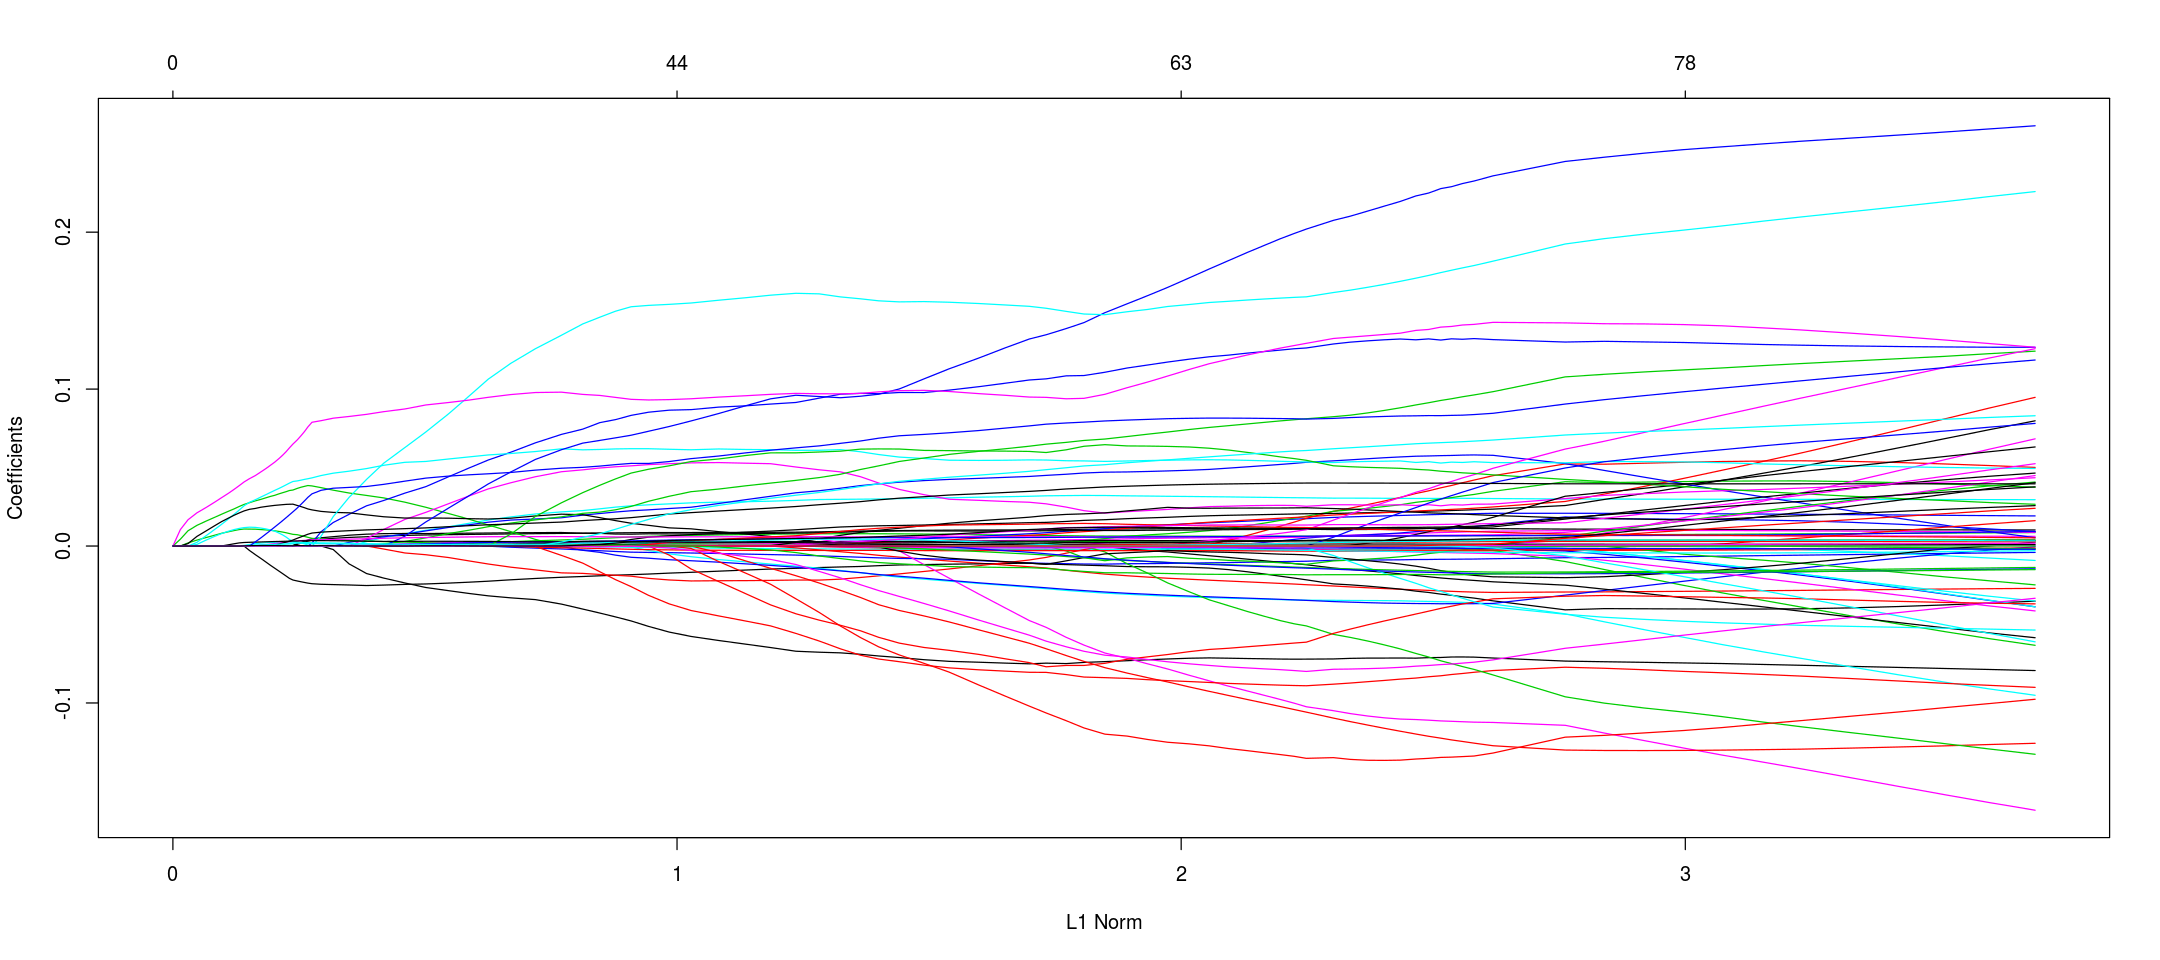

In [104]:
plot(m_enet)

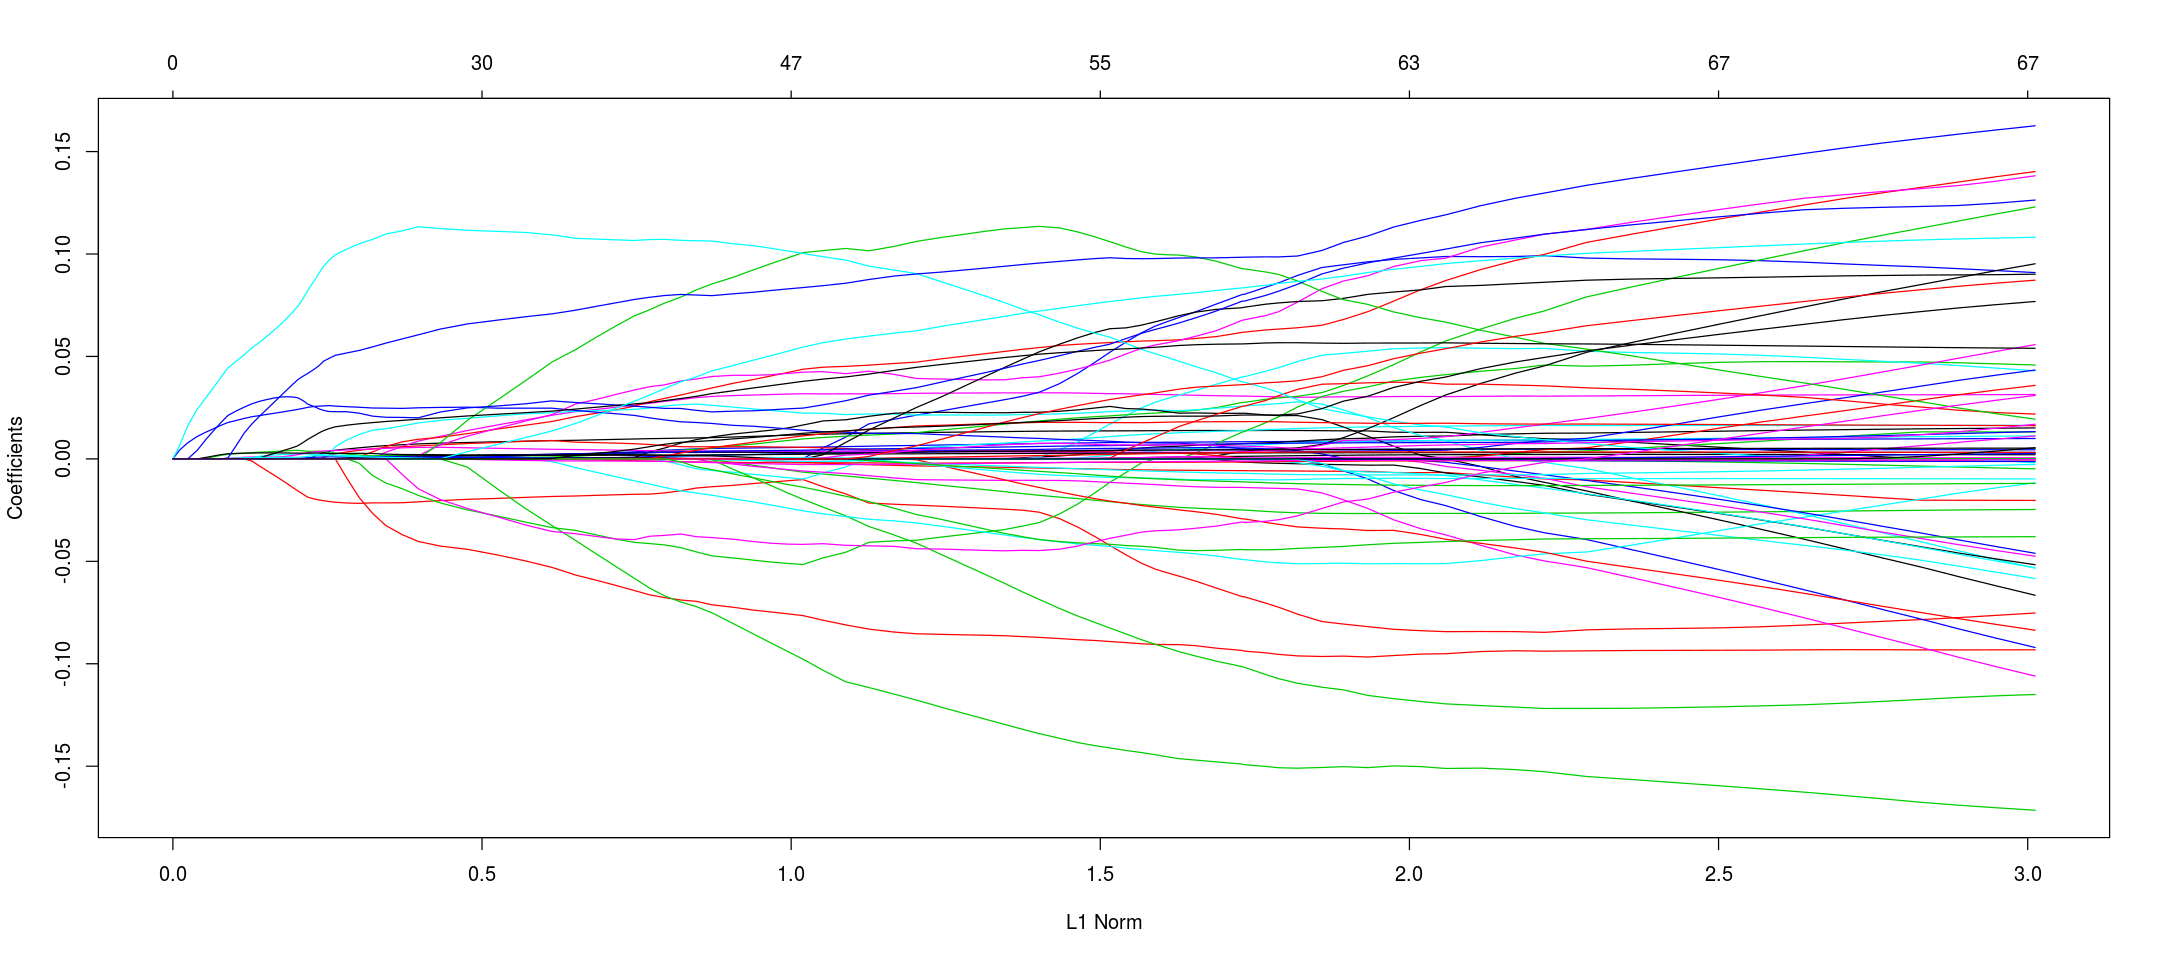

In [208]:
plot(m_enet_buts)

#### Cross validation

In [209]:
enet.out <- cv.glmnet(as.matrix(data), data_tot$Rating, alpha = 0.5)
enet.out_buts <- cv.glmnet(as.matrix(data_but), data_tot$Rating, alpha = 0.5)

In [210]:
bestlam_enet <- enet.out$lambda.min
bestlam_enet_buts <- enet.out_buts$lambda.min

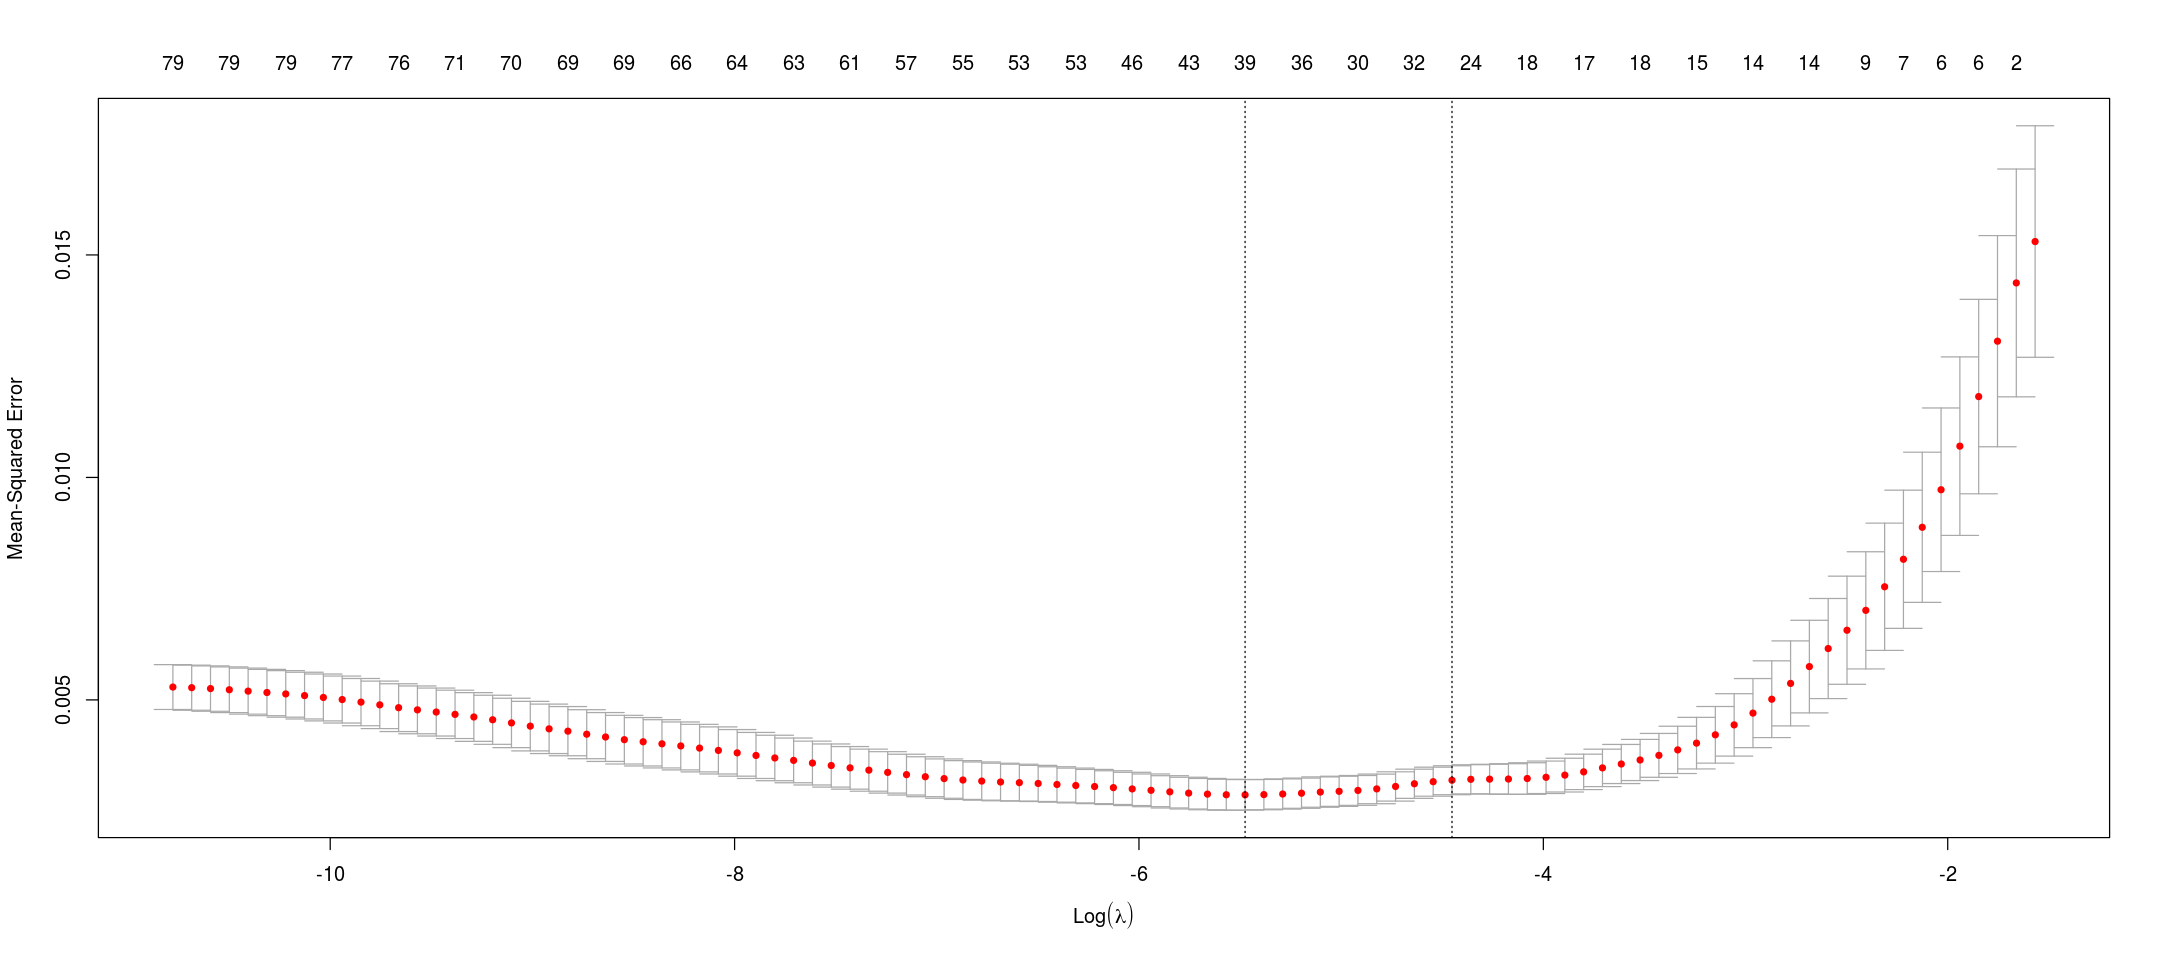

In [211]:
plot(enet.out)

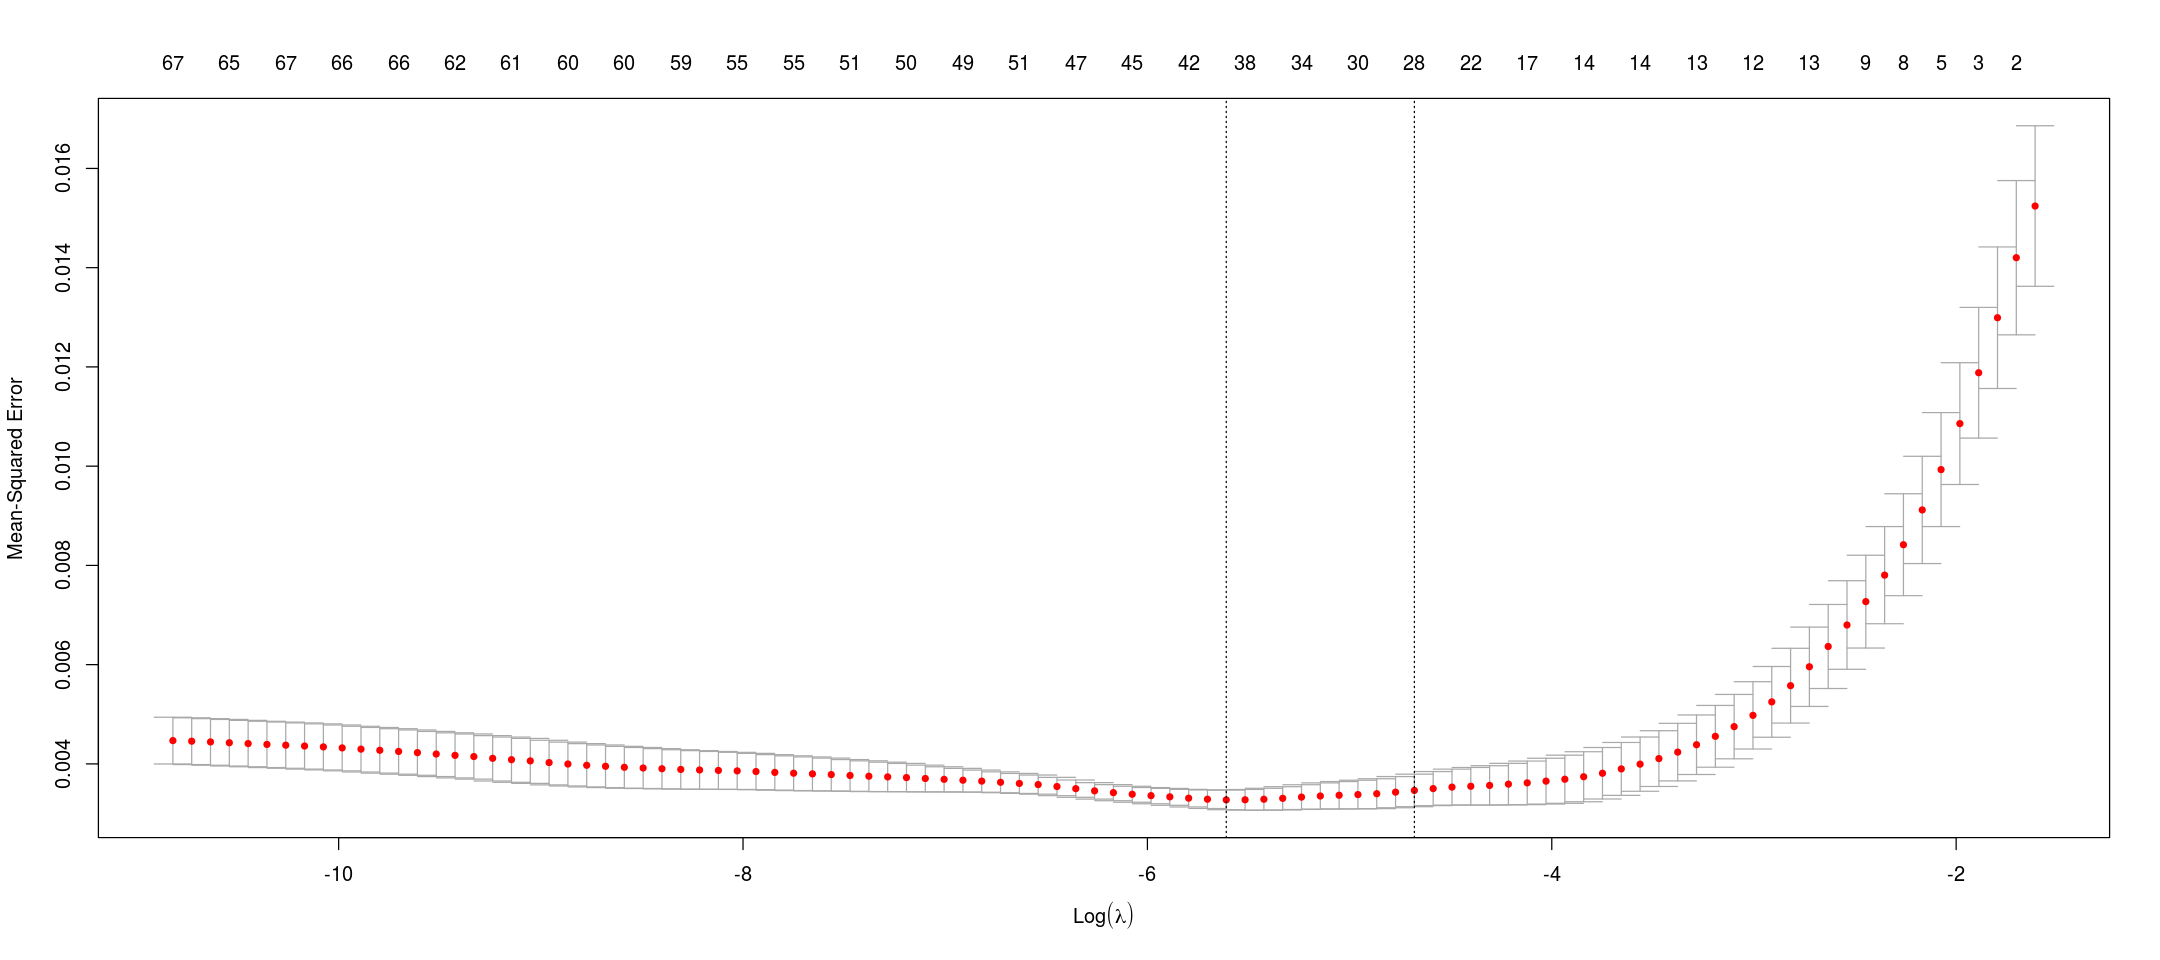

In [212]:
plot(enet.out_buts)

In [109]:
elasticnet.predict = predict(m_enet, type = "coefficients", s = bestlam_enet)
elasticnet.predict

81 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.906294e+00
Tackles_TotalTackles               8.173276e-03
Tackles_DribbledPast               .           
Tackles_TotalAttemptedTackles      .           
Interception_Total                 4.316584e-03
Fouls_Fouled                       1.539804e-04
Fouls_Fouls                       -4.545574e-04
Cards_Yellow                       .           
Cards_Red                         -4.016499e-02
OffSides_CaughtOffside             .           
Clearances_Total                   5.258637e-04
Blocks_ShotsBlocked               -2.506798e-03
Blocks_CrossesBlocked              2.259881e-02
Blocks_PassesBlocked               2.547240e-03
Saves_Total                       -1.940960e-02
Saves_SixYardBox                  -1.742367e-02
Saves_PenaltyArea                  .           
Saves_OutOfBox                     .           
Shots_Total                        .          

In [113]:
elasticnet.summary = summary(elasticnet.predict)

In [145]:
for (i in 1:(length(elasticnet.summary[,1])-1)){
    df.variables.rating$ElasticNet[i] = round(elasticnet.summary[i+1,3],3)
}

In [213]:
elasticnet.predict_buts = predict(m_enet_buts, type = "coefficients", s = bestlam_enet_buts)
elasticnet.predict_buts

68 x 1 sparse Matrix of class "dgCMatrix"
                                              1
(Intercept)                        5.740134e+00
Tackles_TotalTackles               9.979375e-03
Tackles_DribbledPast               .           
Tackles_TotalAttemptedTackles      .           
Interception_Total                 4.192576e-03
Fouls_Fouled                       8.875696e-04
Fouls_Fouls                       -9.473480e-05
Cards_Yellow                       .           
Cards_Red                         -6.772597e-02
OffSides_CaughtOffside             .           
Clearances_Total                   1.326448e-03
Blocks_ShotsBlocked                .           
Blocks_CrossesBlocked              2.809643e-02
Blocks_PassesBlocked               5.131215e-04
Saves_Total                       -1.661553e-02
Saves_SixYardBox                  -4.200181e-02
Saves_PenaltyArea                  .           
Saves_OutOfBox                    -9.829236e-04
Shots_Total                        .          

In [214]:
elasticnet.summary_buts = summary(elasticnet.predict_buts)
for (i in 1:(length(elasticnet.summary_buts[,1])-1)){
    df.variables.buts$ElasticNet[i] = round(elasticnet.summary_buts[i+1,3],3)
}

# Variable à expliquer = nombre de buts sur la totalité des matches

On fait le choix d'expliquer, en utilisant une régression de Poisson le nombre de buts marqués par une équipe sur 100 matches. Ce choix a été fait car une regression de Poisson permet d'expliquer une variable de comptage, donc entière. Or, on dispose des moyennes de buts marqués par match, ce qui est logique car tous les championnats n'ont pas autant de matches. Cependant, cette moyenne n'est pas un nombre entier. On va donc multiplier par le nombre de matches joués les moyennes empiriques de buts par saison par équipe.

In [148]:
buts = trunc(data_tot$Goals_Total * data_tot$Nombre)

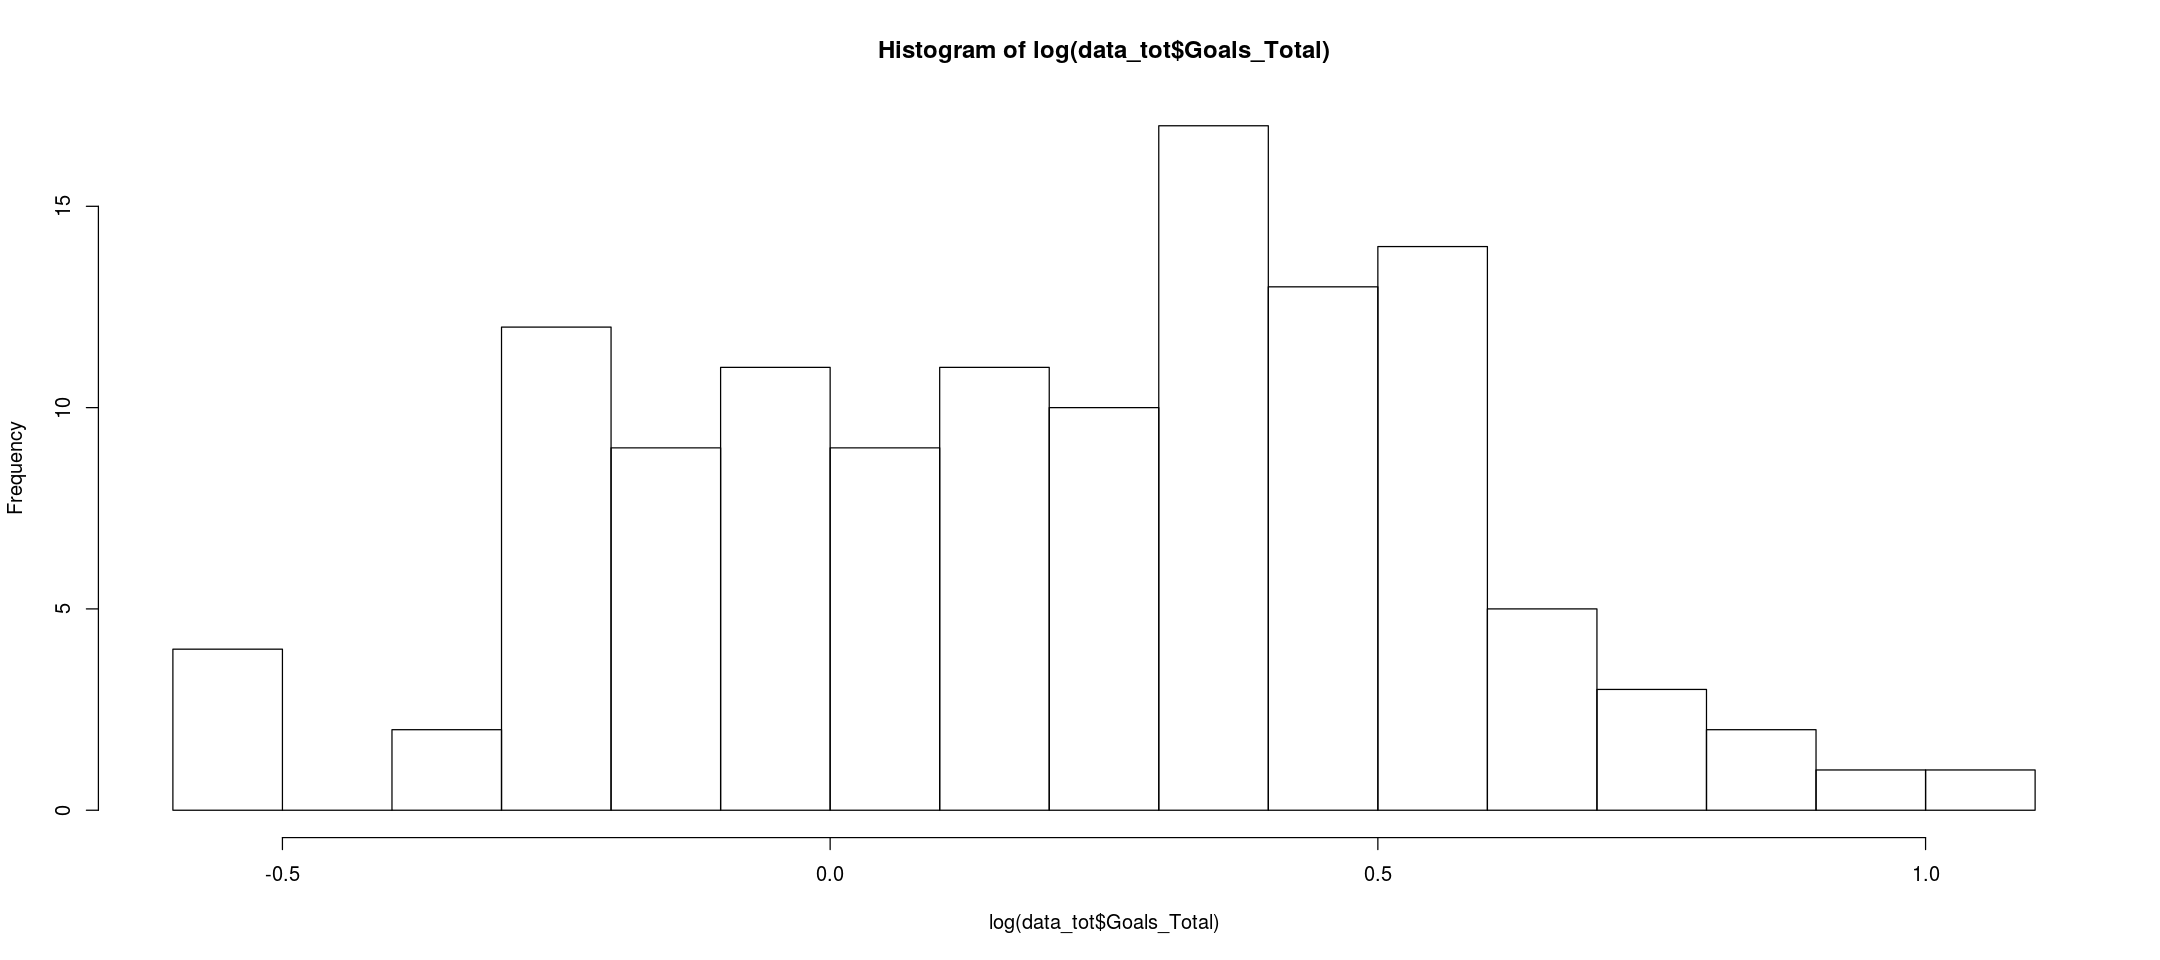

In [149]:
hist(log(data_tot$Goals_Total), breaks=12)

On peut assimiler le log de la variable `Buts` à la répartition d'une loi normale.

In [150]:
data_but = data_tot[,-c(34:46,81,82,83,84)]

In [151]:
fit.add = glm(buts~. , data=data_but, family=poisson)

In [152]:
s = step(fit.add)

Start:  AIC=879.7
buts ~ Tackles_TotalTackles + Tackles_DribbledPast + Tackles_TotalAttemptedTackles + 
    Interception_Total + Fouls_Fouled + Fouls_Fouls + Cards_Yellow + 
    Cards_Red + OffSides_CaughtOffside + Clearances_Total + Blocks_ShotsBlocked + 
    Blocks_CrossesBlocked + Blocks_PassesBlocked + Saves_Total + 
    Saves_SixYardBox + Saves_PenaltyArea + Saves_OutOfBox + Shots_Total + 
    ShotsZones_OutOfBox + ShotsZones_SixYardBox + ShotsZones_PenaltyArea + 
    ShotsSituations_OpenPlay + shotsSituations_Counter + ShotsSituations_SetPiece + 
    ShotsSituations_PenaltyTaken + ShotsAccuracy_OffTarget + 
    ShotsAccuracy_OnPost + ShotsAccuracy_OnTarget + ShotsAccuracy_Blocked + 
    ShotsBodyParts_RightFoot + ShotsBodyParts_LeftFoot + ShotsBodyParts_Head + 
    ShotsBodyParts_Other + Dribbles_Unsuccessful + Dribbles_Successful + 
    Dribbles_Total + PossesionLoss_UnsuccessfulTouches + PossesionLoss_Dispossessed + 
    Aerial_Total + Aerial_Won + Aerial_Lost + Assists_Cross +

In [153]:
s$coefficients

(Intercept)              Tackles_TotalTackles 
                     2.3045256145                      0.0256914764 
              Blocks_ShotsBlocked              Blocks_PassesBlocked 
                     0.0926843496                     -0.0547146702 
                      Saves_Total                    Saves_OutOfBox 
                     0.1132539226                     -0.3713035845 
                      Shots_Total             ShotsZones_SixYardBox 
                     0.1014323057                      0.1341132324 
     ShotsSituations_PenaltyTaken           ShotsAccuracy_OffTarget 
                     0.6017626122                     -0.2207856703 
             ShotsAccuracy_OnPost PossesionLoss_UnsuccessfulTouches 
                     0.2527402045                     -0.0243267136 
                     Aerial_Total                        Aerial_Won 
                    -0.5923804228                      0.6016611814 
                      Aerial_Lost                     Assists_Cross 
                     0.5908862246                      0.4761685378 
              Assists_Throughball                     Assists_Other 
                     0.9685361588                      0.6077813273 
               PassesLength_Total                PassesLength_AccLB 
                    -0.0006408683                      0.0079221539 
                PassesType_AccFrK               KeyPassesType_Cross 
                     0.0434951001                      0.0867929968

In [154]:
data_add_poisson = data.frame(buts, data_tot$Blocks_ShotsBlocked, data_tot$Blocks_PassesBlocked,
                     data_tot$Saves_Total,
                     data_tot$Saves_OutOfBox, data_tot$Shots_Total, 
                     data_tot$ShotsAccuracy_OffTarget, data_tot$Assists_Cross,
                     data_tot$Assists_Throughball, data_tot$Assists_Other, data_tot$PassesLength_Total, 
                     data_tot$PassesType_AccFrK, data_tot$ShotsAccuracy_OnPost,
                     data_tot$Tackles_TotalTackles, data_tot$ShotsZones_SixYardBox, data_tot$ShotsSituations_PenaltyTaken,
                     data_tot$PossesionLoss_UnsuccessfulTouches, data_tot$Aerial_Total, data_tot$Aerial_Won, data_tot$Aerial_Lost,
                     data_tot$PassesLength_AccLB, data_tot$KeyPassesType_Cross)

names(data_add_poisson) <- c("Buts", "Blocks_ShotsBlocked", "Blocks_PassesBlocked", "Saves_Total", 
                     "Saves_OutOfBox", "Shots_Total",
                     "ShotsAccuracy_OffTarget", 
                     "Assists_Cross", "Assists_Throughball", "Assists_Other",
                     "PassesLength_Total", "PassesType_AccFrK", "ShotsAccuracy_OnPost",
                     "Tackles_TotalTackles", "ShotsZones_SixYardBox", "ShotsSituations_PenaltyTaken", 
                     "PossesionLoss_UnsuccessfulTouches", "Aerial_Total", "Aerial_Won", "Aerial_Lost", 
                     "PassesLength_AccLB", "KeyPassesType_Cross")


In [155]:
rownames(data_add_poisson) = rownames(data_tot)

In [156]:
fit_poisson = glm(Buts~., data = data_add_poisson, family = poisson)

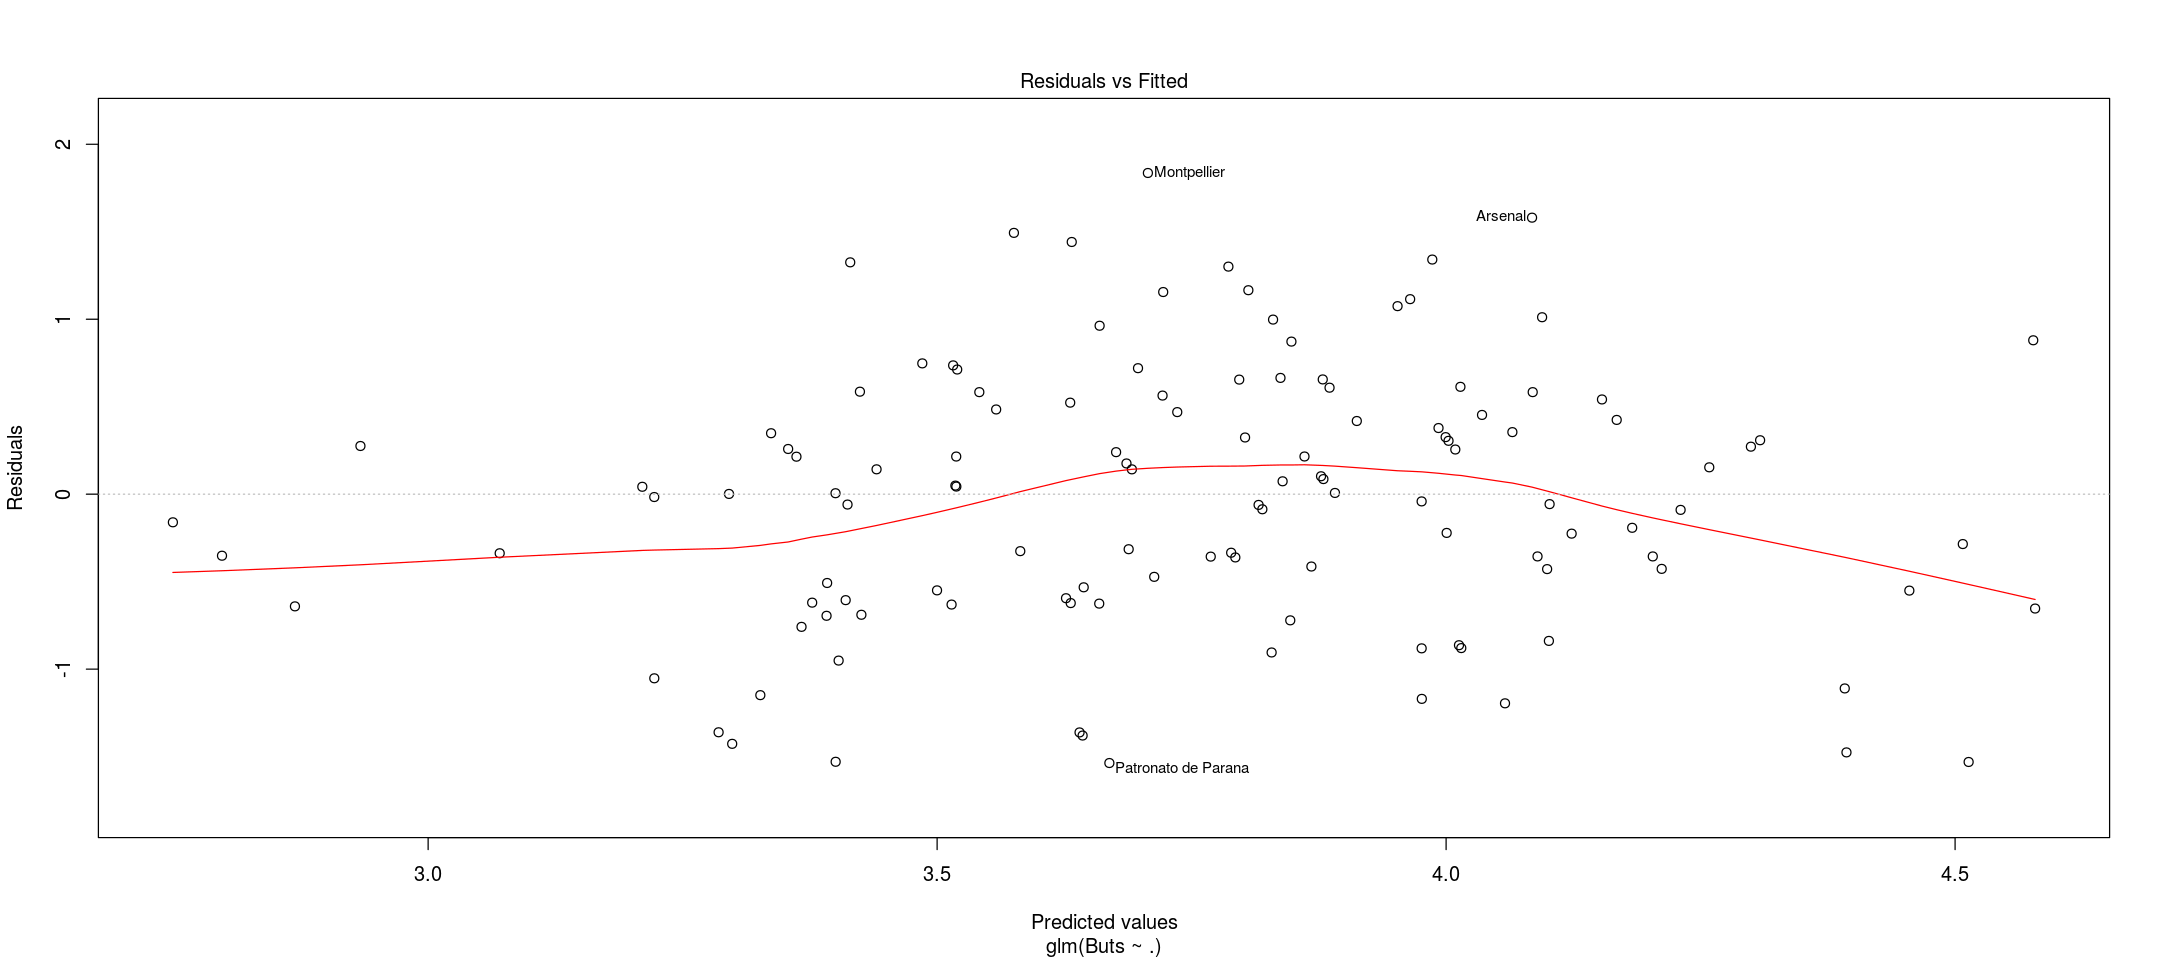

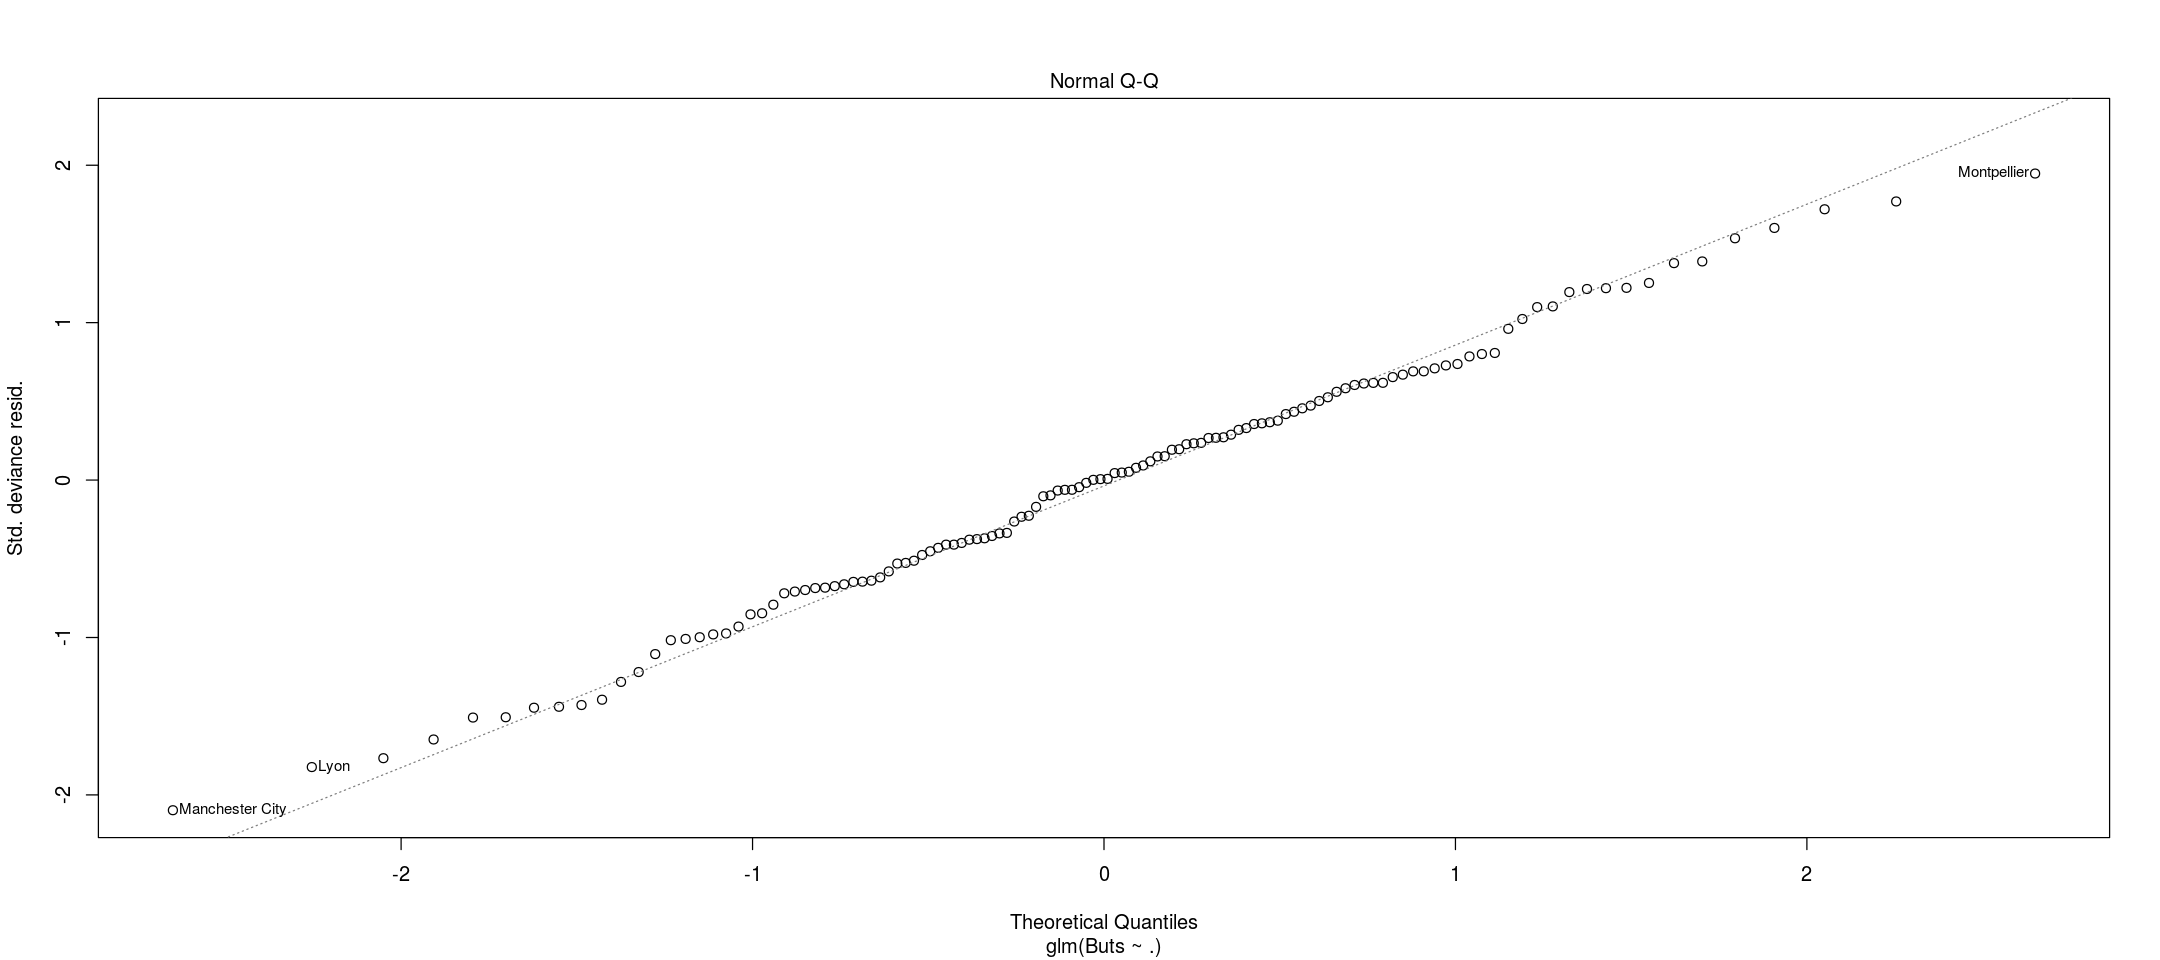

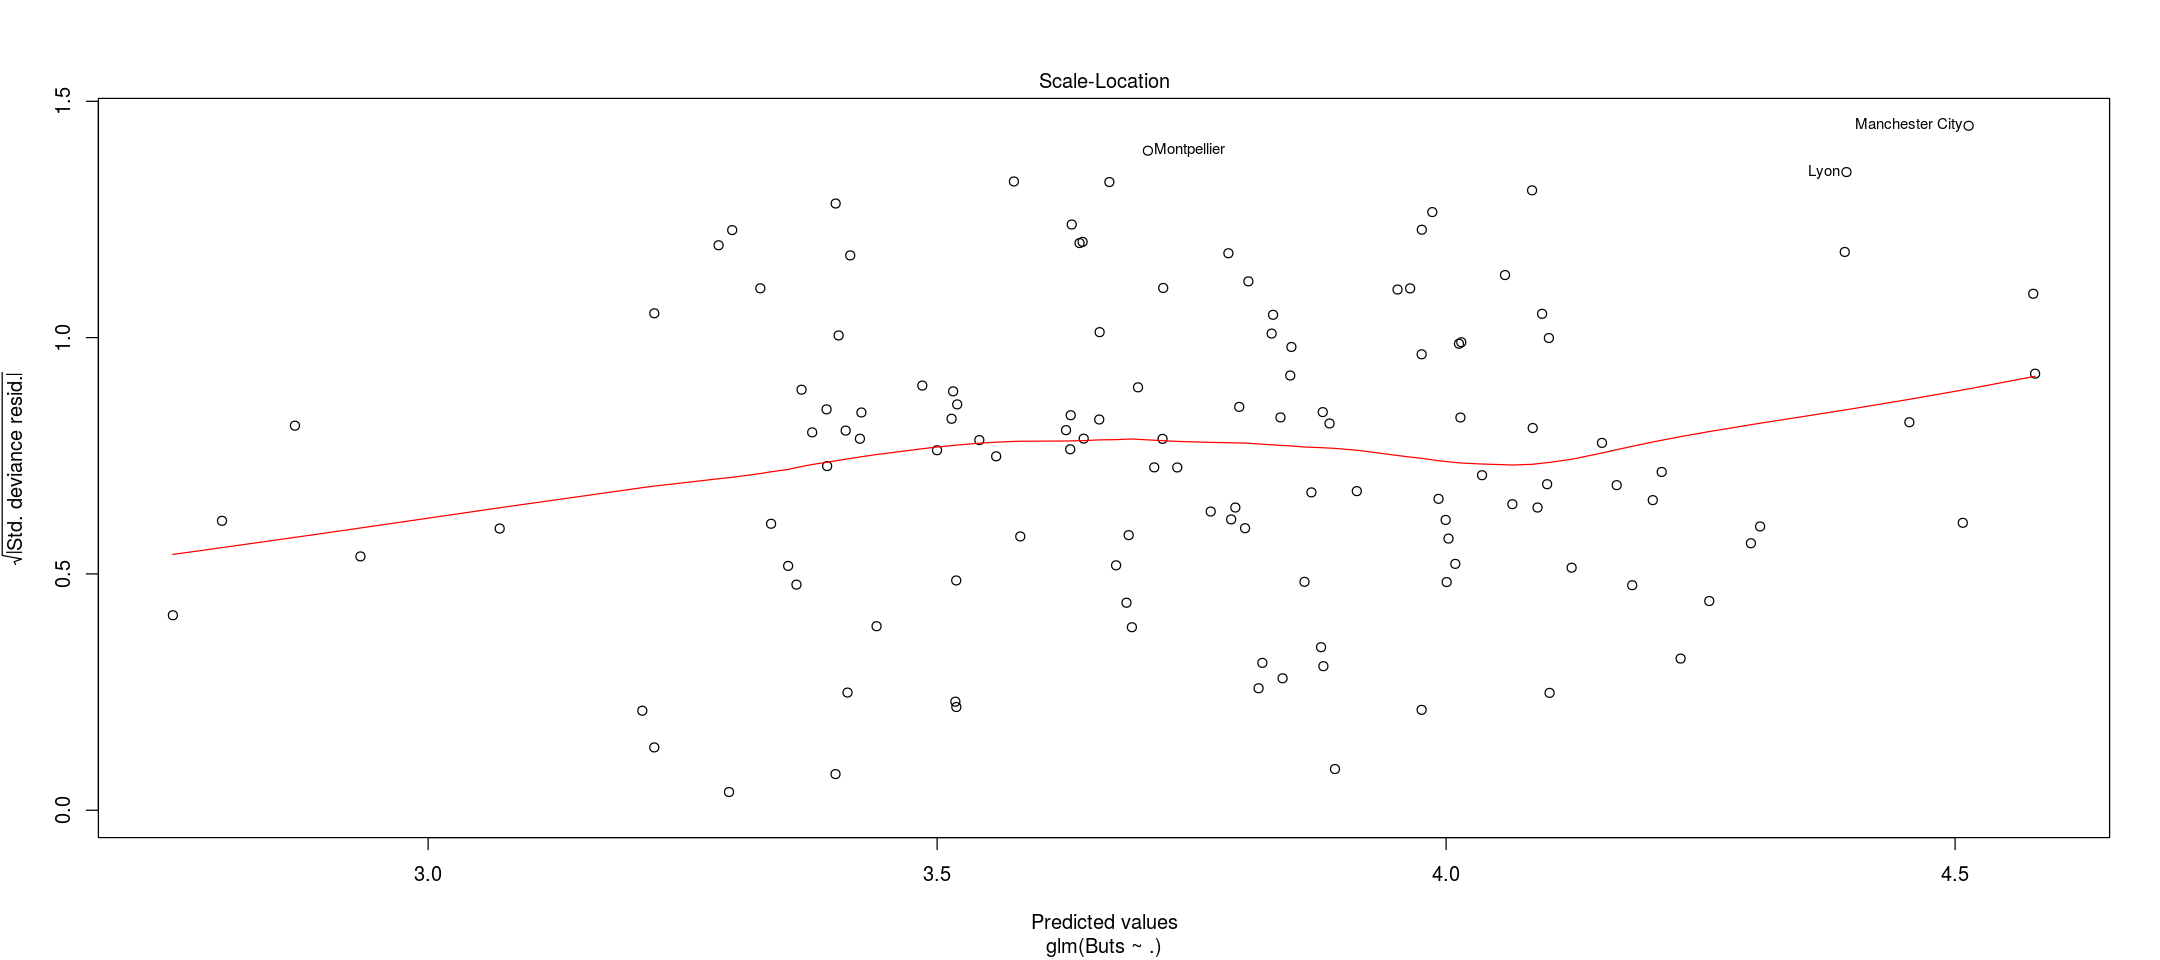

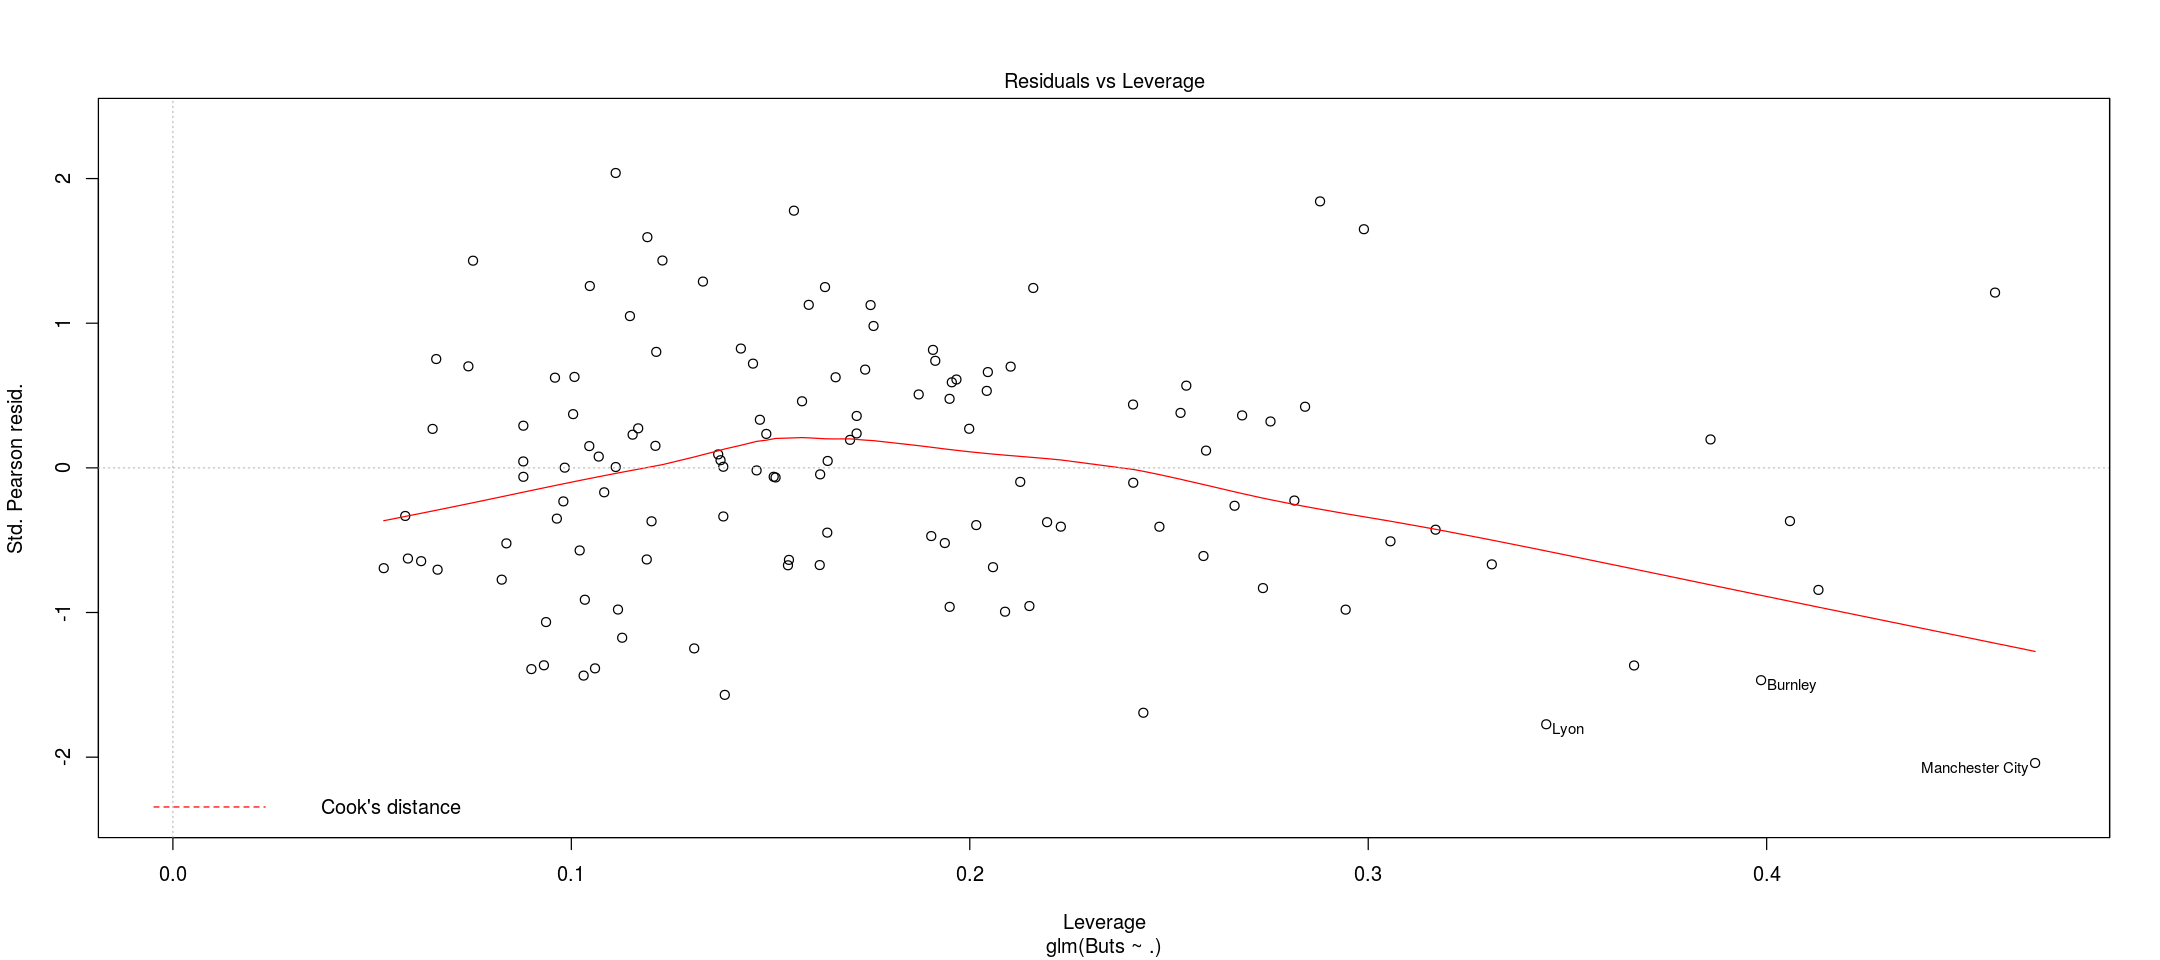

In [157]:
plot(fit_poisson)

In [158]:
R_squared = 1 - fit_poisson$deviance/fit_poisson$null.deviance
print(paste("R^2 du modèle de poisson :", R_squared))

[1] "R^2 du modèle de poisson : 0.911716331492632"


Le $R^2$ est très proche de 1 donc le modèle de régression de Poisson additif semble bien expliquer la variable du nombre de buts.

Ces résultats ne sont cependant pas représentatifs de la réalité : on a utilisé le nombre de buts total, dépendant du nombre de matches joués, mais on a utiliser les valeurs moyennées sur le reste des données. On va donc refaire l'opération, avec des variables comptées sur l'ensemble de la saison.

In [159]:
data_but_tot = data_but * data_tot$Nombre

In [160]:
fit.add_tot = glm(buts~. , data=data_but_tot, family=poisson)

In [161]:
s = step(fit.add_tot)

Start:  AIC=858.81
buts ~ Tackles_TotalTackles + Tackles_DribbledPast + Tackles_TotalAttemptedTackles + 
    Interception_Total + Fouls_Fouled + Fouls_Fouls + Cards_Yellow + 
    Cards_Red + OffSides_CaughtOffside + Clearances_Total + Blocks_ShotsBlocked + 
    Blocks_CrossesBlocked + Blocks_PassesBlocked + Saves_Total + 
    Saves_SixYardBox + Saves_PenaltyArea + Saves_OutOfBox + Shots_Total + 
    ShotsZones_OutOfBox + ShotsZones_SixYardBox + ShotsZones_PenaltyArea + 
    ShotsSituations_OpenPlay + shotsSituations_Counter + ShotsSituations_SetPiece + 
    ShotsSituations_PenaltyTaken + ShotsAccuracy_OffTarget + 
    ShotsAccuracy_OnPost + ShotsAccuracy_OnTarget + ShotsAccuracy_Blocked + 
    ShotsBodyParts_RightFoot + ShotsBodyParts_LeftFoot + ShotsBodyParts_Head + 
    ShotsBodyParts_Other + Dribbles_Unsuccessful + Dribbles_Successful + 
    Dribbles_Total + PossesionLoss_UnsuccessfulTouches + PossesionLoss_Dispossessed + 
    Aerial_Total + Aerial_Won + Aerial_Lost + Assists_Cross 

In [162]:
coefs.buts = s$coefficients
coefs.buts

(Intercept)             Saves_Total        Saves_SixYardBox 
           2.3079157556            0.0028604066           -0.0101805251 
         Saves_OutOfBox             Shots_Total ShotsAccuracy_OffTarget 
          -0.0036798952            0.0044942480           -0.0047748549 
  ShotsAccuracy_Blocked ShotsBodyParts_LeftFoot            Aerial_Total 
          -0.0047595272           -0.0009163588           -0.0002239396 
          Assists_Total      PassesLength_Total      PassesLength_AccSP 
           0.0176475909            0.0001663558           -0.0001876321 
      PassesType_AccFrK  KeyPassesType_Freekick   KeyPassesType_Throwin 
           0.0004297035            0.0043599041           -0.0106932035

In [215]:
for (i in 1:nb.variables.buts){
    for (j in 1:(length(names(coefs.buts))-1)){
        if (df.variables.buts$Noms[i] == names(coefs.buts)[j+1]){
            df.variables.buts$NombreDeButs[i] = round(coefs.buts[j+1],3)
        }
    } 
}

In [53]:
data_add_poisson_tot = data.frame(buts,
                     data_but_tot$Saves_Total,
                     data_but_tot$Saves_OutOfBox, data_but_tot$Shots_Total, 
                     data_but_tot$ShotsAccuracy_OffTarget, data_but_tot$PassesLength_Total, 
                     data_but_tot$PassesType_AccFrK,
                     data_but_tot$Aerial_Total, data_but_tot$Saves_SixYardBox, data_but_tot$ShotsAccuracy_Blocked,
                     data_but_tot$ShotsBodyParts_LeftFoot, data_but_tot$Assists_Total, data_but_tot$PassesLength_AccSP,
                     data_but_tot$KeyPassesType_Freekick, data_but_tot$KeyPassesType_Throwin)

names(data_add_poisson_tot) <- c("Buts", "Saves_Total", 
                     "Saves_OutOfBox", "Shots_Total",
                     "ShotsAccuracy_OffTarget", 
                     "PassesLength_Total", "PassesType_AccFrK", 
                     "Aerial_Total", "Saves_SixYardBox", "ShotsAccuracy_Blocked", "ShotsBodyParts_LeftFoot", 
                     "Assists_Total", "PassesLength_AccSP", "KeyPassesType_Freekick", "KeyPassesType_Throwin")


In [54]:
rownames(data_add_poisson_tot) = rownames(data_tot)

In [55]:
fit_poisson_tot = glm(Buts~., data = data_add_poisson_tot, family = poisson)

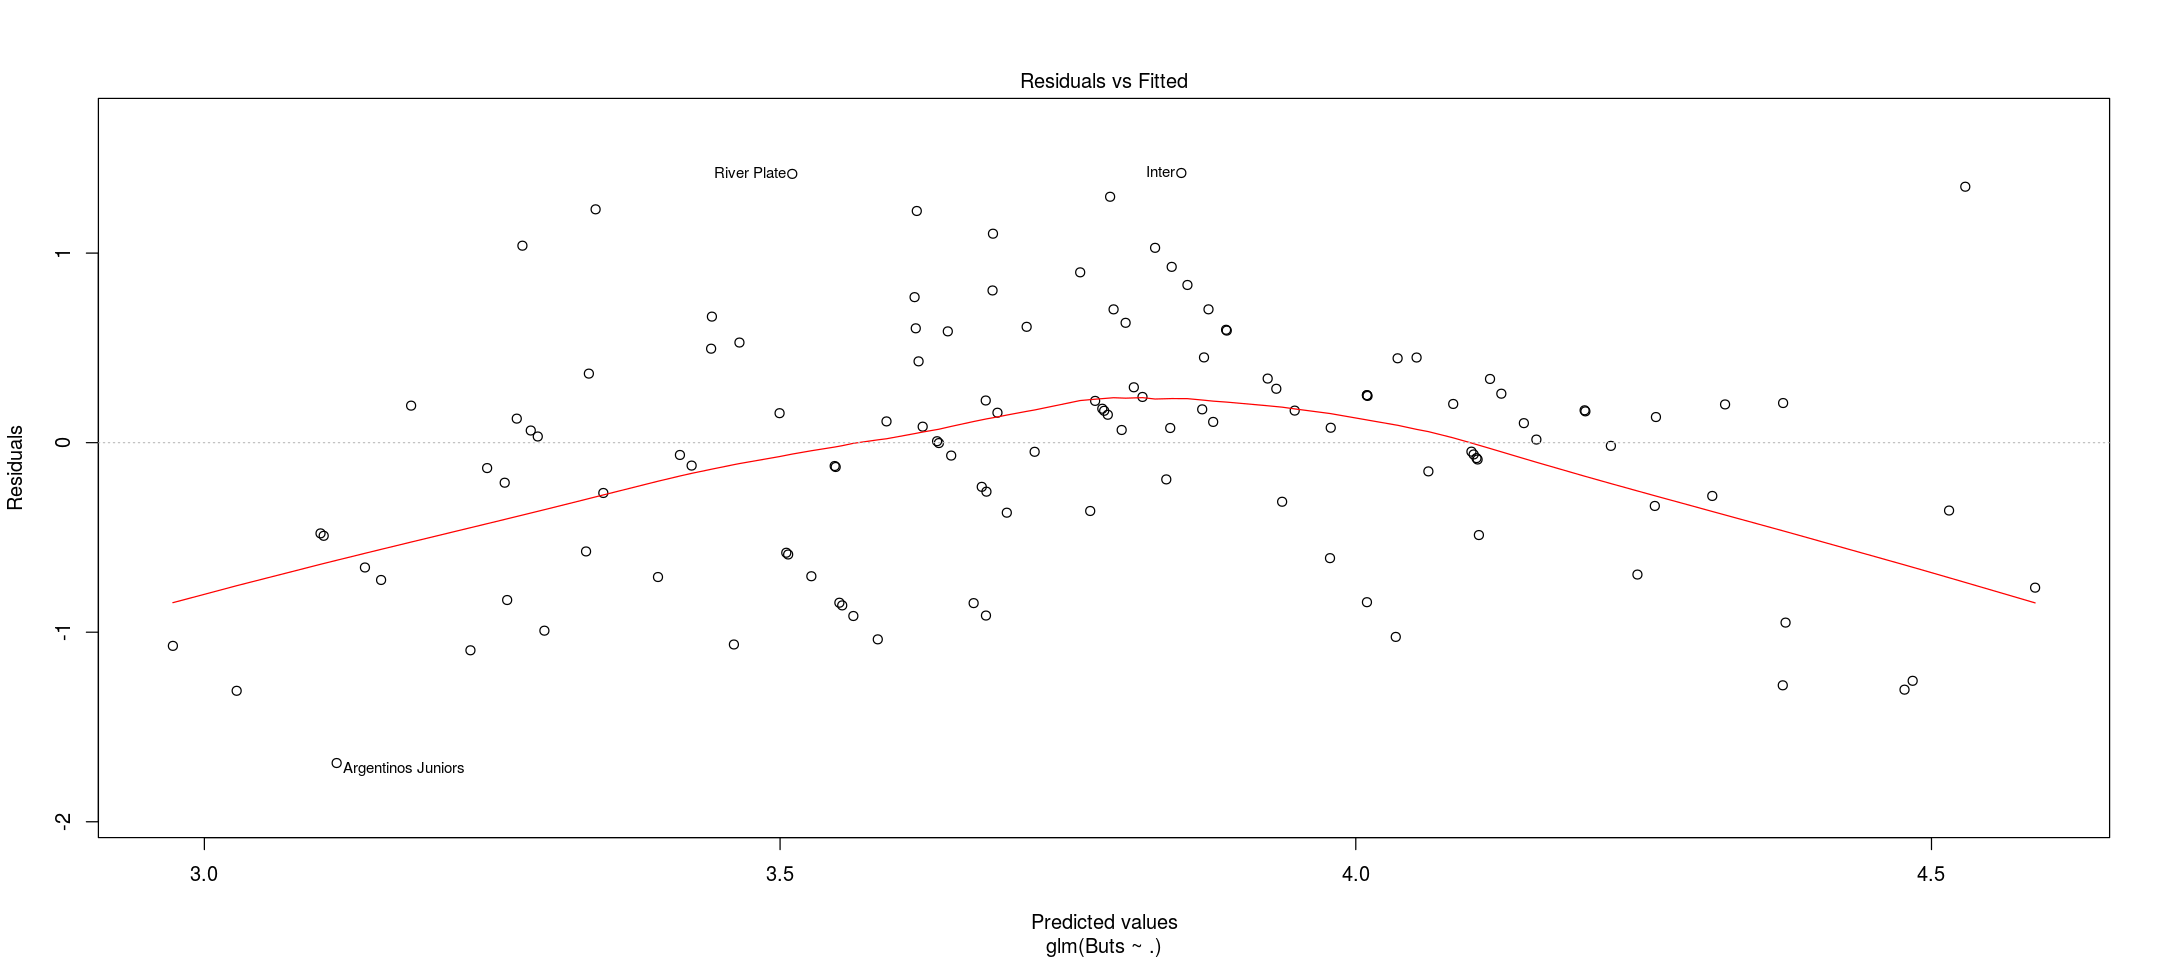

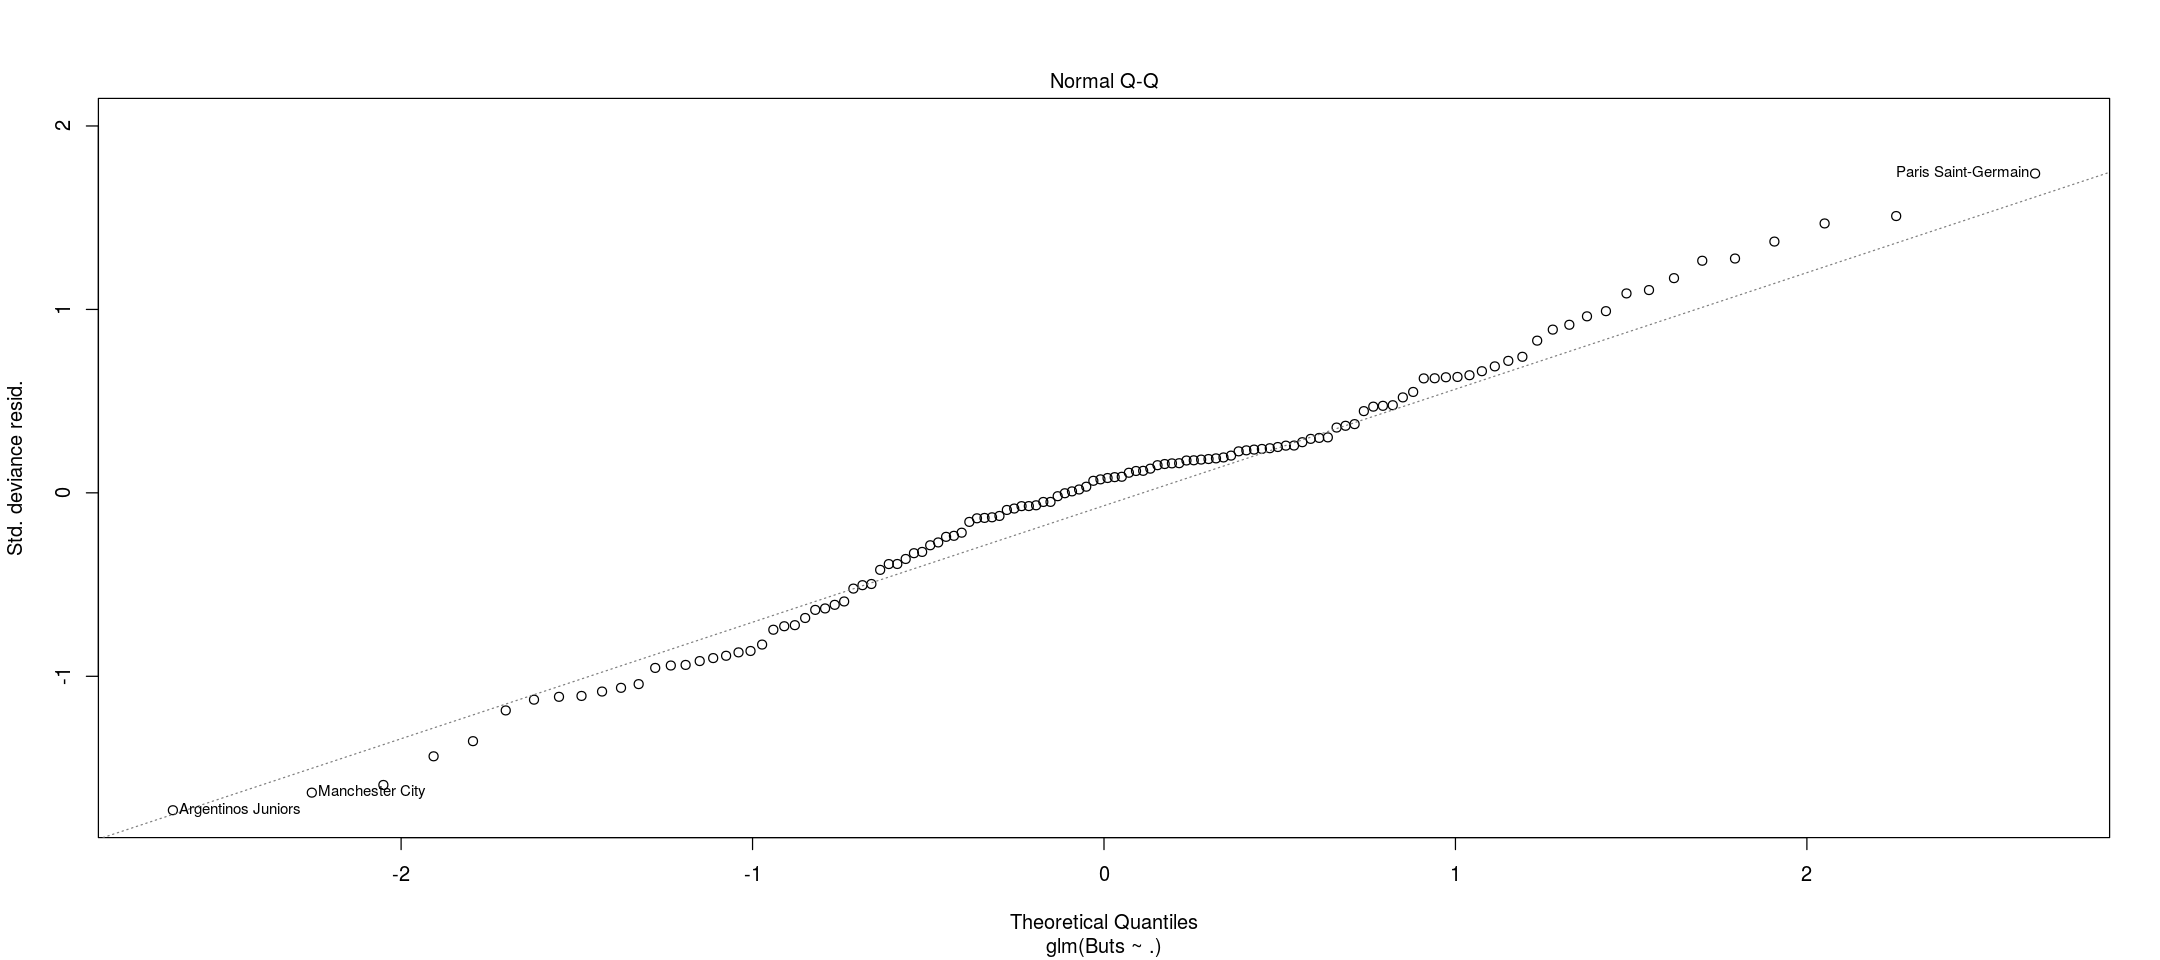

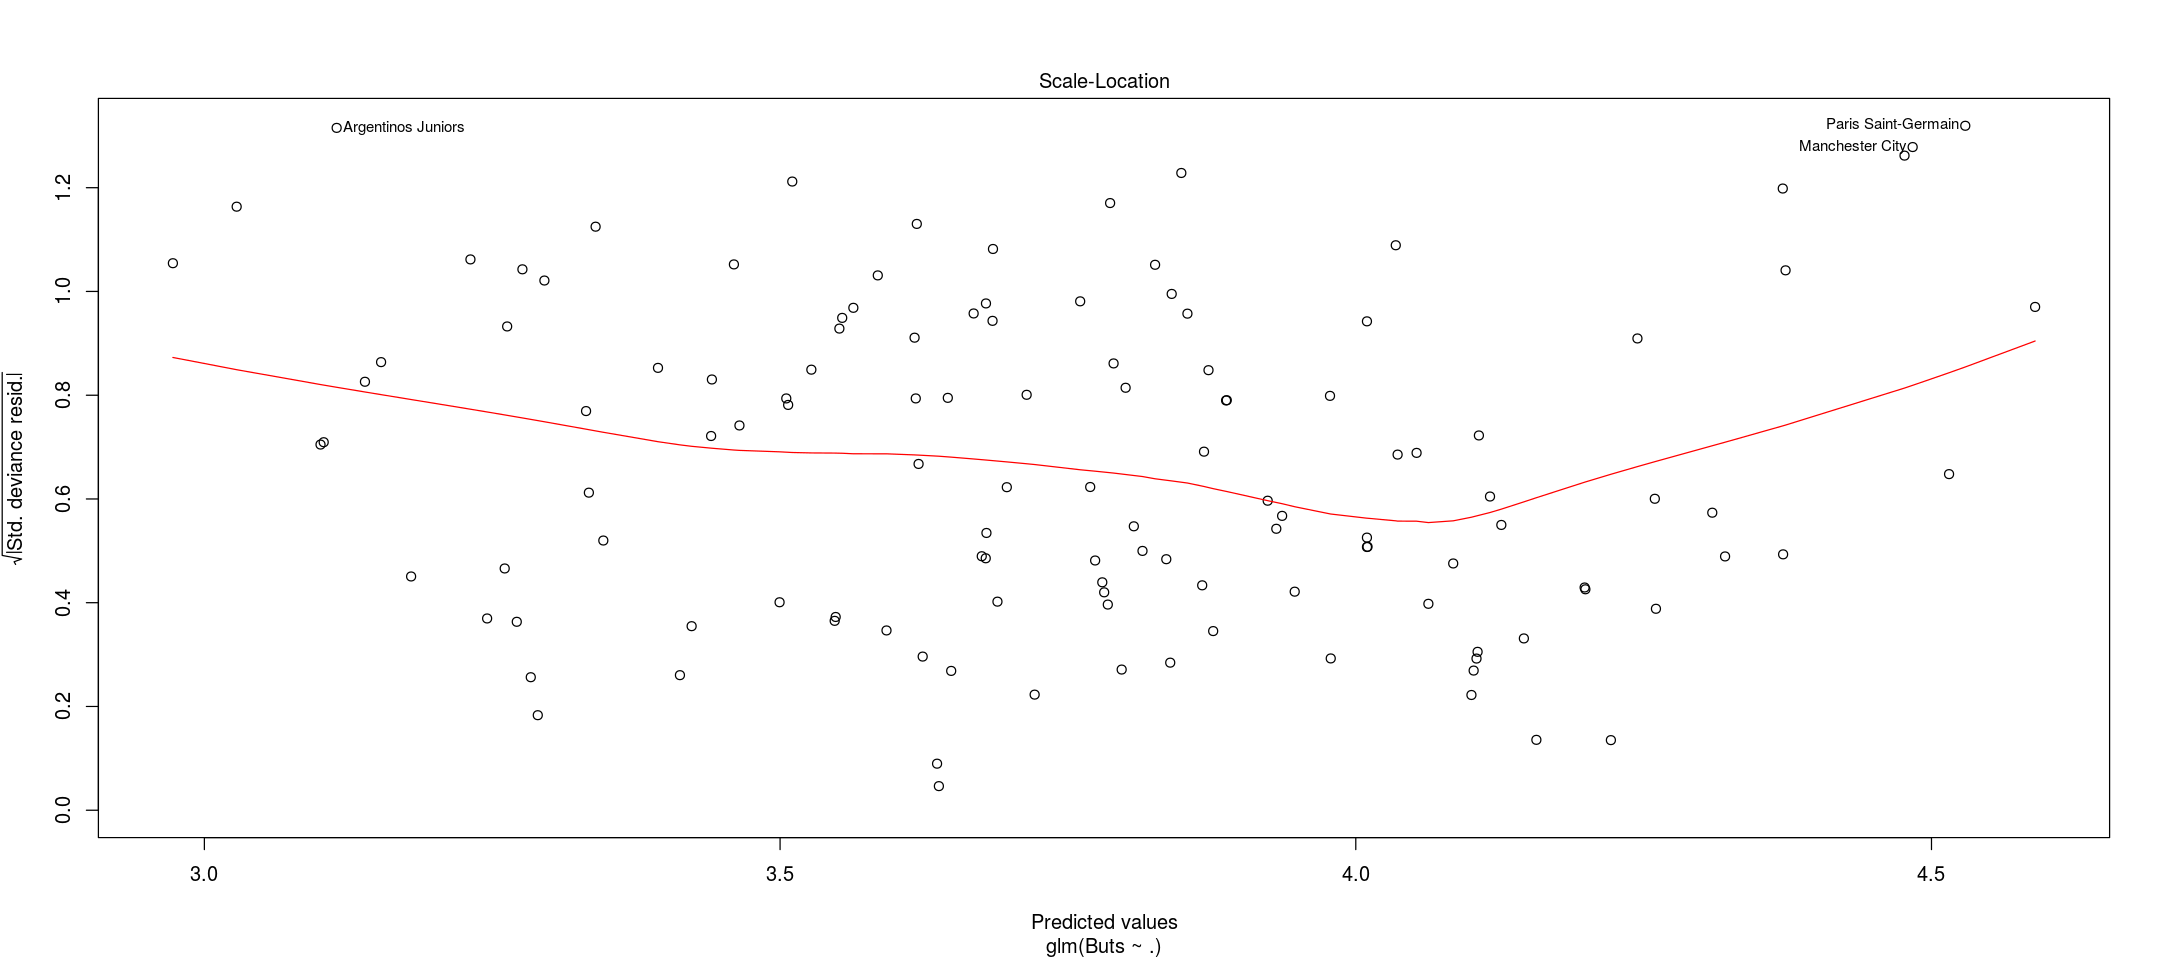

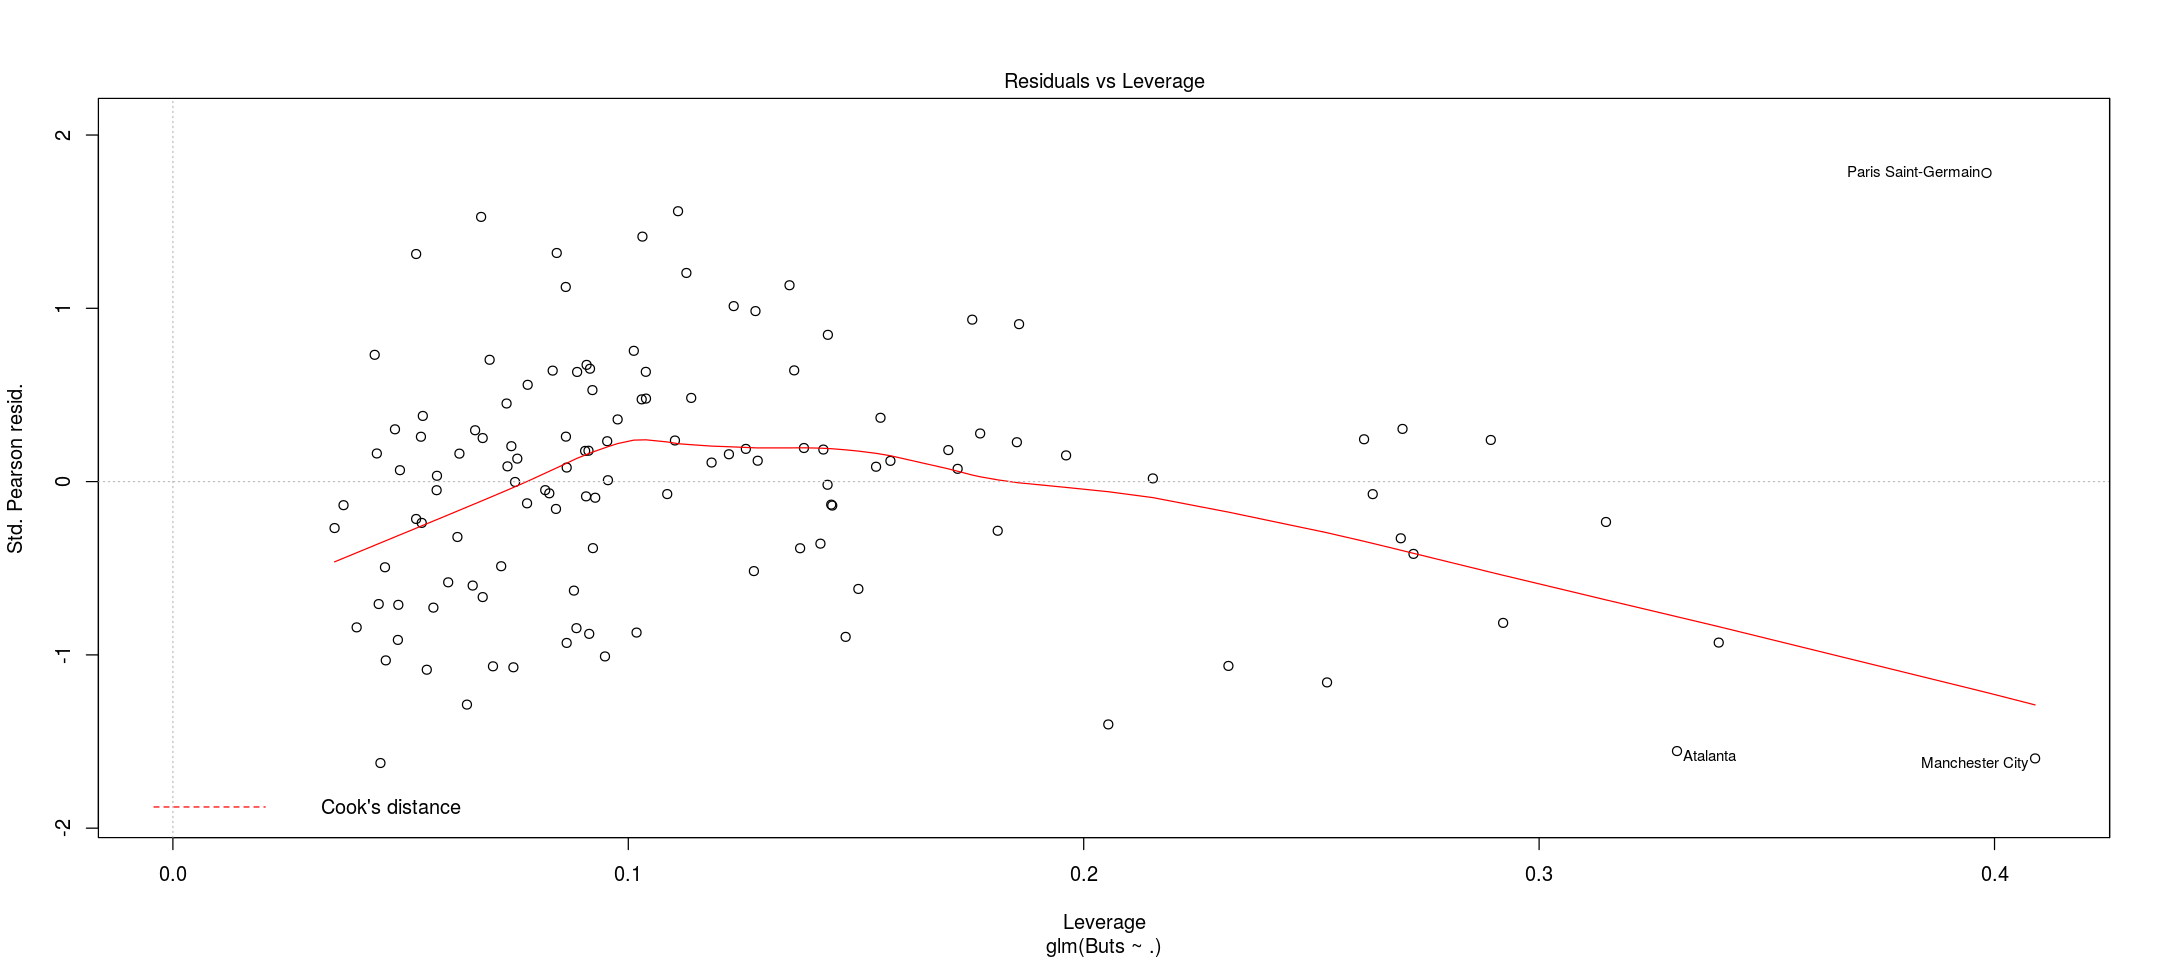

In [56]:
plot(fit_poisson_tot)

In [57]:
R_squared = 1 - fit_poisson_tot$deviance/fit_poisson_tot$null.deviance
print(paste("R^2 du modèle de poisson :", R_squared))

[1] "R^2 du modèle de poisson : 0.93401160079489"


Le $R^2$ est très proche de 1 donc le modèle de régression de Poisson additif semble bien expliquer la variable du nombre de buts. C'est bizarre que ce $R^2$ soit meilleur que le précédent, car on observe des formes dans les résidus (une banane).

# Variable  = nombre de points à l'issue de la saison

In [165]:
points = data_tot$Points

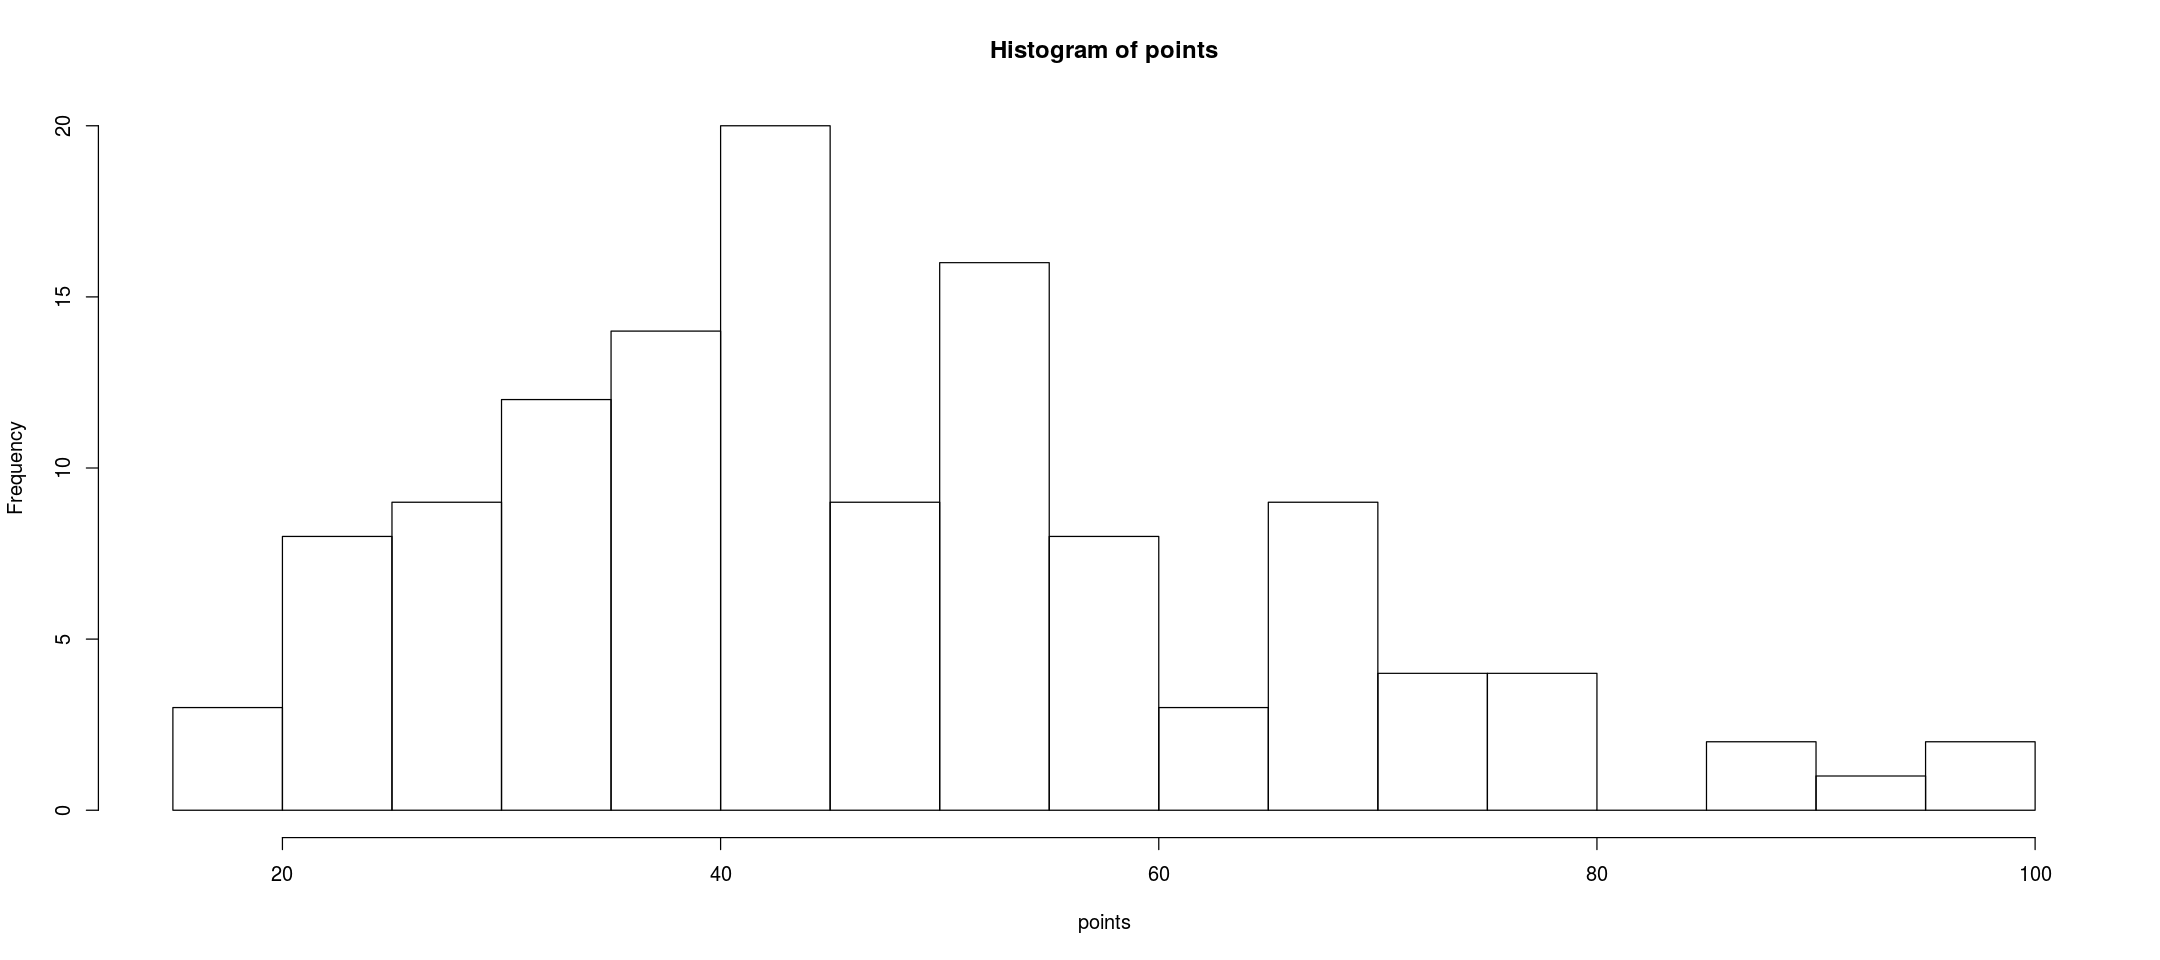

In [166]:
hist(points, breaks=12)

In [167]:
data_but_tot$Points = points

In [168]:
choix_points <- regsubsets(data_but_tot$Points~., data = data_but_tot, nbest=1, nvmax=10, method="seqrep")

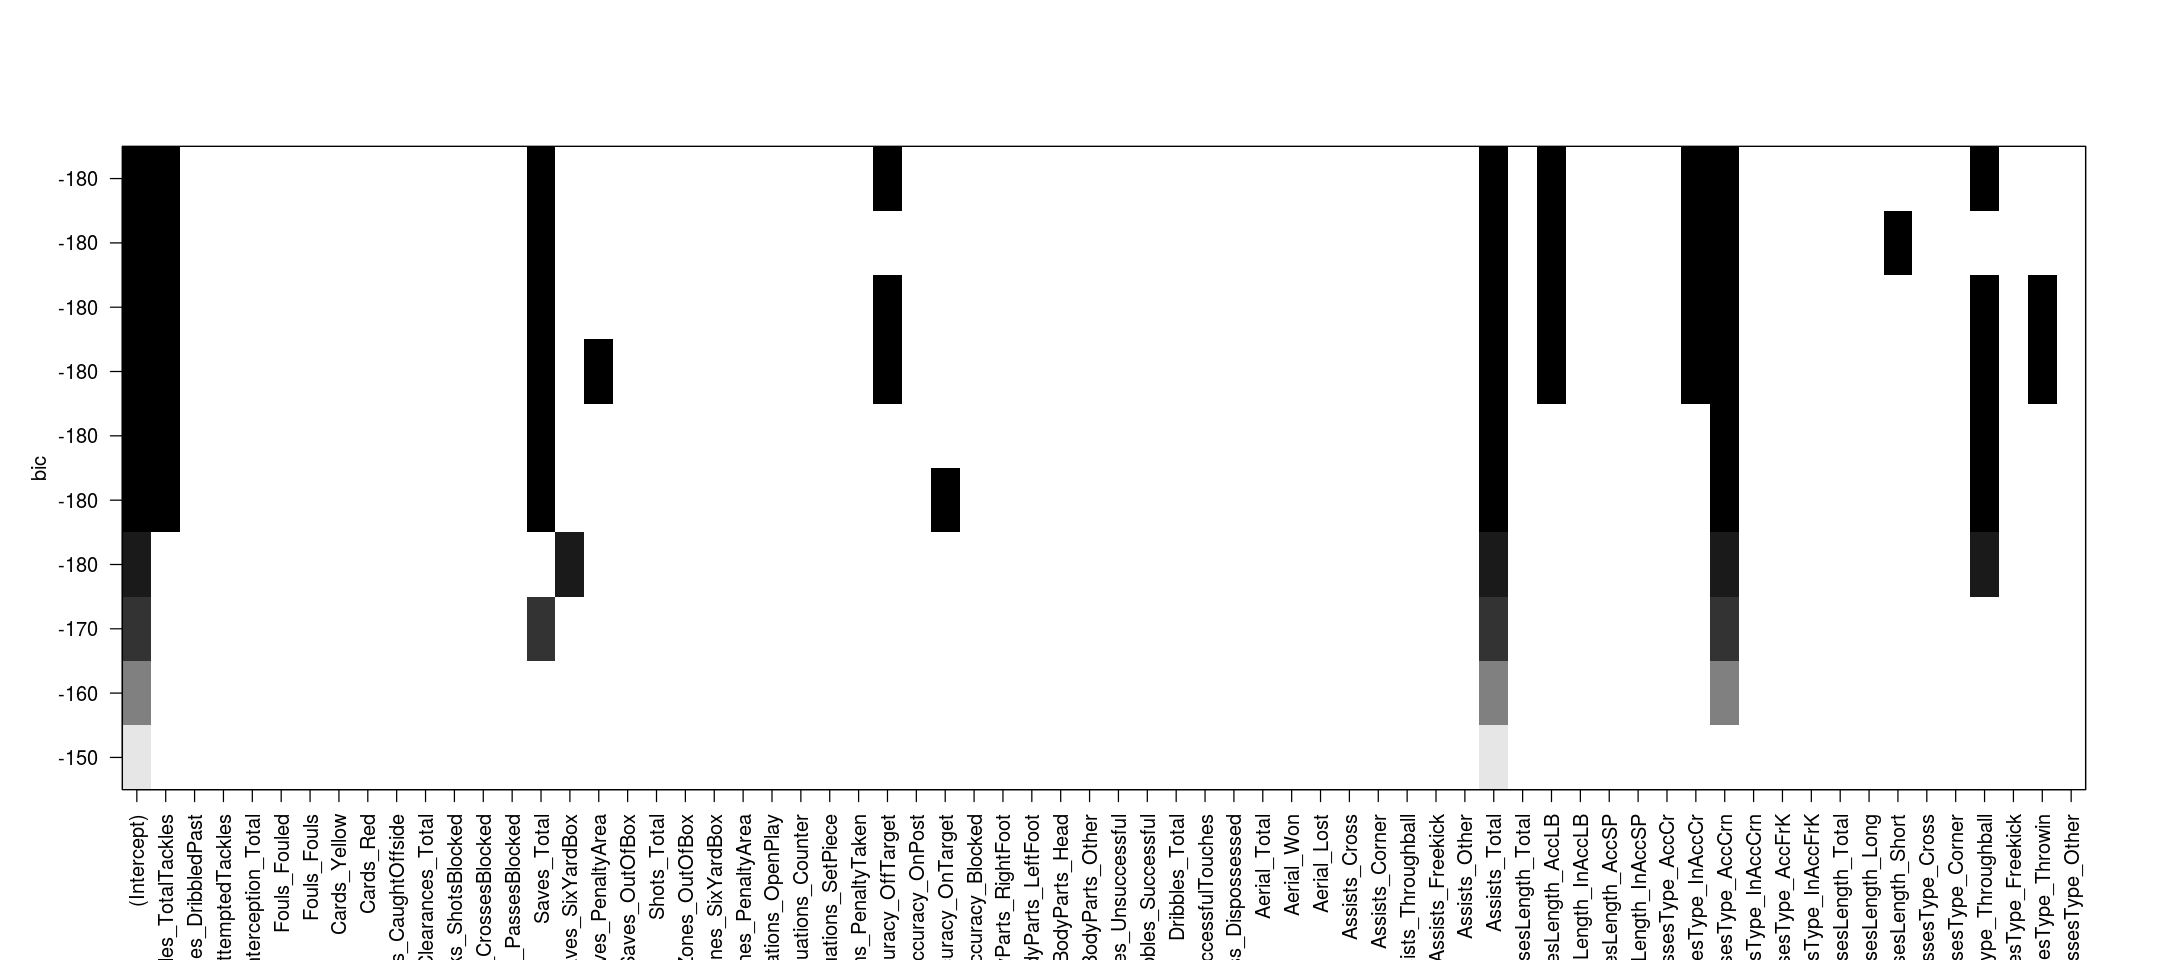

In [169]:
options(repr.plot.width=18, repr.plot.height=8)
plot(choix_points,scale="bic")

In [173]:
nb_min = which.min(summary(choix_points)$bic)
coefs.points = coef(choix_points, nb_min)
coefs.points

(Intercept)      Tackles_TotalTackles               Saves_Total 
               1.53482746                0.02672957               -0.15833902 
  ShotsAccuracy_OffTarget             Assists_Total        PassesLength_AccLB 
               0.07629696                0.64676916                0.01303991 
       PassesType_InAccCr         PassesType_AccCrn KeyPassesType_Throughball 
              -0.03579196                0.16286076                0.30772892

In [217]:
for (i in 1:nb.variables.buts){
    for (j in 1:(length(names(coefs.points))-1)){
        if (choix_points$xnames[i+1] == names(coefs.points)[j+1]){
            df.variables.buts$NombreDePoints[i] = round(coefs.points[j+1],3)
        }
    } 
}

Les variables influentes sur le nombre de points sont les variables ci-dessus.

In [64]:
data_bic_points = data.frame(points,
                     data_but_tot$Tackles_TotalTackles,
                     data_but_tot$Saves_Total, data_but_tot$ShotsAccuracy_OffTarget, 
                     data_but_tot$Assists_Total, data_but_tot$PassesLength_AccLB, 
                     data_but_tot$PassesType_InAccCr,
                     data_but_tot$PassesType_AccCrn, data_but_tot$KeyPassesType_Throughball)

names(data_bic_points) <- c("Points", "Tackles_TotalTackles", 
                     "Saves_Total", "ShotsAccuracy_OffTarget",
                     "Assists_Total", 
                     "PassesLength_AccLB", "PassesType_InAccCr", 
                     "PassesType_AccCrn", "KeyPassesType_Throughball")


In [65]:
rl_points = lm(formula = Points~.,data = data_bic_points)

In [66]:
r_squared = summary(rl_points)$r.squared
print(paste("R^2 pour un modéle linéaire :", r_squared))

[1] "R^2 pour un modéle linéaire : 0.837341705382205"


Le $R^2$ est moins bon que losqu'on explique le nombre de buts avec une régression loglinéaire. On s'en doutait un peu car le fait de calculer les points au classement n'est pas équivalent au nombre de buts. Ca ne dépend que de l'issue du match, et pas de son déroullement.

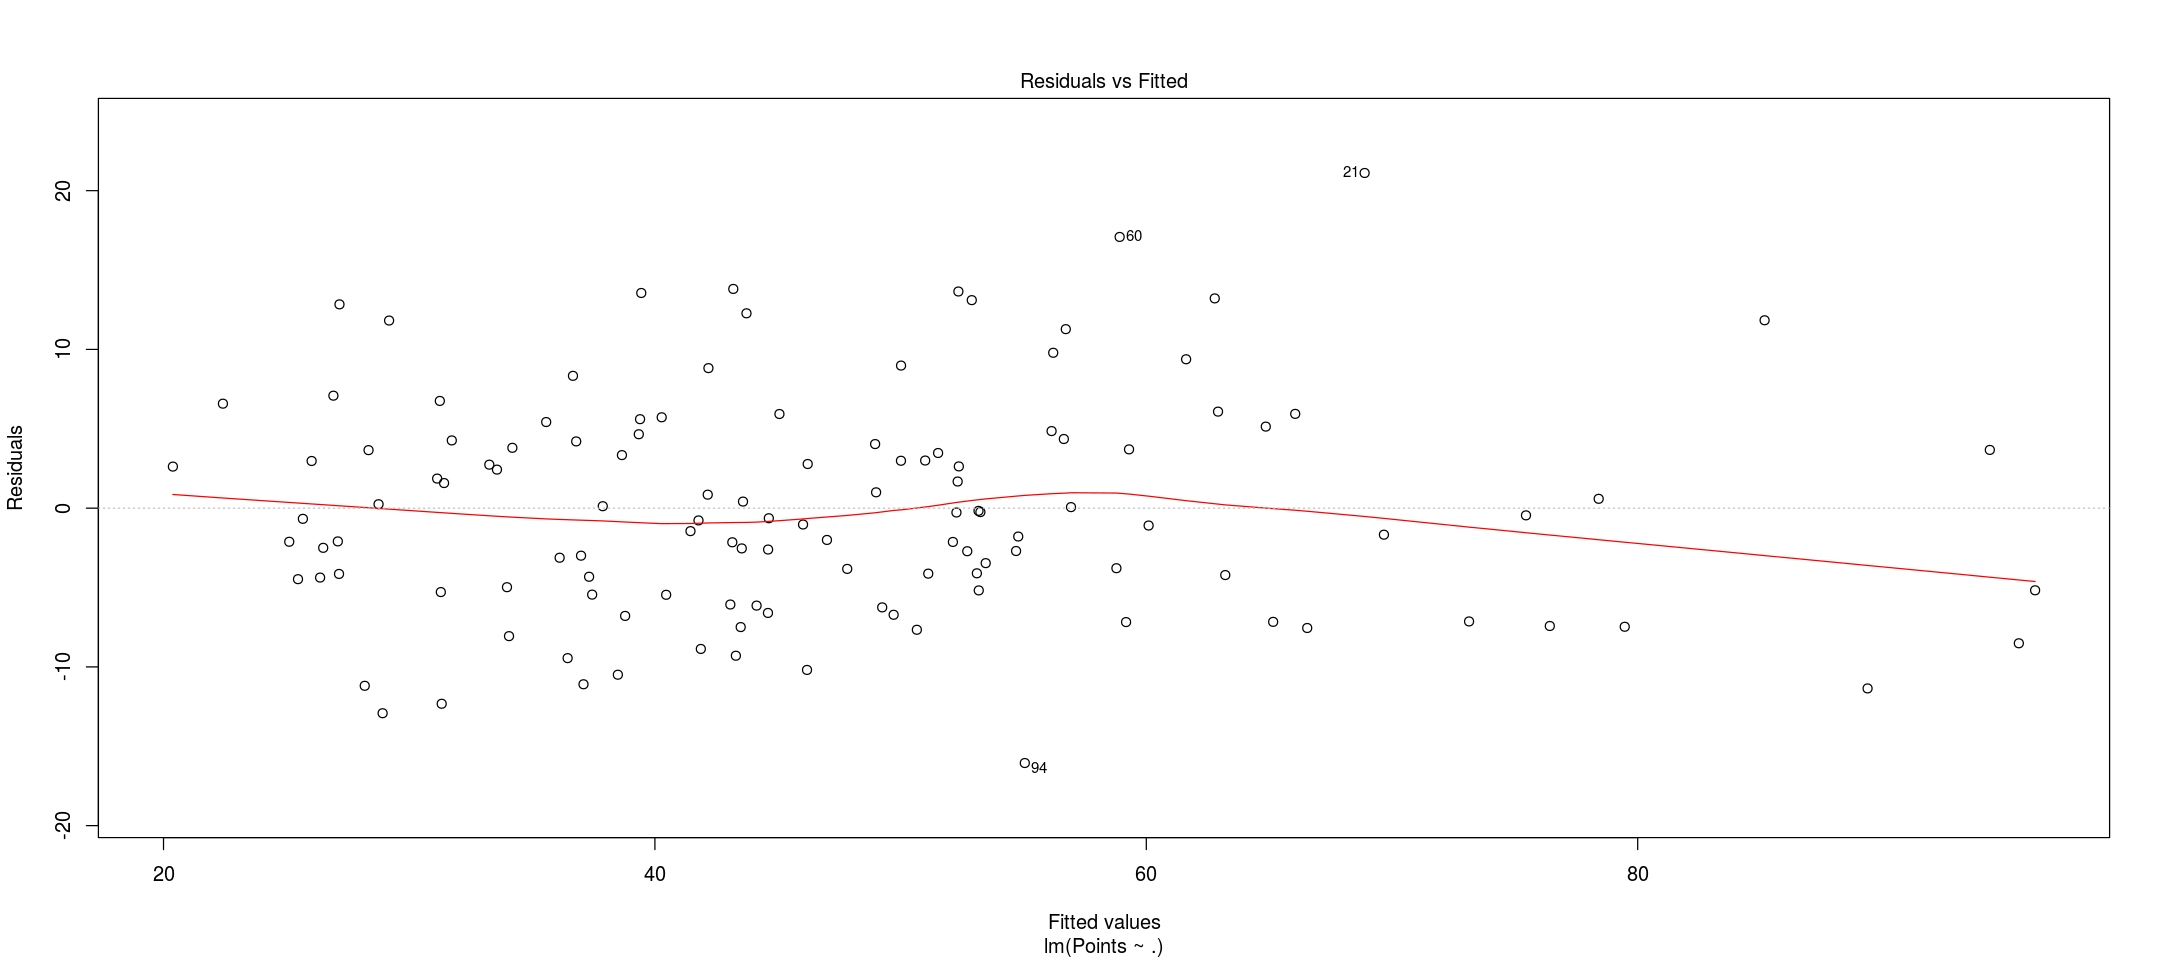

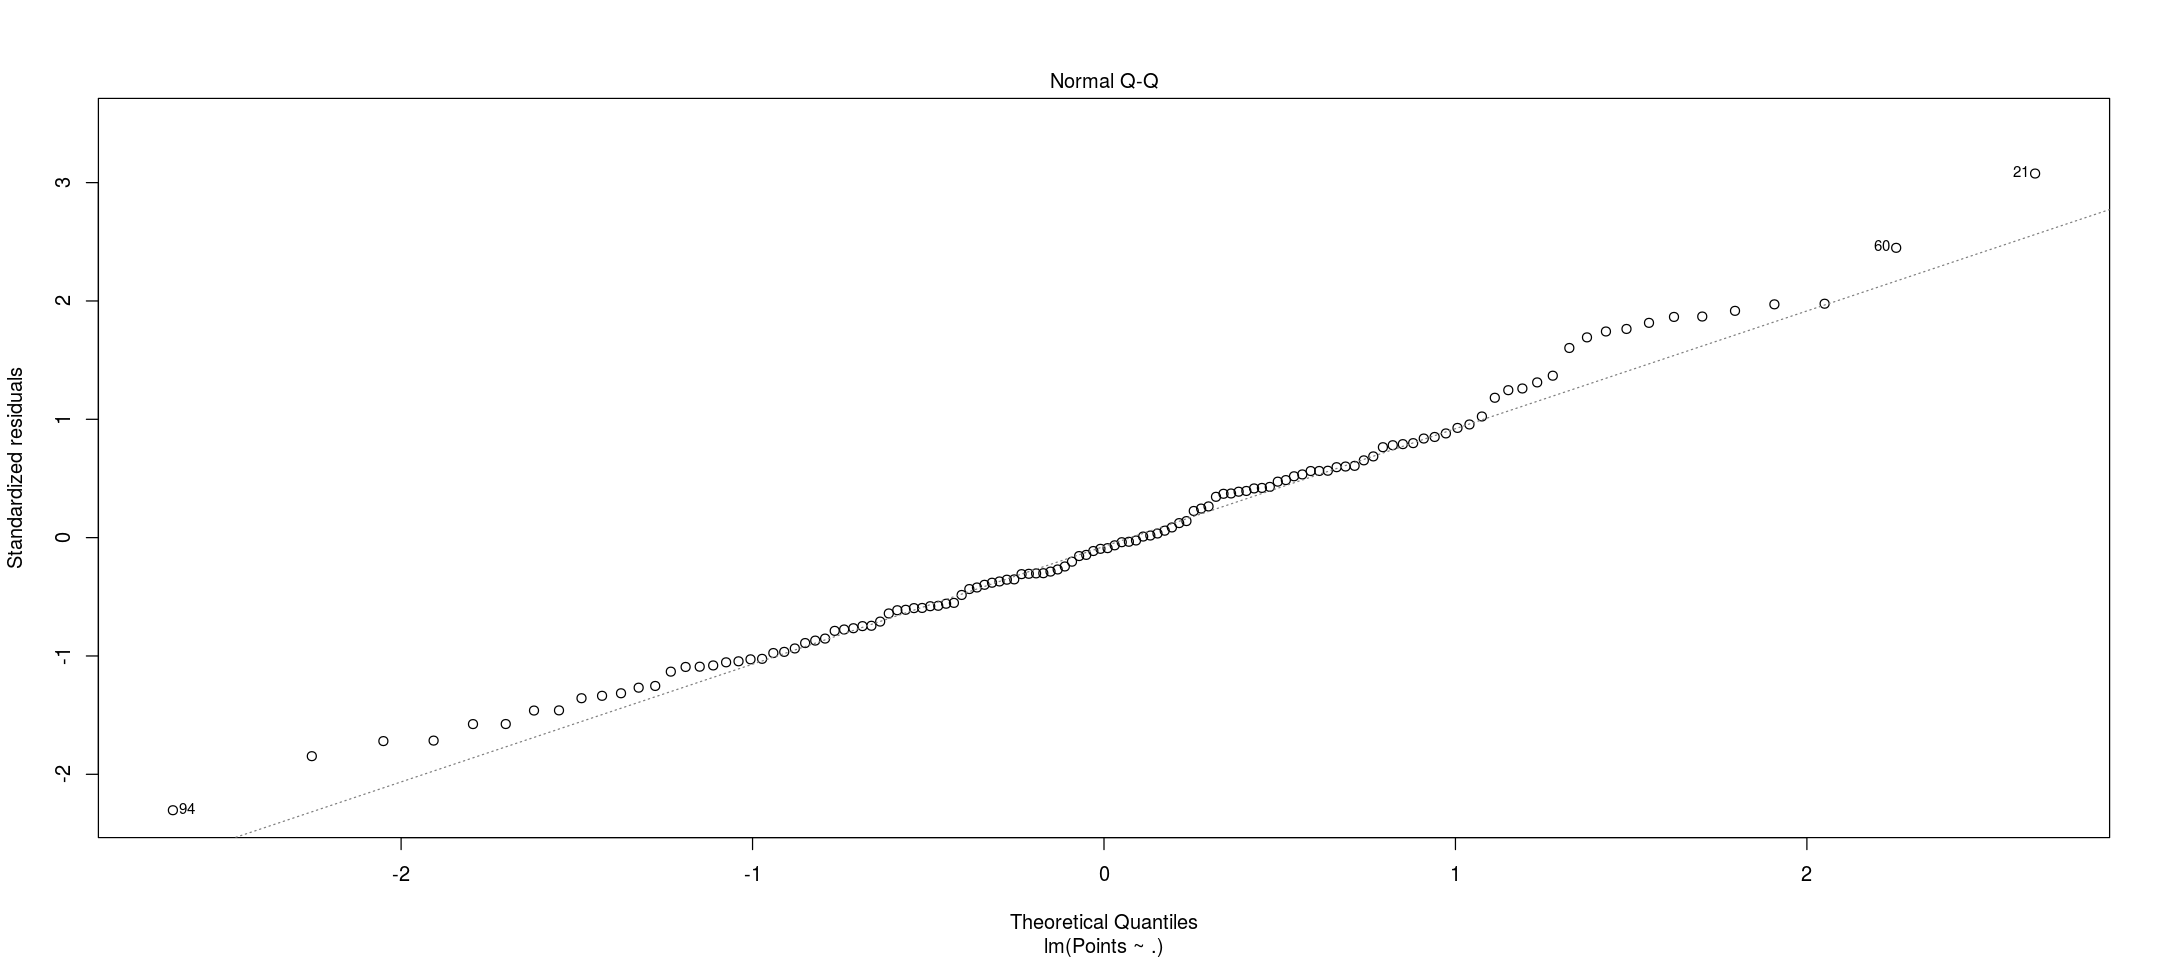

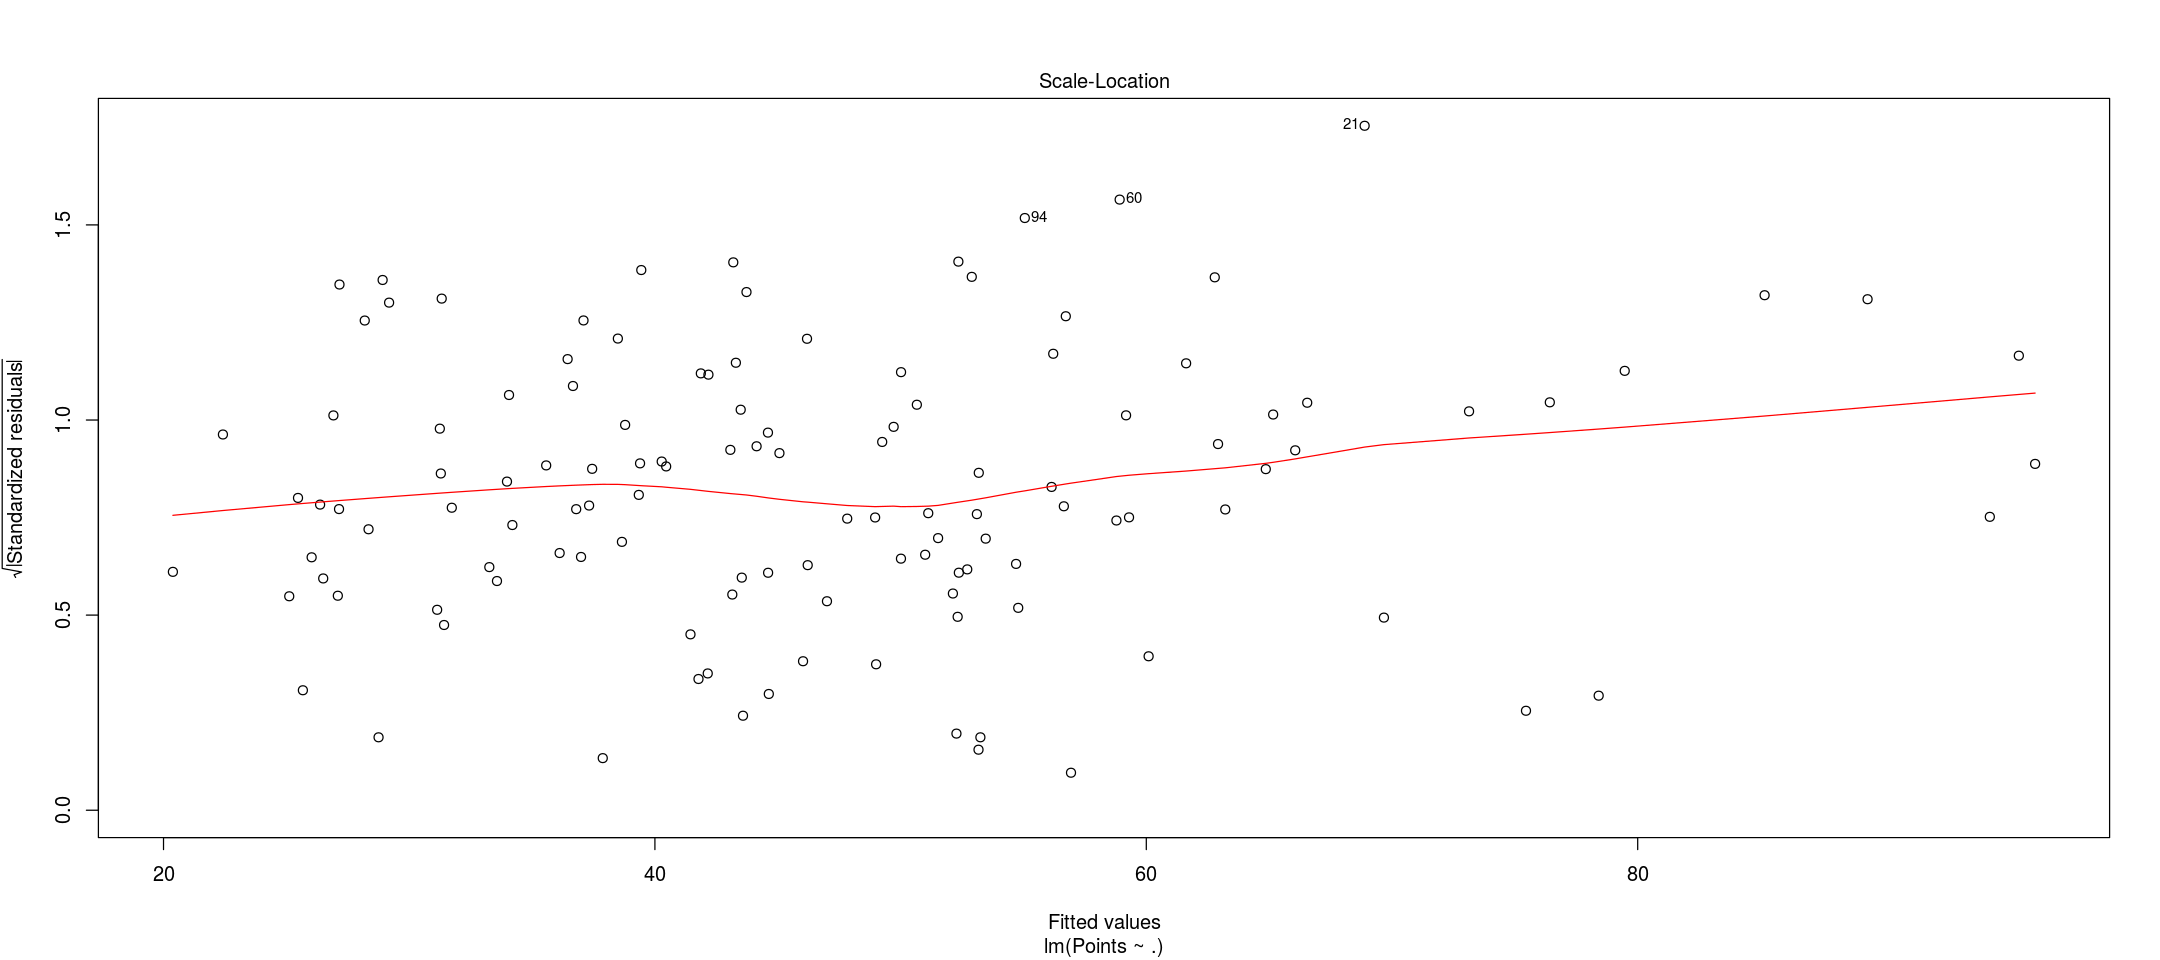

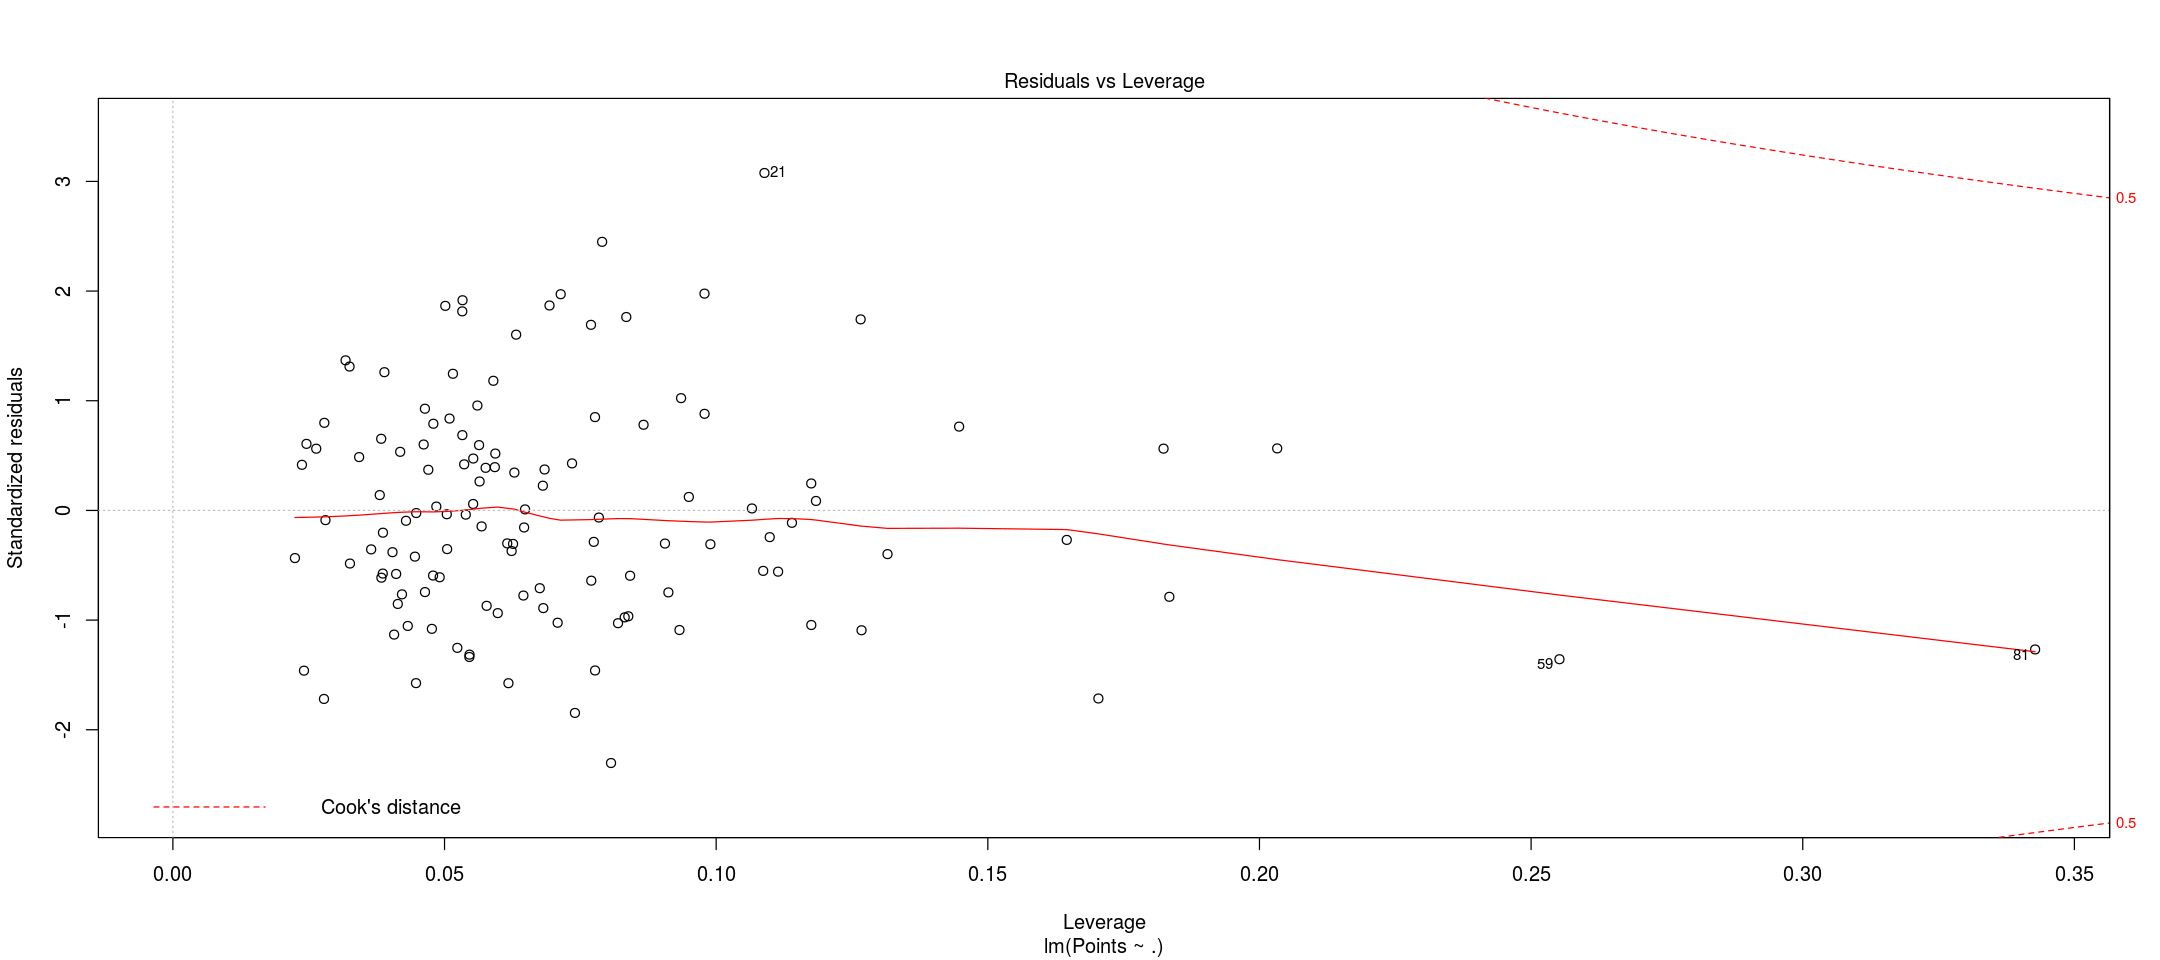

In [68]:
plot(rl_points)

Peut être qu'une autre régression serait à envisager, mais on ne sait pas laquelle.

In [67]:
help("family")

# REPRÉSENTATION DES RÉSULTATS

In [267]:
df.buts.sans_zeros = df.variables.buts[rowSums(df.variables.buts[,2:6]^2) > 0, ]

In [268]:
mat.variables.buts = data.matrix(df.buts.sans_zeros[,2:6])

In [269]:
rownames(mat.variables.buts) = df.buts.sans_zeros$Noms

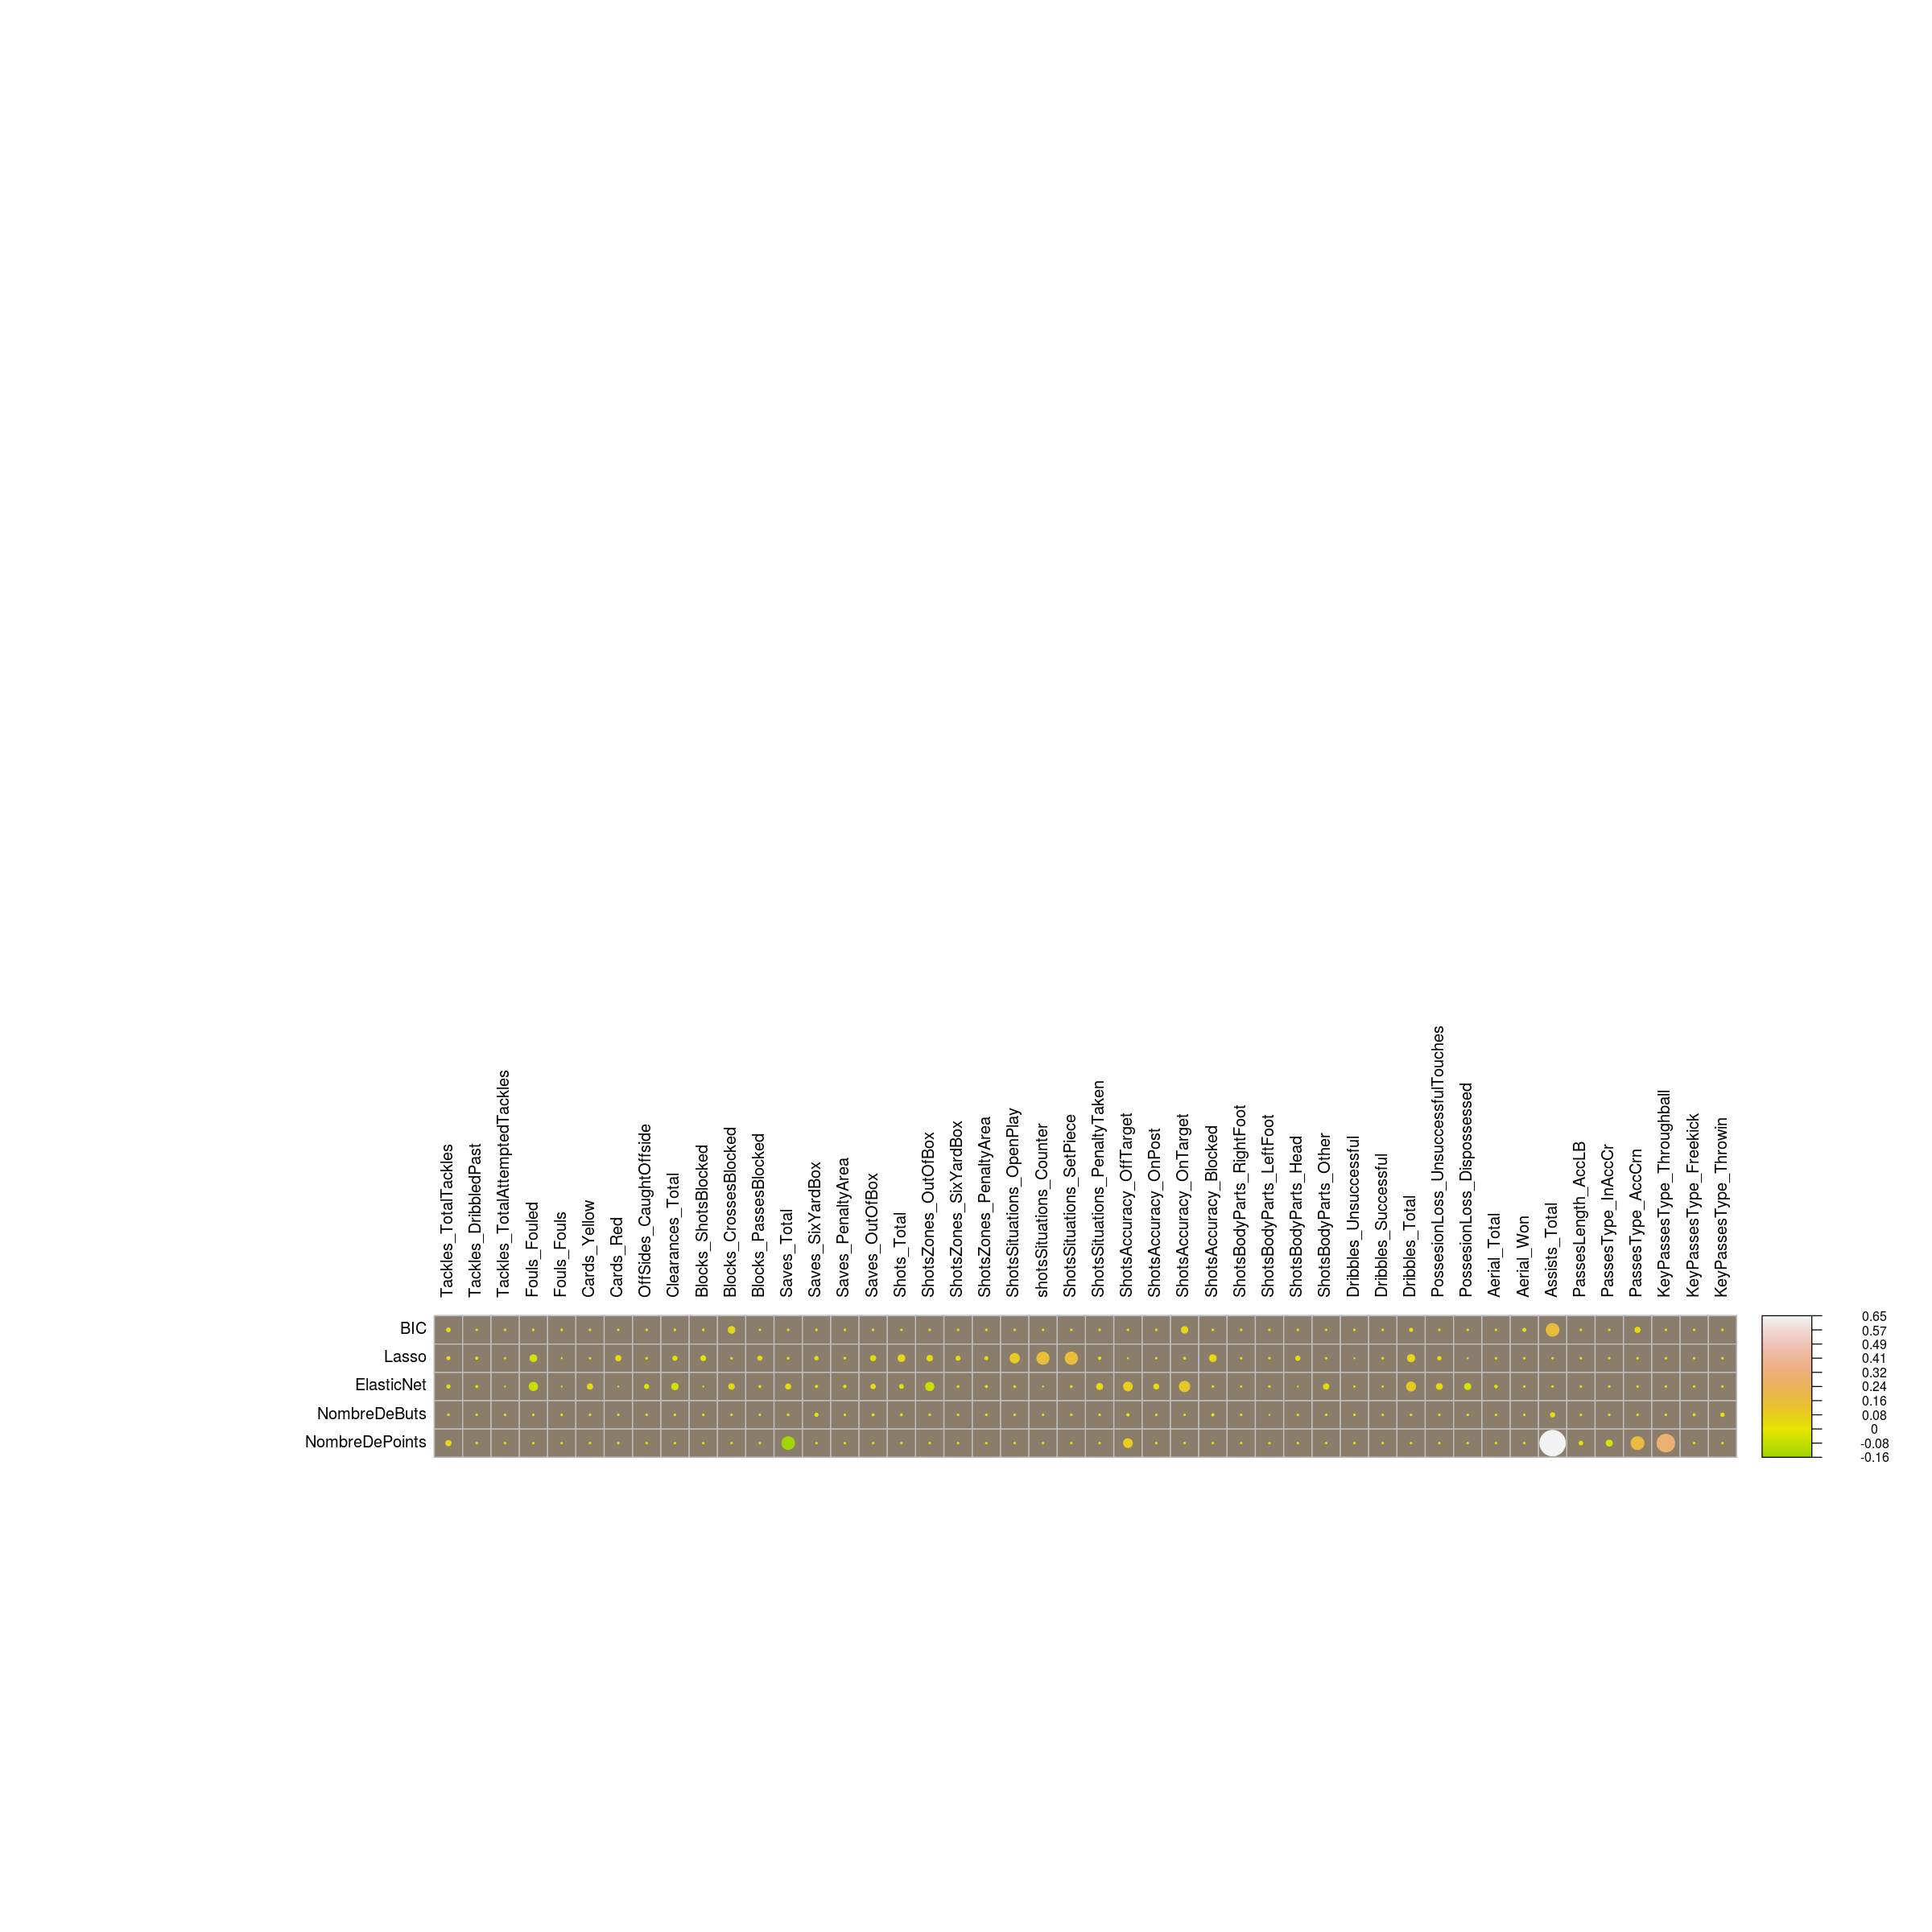

In [316]:
options(repr.plot.width=20, repr.plot.height=20)
corrplot(t(mat.variables.buts), is.corr = FALSE, method = "circle", tl.col = 1, bg = "bisque4", col = terrain.colors(100))#, col = c("blue", "red"))#, col = col1(100))